In [114]:
import os
import numpy as np
import nibabel as nib
from scipy.stats import scoreatpercentile, linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score


# Setting up data

In [115]:
patients_interictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patients_preictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patients_ictal = ["sub-patient001","sub-patient002","sub-patient003","sub-patient004","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"]
patients_postictal = ["sub-patient001","sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient034","sub-patient038","sub-patient041", "sub-patient043","sub-patient045"]

patientsASL_interictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient007","sub-patient008","sub-patient009","sub-patient012","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsASL_preictal = ["sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013", "sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsASL_ictal = ["sub-patient001","sub-patient003","sub-patient004","sub-patient005","sub-patient006","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"]
patientsASL_postictal = ["sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient034", "sub-patient038","sub-patient041", "sub-patient043","sub-patient045"]

patientsCVR_interictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsCVR_preictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsCVR_ictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"] # !!! SUB-PATIENT004 NOT INCLUDED FOR NOW
patientsCVR_postictal = ["sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]

controls_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]
controls_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]

ASLcontrols_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]
ASLcontrols_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]

CVRcontrols_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control033","sub-control046","sub-control048","sub-control051"]
CVRcontrols_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control051"]

In [116]:
# ROIs

# one list for each phase and each COPE of each ROI

# Ramyg

RamygH_midcycle = [-0.4653, -0.1051, 1.071, -0.3048, 0.5787, -0.1757, -0.4059, 0.7063, 2.3e-05, -0.3249, 0.4505, -0.1944, -0.02567, 0.1625, -0.3067]
RamygH_premenstrual = [0.444, -0.4855, 0.04422, 0.05321, 0.2834, 0.09982, 0.1938, 0.2881, -1.754, -0.2671, 0.3349, -0.2811, -0.1213, -0.3021, 0.251]
RamygH_interictal = [-0.4309, -0.6558, -0.02848, -0.02502, 0.7202, 0.2871, -0.182, -0.02582, 0.5211, -0.2914, -0.1328, -0.3844, 0.2013]
RamygH_preictal = [-0.3532, -0.1717, -0.3486, -0.7294, 0.3636, -0.4463, -0.3695, 0.3805, -0.0444, -0.2349, -0.02301, -0.5599]
RamygH_ictal = [0.03015, 0.1615, 0.4716, 0.1519, -0.01011, -0.03284, 0.2677, 0.5649, 0.6967, 0.1373, -0.208, -0.2938, -0.5172, 0.6587]
RamygH_postictal = [-0.05605, -0.4256, 1.227, -0.04399, 0.6687, 0.356, -0.3905, 0.4734, 0.6567, -1.183, 0.1943, -0.1741, -0.5184]

RamygA_midcycle = [-0.587, 0.6193, 1.326, -0.4154, 0.8634, -0.1659, -0.6578, -0.3896, 0.09717, 0.03624, 0.9911, 0.01081, -0.3049, 0.0344, 0.1172]
RamygA_premenstrual = [0.7686, -0.1447, -0.5409, 0.3594, 0.3035, -0.4735, -0.1238, 0.2039, 0.1654, 0.3256, -0.06816, -0.1728, 0.0834, -0.1806, -0.1649]
RamygA_interictal = [0.1882, -0.6844, 0.1008, 0.1301, 0.5665, 0.4141, 0.8563, 0.1637, 0.8957, 0.4957, 0.106, 0.849, 0.5026]
RamygA_preictal = [-0.06247, 0.3023, 0.3063, -0.3881, -0.1873, -0.9075, 0.4969, 0.3143, -0.3582, -0.1877, -0.5591, -0.1028]
RamygA_ictal = [0.4693, 0.6051, -0.5948, 0.00454, -0.3231, -0.2038, 0.9996, 0.1433, 0.1673, 0.1132, -0.1617, -0.1494, -0.02932, 0.1816]
RamygA_postictal = [-0.06739, 0.4641, 0.4364, 0.1693, 0.7482, 0.45, -0.6953, 0.5669, 0.5031, 0.2911, 0.2711, -0.8241, -0.5384]

RamygV_midcycle = [0.1392, -0.238, 0.07393, 0.1139, 0.1614, 0.3352, 0.05439, -0.615, 0.179, -0.3523, 0.4787, 0.1106, -0.128, -0.1479, -0.3438]
RamygV_premenstrual = [0.2581, 0.2055, -0.1938, -0.3254, -0.1159, 0.2508, -0.113, -0.07533, -0.07506, 0.7613, -0.05241, -0.1162, -0.6466, 0.2673, 0.09723]
RamygV_interictal = [0.2067, 0.09197, 0.4199, 0.2318, 0.007578, 0.08721, -0.06519, 0.2628, 0.05775, -0.4106, -0.5287, -0.1496, -0.05306]
RamygV_preictal = [-0.05839, 0.6116, -0.1861, 0.08571, -0.2844, -0.1334, 0.1418, 0.3269, -0.05926, -0.1667, -0.3937, 0.01474]
RamygV_ictal = [0.2219, 0.05039, 0.06422, 0.1821, -0.2676, -0.2023, -0.1095, 0.1826, 0.3736, 0.1461, -0.5762, -0.2292, 0.02796, 0.2698]
RamygV_postictal = [-0.007878, -0.02301, 0.2148, 0.1171, -0.1456, -0.003031, 0.06555, 0.0615, 0.1561, -0.08263, -0.2104, -0.02652, -0.05883]

# Lamyg

LamygH_midcycle = [-0.9758, -0.021, 0.72, 0.09362, 0.516, 0.02123, -0.02426, 0.724, 0.26, 0.4917, 0.1972, -0.2001, 0.7764, 0.1289, 0.1737]
LamygH_premenstrual = [0.3185, -0.4643, 0.1127, 0.5088, 0.3627, 0.3207, -0.02375, 0.3808, -1.069, -0.4625, -0.3297, 0.05927, 0.007172, 0.05788, 0.1929]
LamygH_interictal = [-0.6101, -0.3512, -0.2046, 0.1428, 0.522, 0.343, 0.3917, -0.08673, 0.4205, -0.7343, 0.1933, -0.199, 0.1478]
LamygH_preictal = [-0.08121, -0.3295, -0.2615, -1.003, 0.2268, 0.1458, 0.3047, -0.01406, 0.2309, -0.2074, 0.4778, 0.06549]
LamygH_ictal = [-0.3674, 0.1406, 0.8583, 0.2967, 0.3724, 0.0753, 0.2814, 0.6719, 0.2916, 0.2693, -0.4231, -0.6341, -0.3449, -0.06168]
LamygH_postictal = [-0.1802, -0.6726, 1.173, 0.4051, 0.5603, 0.4146, -0.4815, 0.5554, 0.6959, -1.38, 0.1267, -0.05495, -1.018]

LamygA_midcycle = [-0.9299, 0.3815, 0.943, -0.7156, 0.4837, 0.0827, -0.335, -0.221, 0.07638, -0.1053, 0.9009, 0.1858, 0.4372, 0.002035, 0.5198]
LamygA_premenstrual = [0.1856, -0.02709, -1.186, 0.5754, 0.4372, -0.4165, -0.007279, 0.5205, 0.0183, 0.1129, -0.3739, -0.1103, 0.1167, 0.5924, -0.1291]
LamygA_interictal = [0.4451, -0.8365, -0.08692, -0.5069, 0.4247, 0.2844, 0.7535, 0.1923, 0.399, -0.02641, 0.5187, 0.7399, 0.2272]
LamygA_preictal = [-0.03417, -0.4556, 0.3177, 0.02193, -0.2971, -0.8989, 0.6442, 0.2082, 0.3892, -0.6434, 0.1618, 0.6921]
LamygA_ictal = [0.2381, 0.9101, -0.1531, -0.09742, 0.233, -0.1717, 1.105, 0.1283, -0.02192, 0.06342, -0.369, -0.561, 0.6063, 0.3196]
LamygA_postictal = [0.1375, 0.2641, -0.02401, 0.2416, 0.7007, 0.2055, -0.4298, 0.4367, 0.2267, -0.1136, 0.3968, -0.6001, -0.2407]

LamygV_midcycle = [1.078, 1.253, 0.2401, -0.4623, 0.5778, 0.3436, 0.589, -0.3741, 1.023, -0.1619, 1.43, 0.3711, 0.3233, 0.3932, 0.9255]
LamygV_premenstrual = [1.24, 0.292, -0.6598, 0.06023, 0.6958, 1.002, 0.3332, 0.4009, 0.5742, 0.6837, 0.6774, -0.05273, 0.5683, 0.5991, 0.5659]
LamygV_interictal = [1.786, 0.2603, 0.3923, -0.5068, 0.3063, 0.799, 0.404, 0.4238, 0.5404, 0.4543, -0.07865, 0.707, 1.199]
LamygV_preictal = [0.7995, 0.2752, 0.4436, 0.6949, 1.032, 0.2645, 0.3097, 0.7344, 0.1811, 0.5338, 0.7139, -0.2102]
LamygV_ictal = [1.165, 1.49, 0.9436, 0.531, -0.2732, 0.6566, 0.3552, 0.6247, 0.5888, 1.042, 0.7061, -0.05404, 0.3136, 0.4781]
LamygV_postictal = [0.9733, 1.036, -0.2771, 0.7716, 0.7041, 0.0854, 0.1197, 0.205, 1.175, 1.47, 0.1281, 1.417, 0.9077]

# Lthalamus

LthalH_midcycle = [-0.2384, -0.04904, 0.6765, -0.04249, 0.2187, 0.1984, -0.04169, 0.6523, 0.5767, 0.6961, -0.3439, 0.03151, -0.4328, -0.000514, 0.148]
LthalH_premenstrual = [-0.1385, -0.2855, 0.6859, 0.07122, 0.4443, 0.006832, -0.1813, -0.01087, -0.4603, -0.4585, -0.3747, -0.237, 0.2024, 0.173, -0.008291]
LthalH_interictal = [-0.1448, -0.09541, 0.1639, 0.06219, -0.2066, 0.3111, -0.4648, -0.2132, 0.2501, -0.2987, -0.5524, -0.0873, 0.02882]
LthalH_preictal = [0.3876, -0.3029, -0.2528, 0.1542, 0.647, 0.2371, 0.3449, -0.2629, 0.1899, 0.3449, 0.1276, 0.2259]
LthalH_ictal = [-0.9333, -0.1795, 0.3144, 0.57, 0.4133, -0.02742, 0.3049, 0.2236, -0.4392, -0.05413, 0.003022, 0.1734, -0.02399, 0.5795]
LthalH_postictal = [-0.5507, -1.21, -0.3343, -0.2978, -0.1231, 0.5176, -0.05869, 0.0411, 0.3507, -0.5125, -0.08491, -0.09714, -0.06622]

LthalA_midcycle =  [-0.003091, -0.1417, 0.6717, -0.2962, 0.3734, 0.1365, 0.09228, -0.3877, 0.1273, 0.1866, 0.3764, 0.03657, -0.2321, 0.2003, 0.5696]
LthalA_premenstrual =  [-0.03835, -0.1099, 0.002919, 0.05663, 0.4216, -0.4366, -0.05733, 0.2391, -0.1125, -0.4055, -0.1747, -0.1111, 0.4393, 0.2067, -0.1092]
LthalA_interictal =  [0.5803, -0.3066, 0.1495, 0.204, -0.6896, -0.1763, -0.02904, -0.2052, 0.2157, -0.3182, -0.2897, 0.8465, -0.5936]
LthalA_preictal =  [0.3765, -1.024, -0.3991, 0.09069, -0.5637, -0.2426, 0.2512, -0.1529, 0.3592, 0.1416, -0.2868, -0.04358]
LthalA_ictal =  [-0.01392, 0.4096, 0.3679, 0.03324, -0.04354, -0.1018, 0.4824, 0.04042, -0.6414, 0.1213, 0.01205, -0.1251, 0.07768, 0.2851]
LthalA_postictal =  [-0.7169, -0.08451, 0.007936, -0.3456, 0.07255, 0.2279, -0.1387, 0.5633, 0.4299, -0.6761, 0.004829, -0.4438, -0.1964]

LthalV_midcycle = [0.2719, -0.09982, 0.2983, 0.2477, 0.5134, 0.5194, -0.1663, -0.5531, 0.1714, -0.4964, 0.9293, -0.006648, -0.1163, -0.02208, -0.4698]
LthalV_premenstrual = [0.8495, 0.04822, -0.2224, -0.08682, -0.1651, 0.4503, -0.09724, 0.05401, -0.2383, 1.032, 0.08724, -0.259, -1.285, 0.3666, -0.001281]
LthalV_interictal = [0.5876, 0.03498, 0.5275, 0.3928, -0.1616, 0.06706, 0.1838, 0.3707, 0.2187, -0.3959, -0.4462, 0.2158, 0.00892]
LthalV_preictal = [-0.004514, 1.051, -0.3133, 0.3619, -0.3794, -0.4757, 0.6006, 0.4585, -0.8093, -0.2911, -0.08834, 0.3368]
LthalV_ictal = [0.3013, 0.1806, 0.1953, 0.2573, -0.6631, -0.3958, -0.2119, 0.2362, 0.6502, 0.3457, -0.3178, -0.2026, 0.4196, 0.2941]
LthalV_postictal = [0.1003, 0.1756, 0.7517, 0.2379, -0.2428, 0.3016, -0.1688, -0.1456, 0.4787, -0.05326, -0.2824, -0.6134, -0.04813]

# Rthalamus

RthalH_midcycle = [-0.6322, 0.005776, 0.7375, -0.113, 0.4845, 0.4933, 0.02942, 0.4517, 0.5605, 0.7203, -0.4255, -0.07016, -0.8389, -0.2314, -0.348]
RthalH_premenstrual = [-0.1825, -0.1192, 0.7503, -0.1043, 0.2776, -0.05661, -0.3205, 0.2924, -0.7134, -0.6666, -0.2831, 0.04765, 0.2249, 0.2427, 0.3509]
RthalH_interictal = [-0.06773, -0.04729, -9.2e-05, -0.1539, -0.1813, 0.2366, -0.1439, -0.28, 0.1835, -0.6231, -0.7196, -0.1304, -0.2879]
RthalH_preictal = [0.3965, 0.01015, -0.1871, -0.2274, 0.674, 0.01346, 0.4551, -0.06267, 0.1045, 0.4713, -0.126, 0.1181]
RthalH_ictal = [-0.8869, -0.4404, 0.3361, 0.602, 0.3022, 0.1207, 0.4854, 0.469, -0.1482, -0.1331, 0.2659, 0.08673, 0.073, 0.6786]
RthalH_postictal = [-0.4598, -0.9224, -0.3386, -0.4584, 0.07022, 0.4927, 0.04411, -0.1285, 0.3134, -0.7837, -0.1655, -0.1253, -0.07398]

RthalA_midcycle = [-0.3895, 0.032, 0.7425, -0.3548, 0.3942, 0.5455, 0.07941, -0.4021, 0.08902, -0.002693, 0.4138, 0.03859, -0.4451, -0.3875, 0.2091]
RthalA_premenstrual = [-0.248, -0.1457, -0.00683, 0.106, 0.3466, -0.6103, -0.05004, 0.3881, -0.1607, -0.5813, -0.1097, -0.1299, 0.367, 0.006509, 0.3159]
RthalA_interictal = [0.7643, 0.001249, -0.1408, 0.1602, -0.387, -0.1839, 0.1106, -0.06982, -0.06781, -0.07826, -0.4093, 0.9223, -0.5465]
RthalA_preictal = [0.3246, -1.105, -0.2923, 0.1195, -0.2421, -0.3923, 0.4254, -0.05677, 0.3207, 0.4661, -0.3705, -0.1194]
RthalA_ictal = [0.02072, 0.4595, 0.402, 0.2445, -0.2504, 0.1303, 0.4979, 0.07609, -0.4117, -0.2325, 0.2557, -0.06706, -0.05015, 0.3049]
RthalA_postictal = [-0.5394, 0.1039, -0.1327, -0.4362, 0.07762, 0.4021, -0.1082, 0.3782, 0.2472, -0.473, 0.03505, -0.6141, -0.187]

RthalV_midcycle = [0.3426, -0.006122, 0.3203, 0.5313, 0.6776, 0.8201, -0.07092, -0.4743, 0.178, -0.7119, 0.9185, -0.05163, -0.308, 0.08066, -0.536]
RthalV_premenstrual = [0.5381, 0.2978, -0.1955, 0.1524, -0.4583, 0.1879, 0.2267, 0.3221, -0.3045, 0.9325, -0.1716, -0.1676, -1.279, 0.2732, -0.05536]
RthalV_interictal = [0.4059, -0.1126, 0.5014, 0.4009, 0.2162, 0.1749, 0.5763, 0.1791, 0.1993, -0.4315, -0.5262, 0.2187, 0.1287]
RthalV_preictal = [-0.1104, 0.9598, -0.1025, 0.3929, -0.2147, -0.3695, 0.561, 0.3252, -0.6029, -0.2617, -0.2387, 0.4294]
RthalV_ictal = [0.133, 0.3951, 0.1538, -0.1414, -0.2317, -0.2247, 0.2136, 0.3107, 0.7441, 0.551, -0.4683, -0.3407, 0.4131, 0.6238]
RthalV_postictal = [-0.08923, -0.07211, 0.8124, 0.316, -0.2042, 0.6203, -0.2961, -0.2778, 0.503, 0.05806, -0.6651, -0.1889, 0.1081]

# brainstem

brainstemH_midcycle = [-0.2852, 0.1769, 0.05692, 0.08214, 0.2869, 0.4712, 0.07226, 0.5549, 0.1666, 0.3328, -0.428, -0.1841, -0.5155, 0.2549, -0.4302]
brainstemH_premenstrual = [-0.1555, 0.11, 0.3871, 0.2504, 0.08343, 0.04481, -0.001674, 0.1083, -0.8763, -0.372, -0.265, -0.03192, 0.3413, -0.09123, 0.03463]
brainstemH_interictal = [-0.006065, -0.09083, 0.07772, 0.1977, 0.04413, 0.28, -0.1311, -0.03713, 0.3261, 0.02908, -0.3686, 0.02358, -0.005212]
brainstemH_preictal = [0.1709, -0.1929, -0.2135, -0.2323, 0.3807, 0.1385, 0.1812, 0.05953, -0.06517, 0.3619, 0.06617, -0.1036]
brainstemH_ictal = [-0.4438, -0.03596, 0.1426, 0.4363, 0.2038, -0.1217, 0.1857, 0.4409, -0.1335, -0.05953, 0.2641, 0.04381, -0.06039, 0.1209]
brainstemH_postictal = [-0.3717, -0.572, 0.2312, -0.1778, 0.02216, 0.2318, 0.06739, -0.008762, 0.2595, -0.3343, -0.1602, -0.1723, -0.01587]

brainstemA_midcycle = [-0.2356, 0.2733, 0.3775, 0.1992, 0.2183, 0.249, 0.1891, -0.2203, 0.1595, -0.1296, 0.328, -0.2015, -0.2202, 0.05234, 0.1115]
brainstemA_premenstrual = [0.07443, 0.1482, -0.3232, 0.3384, 0.03218, -0.2969, 0.07856, 0.343, -0.06012, -0.3362, -0.4371, -0.05156, 0.3499, 0.2481, -0.1245]
brainstemA_interictal = [0.3056, -0.2942, 0.1978, 0.03135, 0.08785, 0.3053, 0.123, -0.1386, 0.2661, -0.07096, -0.1528, 0.5695, -0.03042]
brainstemA_preictal = [0.1949, -0.7527, -0.2753, -0.02967, -0.2245, -0.2349, -0.09208, 0.2188, 0.2635, 0.1777, -0.3716, 0.04141]
brainstemA_ictal = [-0.03916, 0.3059, 0.2753, 0.03305, -0.1093, -0.1113, 0.405, 0.1216, -0.1003, 0.03456, 0.287, -0.2114, 0.1356, -0.1192]
brainstemA_postictal = [-0.2524, -0.07087, 0.305, -0.1637, 0.07809, 0.004105, 0.05748, 0.2012, 0.3077, -0.1766, 0.01701, -0.4279, -0.3213]

brainstemV_midcycle = [0.1392, -0.238, 0.07393, 0.1139, 0.1614, 0.3352, 0.05439, -0.615, 0.179, -0.3523, 0.4787, 0.1106, -0.128, -0.1479, -0.3438]
brainstemV_premenstrual = [0.2581, 0.2055, -0.1938, -0.3254, -0.1159, 0.2508, -0.113, -0.07533, -0.07506, 0.7613, -0.05241, -0.1162, -0.6466, 0.2673, 0.09723]
brainstemV_interictal = [0.2067, 0.09197, 0.4199, 0.2318, 0.007578, 0.08721, -0.06519, 0.2628, 0.05775, -0.4106, -0.5287, -0.1496, -0.05306]
brainstemV_preictal = [-0.05839, 0.6116, -0.1861, 0.08571, -0.2844, -0.1334, 0.1418, 0.3269, -0.05926, -0.1667, -0.3937, 0.01474]
brainstemV_ictal = [0.2219, 0.05039, 0.06422, 0.1821, -0.2676, -0.2023, -0.1095, 0.1826, 0.3736, 0.1461, -0.5762, -0.2292, 0.02796, 0.2698]
brainstemV_postictal = [-0.007878, -0.02301, 0.2148, 0.1171, -0.1456, -0.003031, 0.06555, 0.0615, 0.1561, -0.08263, -0.2104, -0.02652, -0.05883]

# hypothalamus

hypothalH_midcycle = [-0.0717, -0.068, -1.448, -0.09245, -0.1532, 0.3216, -0.001914, -0.161, 0.2289, 0.4834, -0.0611, -0.171, -0.7948, 0.2035, -0.0849]
hypothalH_premenstrual = [-0.9104, -0.1064, -0.02915, 0.3728, 0.004901, 0.3264, -0.4544, 0.1482, 0.04348, 0.01584, 0.08536, 0.2206, -0.3692, 0.04542, -1.047]
hypothalH_interictal = [-0.03745, 0.1172, 0.2196, -0.02449, 0.4943, -0.1273, 0.002221, 0.09802, 0.2631, 0.5072, -0.1661, -0.5237, 0.2884]
hypothalH_preictal = [0.5272, 0.1112, 0.3421, -0.1987, 0.7002, -0.3677, 0.003596, -0.2511, 0.4491, -0.05451, 0.09913, -0.1451]
hypothalH_ictal = [-0.4571, 0.0976, 0.7741, -0.2845, -0.524, 0.004178, -0.2798, -0.05145, 0.1596, 0.5583, -0.6022, -0.9735, -0.3048, 0.06207]
hypothalH_postictal = [-0.2069, -0.4943, 0.8638, 0.002495, 0.2284, 0.3099, 0.2726, -0.5516, -0.1939, -0.2339, 0.4932, 0.1554, 0.347]

hypothalA_midcycle = [0.12, -0.09681, -1.027, 0.1319, 0.2556, 0.3278, -0.5311, -0.5099, 0.1417, 0.3429, 0.1254, -0.2023, -0.4474, -0.1439, -0.1983]
hypothalA_premenstrual = [-0.5369, 0.211, -0.6242, 0.9685, -0.216, -0.1074, -0.8173, 0.6531, 0.602, 0.1896, 0.2642, 0.06396, -0.1831, 0.1575, -0.8338]
hypothalA_interictal = [-0.1186, 0.248, 0.0547, -0.118, 0.2843, 0.0384, 0.3096, 0.03929, 0.2204, 0.08137, -0.3887, 0.3244, -0.09914]
hypothalA_preictal = [0.7022, -0.05132, 0.117, -0.005479, -0.07162, -0.0364, 0.2632, -0.06632, 0.4476, -0.37, -0.5514, 0.1523]
hypothalA_ictal = [-0.2665, 0.3875, -0.3074, -0.02656, -0.6384, 0.2993, 0.08366, -0.4655, -0.4464, 0.4154, -0.4458, -0.7993, -0.3299, -0.6734]
hypothalA_postictal = [0.1895, 0.2699, 0.4426, -0.4341, 0.05942, 0.1424, -0.1443, 0.02844, -0.0871, -0.04696, 0.4398, 0.04636, -0.1041]

hypothalV_midcycle = [0.331, 0.3374, 0.2552, 0.007692, -0.002918, 0.8202, 0.02086, 0.2427, 0.475, -0.07434, 0.5319, 0.2614, -0.007068, 0.3466, -0.2863]
hypothalV_premenstrual = [0.5557, 0.1096, 0.4387, -0.2145, 0.04682, 0.6628, -0.5321, -0.1923, -0.3894, 0.02573, 0.07333, -0.04226, 0.2139, 0.4355, 0.5285]
hypothalV_interictal = [0.6502, 0.2644, -0.04077, -0.3783, 0.4583, -0.2091, -0.00343, 0.6215, 0.2335, -0.04982, -0.3861, 0.6279, 0.1122]
hypothalV_preictal = [0.1404, 0.03736, 0.135, 0.08259, -0.3946, 0.1341, 0.5835, 0.5757, -0.1236, -0.07676, -0.02393, 0.1125]
hypothalV_ictal = [-0.1924, -0.04528, 0.02543, -0.1875, -0.4203, -0.6931, 0.6121, 0.2712, 0.2802, 0.3849, 0.1146, -0.2543, -0.5656, -0.02477]
hypothalV_postictal = [-0.06441, 0.03972, 0.1193, 0.3465, -0.08668, 0.4653, 0.2788, -0.7558, 0.2958, -0.0628, -0.3493, 0.1623, 0.5989]

# aPHG

aPHGH_midcycle = [-0.08737, -0.3071, 0.4238, -0.09777, 0.1505, -0.01842, -0.1367, 0.4754, -0.1063, 0.2115, -0.0249, -0.4062, 0.07939, 0.2947, -0.1905]
aPHGH_premenstrual = [0.1639, -0.2301, 0.06869, 0.04942, -0.2441, 0.1655, 0.06219, 0.3706, -1.083, -0.5362, -0.249, -0.07809, 0.09819, -0.06618, 0.06549]
aPHGH_interictal = [-0.2166, 0.01359, -0.1991, 0.2355, 0.5852, 0.3528, 0.185, -0.01813, 0.1505, -0.3114, -0.171, -0.001631, -0.1545]
aPHGH_preictal = [0.05532, 0.02489, -0.02072, -0.2732, 0.6566, 0.3177, 0.02482, -0.1383, -0.256, 0.07622, -0.01119, -0.3245]
aPHGH_ictal = [-0.1451, 0.1228, 0.5046, 0.3084, 0.007662, -0.1093, 0.0947, 0.4027, -0.2051, 0.1939, -0.08106, -0.1391, -0.2936, 0.02856]
aPHGH_postictal = [-0.2518, -0.4522, 1.006, 0.06691, 0.3095, 0.3178, -0.1532, 0.2223, 0.2911, -0.7084, 0.2017, -0.2618, -0.3735]

aPHGA_midcycle = [-0.3134, -0.06609, 0.7291, -0.06655, 0.3661, 0.2489, 0.06699, -0.3869, 0.1836, 0.2391, 0.641, -0.1317, 0.08227, 0.1627, -0.01551]
aPHGA_premenstrual = [-0.0346, 0.000229, -0.7043, 0.3943, -0.1958, -0.002045, -0.3032, 0.4995, -0.1707, -0.05368, -0.3629, -0.2544, 0.2593, 0.4161, -0.1626]
aPHGA_interictal = [0.1515, -0.3628, -0.08355, -0.1176, 0.7891, 0.597, 0.4327, 0.0891, 0.1211, -0.1119, 0.168, 0.8257, -0.1335]
aPHGA_preictal = [0.2145, -0.222, 0.1338, -0.09388, -0.02803, -0.3781, 0.1795, 0.2094, 0.1112, -0.1857, -0.3353, 0.01463]
aPHGA_ictal = [0.4879, 0.2465, 0.07527, -0.2881, 0.1596, -0.2576, 0.2922, 0.2877, -0.1125, 0.2867, -0.06762, -0.3059, 0.1363, -0.06222]
aPHGA_postictal = [-0.1597, -0.0546, 0.354, 0.1153, 0.2131, 0.3182, -0.3683, 0.2994, 0.3212, -0.04619, 0.3371, -0.6001, -0.2808]

aPHGV_midcycle = [0.2652, 0.1555, -0.001125, -0.2517, 0.152, 0.2614, -0.2526, -0.4437, 0.1876, -0.3581, 0.7532, -0.1708, 0.0621, -0.1307, -0.2126]
aPHGV_premenstrual = [0.227, -0.1811, -0.2773, -0.0227, -0.1952, 0.4571, -0.3007, 0.1264, 0.2791, 0.5625, 0.1656, -0.1084, -0.3515, 0.195, 0.002984]
aPHGV_interictal = [0.3351, 0.1836, 0.2359, -0.3089, 0.3193, -0.09256, 0.176, 0.2249, -0.04625, -0.1001, -0.2013, 0.4212, 0.3959]
aPHGV_preictal = [0.06411, 0.453, 0.1549, 0.145, 0.3821, -0.4558, -0.08042, 0.548, -0.1502, -0.005669, -0.2317, -0.1369]
aPHGV_ictal = [0.3135, 0.5395, 0.2326, -0.1617, -0.2374, -0.1708, 0.4879, 0.4205, 0.3917, 0.3311, 0.3207, -0.2952, 0.4471, 0.197]
aPHGV_postictal = [0.3271, 0.1057, -0.06741, 0.1387, 0.3064, -0.2236, -0.01956, -0.08976, 0.6095, 0.1365, -0.1821, 0.1238, 0.3742]

# pPHG

pPHGH_midcycle = [-0.04938, -0.2225, 0.5626, -0.06001, 0.5408, 0.7175, 0.2258, 0.376, 0.1687, 0.7927, -0.05992, -0.3432, -0.07722, 0.1357, -0.3072]
pPHGH_premenstrual = [-0.5116, 0.03596, 0.3354, -0.1377, 0.05052, -0.004157, 0.006319, -0.003458, -0.5616, -1.034, -0.3042, -0.03167, -0.0243, 0.1157, 0.344]
pPHGH_interictal = [-0.041, -0.05024, 0.1546, 0.2854, 0.2739, 0.8352, 0.2706, -0.2497, -0.02631, -0.3897, -0.5208, -0.02944, -0.1549]
pPHGH_preictal = [0.1431, 0.1741, -0.07462, 0.202, 0.4709, 0.05611, 0.2405, -0.03193, 0.03895, 0.2078, 0.0868, -0.2632]
pPHGH_ictal = [-0.6334, 0.156, 0.7207, 0.4569, 0.3674, 0.06438, -0.08268, 0.2003, -0.3644, -0.07726, 0.2124, -0.21, -0.6762, 0.5231]
pPHGH_postictal = [-0.3668, -0.5724, 0.3809, 0.06478, 0.08453, 0.6316, -0.1911, -0.2113, 0.2907, -0.5606, -0.02266, -0.3738, -0.3085]

pPHGA_midcycle = [0.1449, -0.174, 1.04, -0.03354, 0.494, 0.4555, 0.2372, -0.2419, 0.2447, 0.2165, 0.5182, -0.1489, -0.1058, 0.1608, -0.00723]
pPHGA_premenstrual = [-0.2018, 0.3578, -0.7189, 0.1151, 0.1557, -0.491, -0.1906, 0.5256, -0.05705, -0.5329, -0.2573, -0.1761, 0.1156, 0.2671, 0.1894]
pPHGA_interictal = [0.3755, -0.332, 0.07543, 0.2235, 0.5121, 0.3705, 0.1594, -0.1885, -0.05178, -0.4297, -0.4335, 0.6456, -0.2336]
pPHGA_preictal = [0.2001, -0.2502, 0.282, 0.2322, -0.07924, -0.3533, 0.1302, 0.06154, 0.2733, -0.2555, -0.4185, 0.2701]
pPHGA_ictal = [-0.0788, 0.328, 0.3683, 0.1538, 0.0988, -0.4754, 0.03281, -0.000452, -0.3337, -0.06489, 0.221, -0.3962, -0.3258, 0.621]
pPHGA_postictal = [-0.4438, 0.1342, 0.07651, 0.2519, 0.1201, 0.1442, 0.04576, 0.3071, 0.2579, -0.1243, 0.05321, -0.717, -0.3877]

pPHGV_midcycle = [0.2647, 0.2908, -0.6547, -0.4529, 0.5669, -0.9118, -1.738, -1.644, -0.3653, -1.112, -0.4425, -0.5731, -0.354, -1.161, -0.7286]
pPHGV_premenstrual = [0.02703, -0.834, -1.721, -0.4341, -0.2101, -0.3272, -1.468, -0.1682, -0.6239, 0.7738, -0.5099, -1.577, -1.169, -0.7396, -0.6388]
pPHGV_interictal = [-0.5254, -0.128, -0.4607, -0.3711, -0.7221, -0.0517, 0.09157, -1.859, -0.3032, -0.6218, -1.135, -0.03464, -0.476]
pPHGV_preictal = [-1.366, -0.4841, -0.4691, -0.9542, -0.6892, -0.3513, -0.4319, -0.3319, -1.309, -1.235, -0.9468, -0.9171]
pPHGV_ictal = [0.006952, -0.3909, -0.2973, -1.08, -1.341, -0.7297, -0.3678, 0.3647, -0.5266, -0.3299, -0.3585, -1.721, 0.58, 0.166]
pPHGV_postictal = [-0.9482, -0.4521, -0.9017, -0.2375, -0.8792, -0.4679, -0.06818, -0.7553, -0.4643, -0.5523, -1.096, -1.226, -0.07788]

# acc

accH_midcycle = [0.867, 0.2177, 1.119, 0.5293, 0.4198, 0.1662, -0.3974, -1.374, 0.1811, 1.258, -0.1555, 0.1581, -0.5131, -0.2262, 0.2426]
accH_premenstrual = [-1.105, 0.2466, -0.7155, 0.2782, 0.04351, -0.2077, -0.276, 0.4866, -0.114, -1.747, -0.3782, -0.02592, 0.1234, -0.2037, -0.2431]
accH_interictal = [0.1474, -0.3902, 0.4338, 0.391, -0.1002, 0.8632, 0.3669, -1.104, -0.04962, -0.2618, 0.000638, 1.241, 0.03621]
accH_preictal = [0.5835, 0.3587, -0.02327, 0.3255, 0.43, 0.1378, 0.8694, -0.5019, 0.3718, -0.3012, 0.238, 0.2424]
accH_ictal = [-0.6791, 0.02761, 1.199, 0.3311, 0.1857, 0.05037, 0.4074, 0.2174, -1.419, -0.6931, 0.164, -0.9449, -0.3754, 0.6281]
accH_postictal = [-0.4021, -1.551, 0.7954, -0.9982, -0.1841, 0.4901, 0.4081, -0.8961, 0.06341, -0.7124, 0.3132, -0.2598, 0.5635]

accA_midcycle = [0.4824, -0.5956, 0.9734, -0.392, 0.6111, 0.4422, 0.04743, -2.086, -0.2083, -0.08629, 0.3671, 0.03566, -0.2087, -0.4817, 1.316]
accA_premenstrual = [-0.584, -0.02679, -1.468, 0.6003, 0.3633, -0.7102, -0.1887, 0.9543, -0.1006, -0.9406, -0.3103, -0.1753, 0.07707, -0.3123, -0.1696]
accA_interictal = [0.9954, -0.812, 0.1451, -0.07491, -0.4824, 0.1213, 0.3171, -1.066, -0.2028, -0.3646, -0.2775, 1.562, -0.03071]
accA_preictal = [-0.0791, 0.0351, -0.136, -0.4572, -0.6786, -0.232, 0.2388, -0.1853, 0.7973, -0.5569, -0.9997, 0.2821]
accA_ictal = [0.06024, 0.5907, 0.34, 0.5332, -0.2174, -0.5442, 0.001865, -0.0572, -1.908, -0.3687, 0.1857, -1.126, -0.7652, 0.4731]
accA_postictal = [-0.6678, 0.000695, 0.8288, -0.7626, -0.1611, -0.6061, 0.3266, -0.4865, 0.1439, -0.3028, 0.05718, -0.7627, -0.1384]

accV_midcycle = [-0.5098, -0.2515, -0.2833, -0.8776, 0.01323, -0.2716, -0.9363, -2.05, -1.223, -1.154, 0.403, -0.5957, -0.8711, -1.429, -1.355]
accV_premenstrual = [0.1304, -0.9572, -1.246, -0.6218, -0.8483, -1.559, -1.025, -0.3576, -0.9783, -0.2467, -1.064, -1.037, -2.335, -0.9629, -0.6236]
accV_interictal = [0.02311, -0.6341, -0.2254, -1.109, -1.321, -0.4377, -0.5685, -2.007, -0.7375, -0.8157, -0.9047, -0.9035, -0.7144]
accV_preictal = [-0.8878, -0.4626, -0.566, -1.9, -1.423, -0.578, -0.9105, -1.049, -1.155, -0.8317, -2.438, -0.7165]
accV_ictal = [-0.5969, -1.21, -0.4369, -1.371, -1.304, -1.964, 0.3087, 0.5297, -0.7338, -1.265, -0.3014, -1.044, -0.07174, -0.4984]
accV_postictal = [-1.397, -0.782, -1.117, -0.3209, -0.9206, -0.4575, -0.613, -0.3643, -0.8042, -1.415, -1.152, -1.931, -0.8159]

# mcc

mccH_midcycle = [0.7831, -0.1125, 1.118, 0.2414, 0.5978, 0.4612, -0.1803, -0.1133, 0.4604, 1.362, -0.5603, -0.2691, -0.6084, -0.114, -0.1433]
mccH_premenstrual = [-0.8742, -0.2017, 0.03314, 0.286, 0.1216, 0.1093, -0.2146, 0.2357, -1.063, -0.7672, -0.4269, -0.3994, 0.2959, 0.04647, -0.007302]
mccH_interictal = [-0.455, -0.1661, 0.1701, 0.1848, 0.09498, 0.9332, -0.1056, -1.006, 0.2088, -0.844, -0.4431, 0.8433, -0.08207]
mccH_preictal = [0.7748, 0.127, 0.2564, 0.5345, 0.2854, 0.3865, 1.057, -0.3464, 0.5625, 0.4404, 0.3299, 0.5549]
mccH_ictal = [-0.853, 0.05867, 1.128, 0.7204, 0.6142, 0.5503, 0.3582, 0.379, -1.053, -0.5051, 0.2566, -0.8323, -0.9908, 0.3901]
mccH_postictal = [-0.7717, -1.498, 0.6257, -0.6613, -0.07708, 0.1359, 0.1479, -0.1762, 0.3801, -1.105, 0.2173, -0.4396, 0.4173]

mccA_midcycle = [0.5067, -0.5765, 1.107, 0.1066, 0.768, 0.7764, 0.4919, -1.133, 0.2126, 0.4693, 0.4936, 0.1128, -0.2411, -0.1078, 0.8016]
mccA_premenstrual = [-0.2265, 0.04095, -1.241, 0.6377, 0.5591, -0.8417, 0.08142, 0.5573, -0.8362, -0.8836, -0.224, -0.299, 0.3816, -0.1711, -0.1059]
mccA_interictal = [0.02334, -0.8085, 0.473, 0.2333, -0.2082, -0.2207, -0.1775, -0.8071, 0.05395, -0.3967, -0.3372, 1.618, -0.07885]
mccA_preictal = [0.7304, -0.5551, -0.03974, -0.5673, -0.7071, -0.1214, 0.3369, 0.04579, 0.6871, 0.1102, -0.4017, 0.3313]
mccA_ictal = [0.03287, 0.8818, 0.3317, 0.1917, 0.7953, 0.4985, 0.469, 0.0375, -1.031, -0.7324, 0.2981, -0.5007, -0.6575, 0.3168]
mccA_postictal = [-1.228, 0.3611, 0.4234, -0.7692, 0.003295, -0.1191, 0.04843, 0.2903, 0.5111, -0.2657, -0.04841, -0.8031, 0.05277]

mccV_midcycle = [-0.6593, -0.3721, -0.904, -0.8824, 0.1639, 0.1346, -1.374, -1.724, -1.209, -1.307, 0.2733, -0.9066, -0.9361, -0.6286, -1.836]
mccV_premenstrual = [-0.382, 0.1575, -1.523, -1.177, -0.9722, -0.5035, -0.7684, -0.4928, -1.759, 0.8021, -0.3289, -1.03, -2.084, -0.2715, -0.8886]
mccV_interictal = [-0.6093, -0.7208, -0.7429, 0.000925, -0.8718, -0.309, -0.3995, -1.296, -0.4163, -1.446, -1.029, -1.266, -0.292]
mccV_preictal = [-1.076, -0.1096, -1.7, -0.07738, -1.397, -0.6248, -1.089, -0.9926, -2.02, -1.503, -2.335, -0.6054]
mccV_ictal = [-0.3857, -0.9468, -0.2721, -1.349, -1.837, -1.27, -0.2312, 0.1301, -0.5078, -0.8887, -0.7318, -0.8455, 0.1503, -0.1284]
mccV_postictal = [-0.5397, -1.549, -0.5286, -0.3978, -0.8259, -0.001381, -0.9238, -0.229, -0.7948, -0.9395, -1.36, -2.406, -1.043]

# pcc

pccH_midcycle = [0.8376, -0.07903, 0.4333, 0.2693, 0.1711, 0.7225, -0.06773, 0.4683, 0.5874, 0.7358, -0.2393, -0.2041, -0.5671, -0.07954, 0.1079]
pccH_premenstrual = [-0.6616, -0.4615, -0.07627, 0.002736, 0.2495, 0.4237, 0.1068, 0.7145, -0.323, -0.08992, -0.6685, 0.1596, 0.5262, -0.1294, -0.0526]
pccH_interictal = [-0.1331, -0.02268, 0.3619, 0.2566, 0.09515, 1.375, -0.1926, -0.5418, 0.2431, -0.2625, 0.0371, 0.5159, 0.07909]
pccH_preictal = [0.8481, 0.3646, 0.1462, 0.3967, 0.3926, 0.5423, 1.09, -0.2604, -0.0562, -0.103, 0.04197, 0.3691]
pccH_ictal = [-0.7523, 0.4421, 1.065, 0.6335, 0.3176, -0.1849, 0.1948, -0.2523, -1.543, -0.01132, 0.0572, -0.671, -0.3273, 0.3923]
pccH_postictal = [-0.6018, -0.7985, 0.03656, -0.3163, 0.1307, 0.4867, 0.4596, -0.3553, -0.1694, 0.7256, 0.02668, -0.7163, 0.3841]

pccA_midcycle = [0.631, 0.02801, 0.1893, 0.1432, 0.7385, 0.774, 0.09577, -0.5735, 0.5302, -0.1755, 0.337, -0.08292, -0.06505, -0.3148, 0.7069]
pccA_premenstrual = [-0.1944, -0.268, -0.7592, 0.3614, 0.3981, -0.3064, -0.187, 1.184, -0.8248, -0.2385, -0.4746, 0.2459, 0.5553, 0.01976, -0.04594]
pccA_interictal = [0.414, -0.07967, 0.2698, -0.3468, -0.4947, 0.3129, -0.3595, -0.574, -0.04974, -0.3656, -0.4504, 0.9023, -0.2744]
pccA_preictal = [1.115, 0.1887, 0.1979, 0.01039, -0.4757, 0.2169, 0.0518, -0.2761, 0.4182, -0.5117, -0.5927, 0.6833]
pccA_ictal = [0.004694, 0.5741, 0.692, 0.1609, 0.3531, -0.2769, -0.04195, -0.444, -1.912, -0.06428, 0.1623, -0.1565, -0.1507, 0.4736]
pccA_postictal = [-0.8874, 0.2619, 0.3573, -0.2716, -0.3948, -0.5476, 0.194, 0.1603, 0.1877, 0.1316, -0.237, -0.5866, 0.03898]

pccV_midcycle = [-0.2163, -0.258, -0.3757, -0.4591, 0.218, -0.15, -1.941, -1.523, -0.3256, -0.9503, -0.008463, -0.5966, -1.024, -1.965, -1.567]
pccV_premenstrual = [-0.09926, -1.271, -0.8683, -0.7182, -0.6153, -0.7219, -1.445, 0.1178, -0.5351, -0.277, -0.1166, -0.4122, -1.978, -1.636, -0.7799]
pccV_interictal = [-0.7497, -0.1361, -1.021, -0.9422, -0.3783, -0.476, -0.3168, -0.9768, -0.9049, -1.078, -1.028, -0.5409, -0.9814]
pccV_preictal = [-1.342, -0.6491, -1.359, -0.5531, -1.077, -1.237, -0.6812, -1.03, -2.014, -1.085, -1.907, -1.731]
pccV_ictal = [-1.311, -0.9456, -0.2272, -1.166, -1.142, -2.075, -0.3247, 0.002831, 0.1601, -1.206, -1.058, -1.354, -0.345, -0.4792]
pccV_postictal = [-0.7202, -1.706, -0.5944, -0.06398, -1.27, -0.5713, -1.403, -0.1715, -0.5993, -0.8618, -0.8675, -2.387, -1.298]

# ofg

ofgH_midcycle = [-0.8066, -0.3986, 0.1235, -0.1849, 0.8385, 1.006, 0.7716, 0.473, 1.347, -0.1547, -0.3825, -0.2443, 0.01076, 0.3247, -0.1459]
ofgH_premenstrual = [0.06978, -0.2885, 1.137, -0.1577, 0.4588, 0.1937, 0.1085, 0.3724, -0.8913, -1.511, -0.1737, 0.68, 0.1123, 0.5982, 1.123]
ofgH_interictal = [-0.1837, -0.1719, 0.2988, 0.168, 0.4974, 1.089, 0.6174, 0.01475, 0.5339, -0.6939, -0.7925, -0.1838, -0.03187]
ofgH_preictal = [0.461, -0.7871, -0.1236, 0.05808, 0.7219, 0.1734, 0.5228, 0.1282, 0.2813, 0.9119, -0.3163, -0.2188]
ofgH_ictal = [-1.062, -0.4951, 1.102, 0.9739, 0.6911, 0.337, 0.5081, 0.9933, -0.5094, 0.6633, -0.1116, 0.724, -0.2007, 0.5323]
ofgH_postictal = [-0.5938, -0.733, -0.1512, 0.1809, 0.3573, 0.5559, -0.1754, 0.58, 0.5799, -1.524, 0.06371, -0.05249, -0.5672]

ofgA_midcycle = [-0.514, 0.671, 0.6863, -0.2676, 0.955, 1.018, 0.4117, -1.057, 0.3833, -0.04514, 0.8523, -0.339, -0.2974, 0.1426, 0.3294]
ofgA_premenstrual = [0.08139, -0.2324, -0.6074, 0.3894, 0.8445, -0.5536, 0.3416, 0.4339, -0.5515, -0.9388, -0.07009, 0.3275, 1.293, 0.4918, 0.4888]
ofgA_interictal = [0.7202, -1.098, 0.2942, 0.2371, 0.1784, 0.2628, 0.9777, 0.03646, 0.1041, -0.07837, -0.2041, 1.398, -0.2564]
ofgA_preictal = [0.4677, -1.248, 0.5674, -0.001734, -0.6155, -0.7154, 0.4298, 0.1021, 0.401, 0.7355, -0.6613, -1.046]
ofgA_ictal = [0.3692, 1.185, 0.9027, -0.02426, 0.2932, 0.1966, 1.434, 0.06606, -0.6583, 0.469, -0.06661, 0.2174, -0.6428, 0.5779]
ofgA_postictal = [-1.107, 0.06953, -0.01786, -0.0667, 0.5852, 0.7902, -0.6895, 0.8747, 0.5604, -0.4777, -0.3684, -0.8101, -1.073]

ofgV_midcycle = [3.414, 2.87, 0.8088, 2.4, 3.688, 3.645, 4.12, 0.726, 3.63, 1.269, 3.689, 2.604, 2.452, 2.172, 0.0659]
ofgV_premenstrual = [3.922, 3.44, 1.229, 3.814, 2.39, 4.085, 4.963, 2.653, 2.957, 5.789, 3.099, 3.71, 2.688, 3.365, 2.359]
ofgV_interictal = [4.276, 3.171, 2.902, 5.472, 2.868, 3.212, 3.194, 3.685, 5.311, -0.1028, 3.09, 2.975, 3.885]
ofgV_preictal = [2.602, 2.745, 2.051, 5.114, 2.487, 3.522, 3.595, 5.674, 0.3304, 4.084, 3.79, 3.757]
ofgV_ictal = [4.435, 4.257, 1.612, 3.608, 1.36, 4.455, 2.806, 2.478, 3.732, 5.936, 0.1877, 3.207, 4.008, 3.29]
ofgV_postictal = [3.653, 3.521, 3.133, 3.174, 3.907, 3.865, 3.797, 2.124, 4.787, 2.389, 2.321, 5.236, 4.254]

# insula

insulaH_midcycle = [-0.2172, -0.04429, 1.229, 0.6219, 0.8305, 0.6553, -0.1636, -0.05154, 0.4609, 0.8588, -0.4795, -0.3226, -0.5835, -0.2508, -0.03338]
insulaH_premenstrual = [-0.2767, -0.2364, 0.02823, 0.2248, 0.2083, -0.1005, -0.2801, 0.2943, -1.459, -0.6975, -0.2927, -0.2462, 0.4348, 0.3286, -0.05013]
insulaH_interictal = [-0.1862, -0.3461, -0.2241, 0.01121, 0.1866, 0.6916, -0.1599, -0.5475, 0.1363, -1.27, -0.6883, 0.3603, 0.04015]
insulaH_preictal = [0.3866, -0.2395, -0.386, -0.04222, 0.7025, 0.3167, 0.1527, -0.2679, 0.05466, 0.4671, 0.2478, -0.02273]
insulaH_ictal = [-0.3336, -0.3164, 0.8685, 0.3918, 0.1974, 0.47, 0.2122, 0.442, -0.1968, -0.4163, 0.4825, -0.1738, -0.8326, 0.7802]
insulaH_postictal = [-0.4859, -1.165, 1.037, -0.4519, -0.05156, -0.142, -0.1365, 0.08875, 0.3275, -1.769, 0.1275, -0.3394, -0.1105]

insulaA_midcycle = [-0.1259, -0.1111, 1.057, 0.2342, 0.6296, 0.7696, 0.5245, -0.6622, 0.1377, 0.09452, 0.869, 0.1419, -0.1932, -0.1982, 0.5625]
insulaA_premenstrual = [0.1205, 0.2157, -0.7623, 0.43, 0.4918, -0.7311, 0.2887, 0.001623, -0.1467, -0.6707, -0.2628, -0.3182, 0.3673, 0.3166, -0.4682]
insulaA_interictal = [0.4204, -1.291, -0.1476, 0.1766, 0.0724, -0.1743, 0.03573, -0.3148, 0.07597, -0.5577, 0.08777, 1.388, 0.3337]
insulaA_preictal = [0.07717, -0.464, -0.4283, -0.4624, -0.04408, -0.2276, 0.1127, 0.159, 0.5088, 0.3915, -0.3966, -0.1396]
insulaA_ictal = [-0.08099, 0.3441, 0.07331, -0.008475, -0.2479, 0.5161, 0.517, 0.1092, -0.196, -0.4249, 0.45, -0.6337, -0.4667, 0.5043]
insulaA_postictal = [-0.7229, 0.01754, 0.2692, -0.4529, 0.2229, 0.4718, -0.3356, 0.3673, 0.3418, -0.5839, 0.1524, -0.6234, -0.1106]

insulaV_midcycle = [0.06595, 0.03402, -0.7255, -0.2976, 0.3208, 0.2481, 0.06833, -0.6492, -0.3895, -0.6726, 0.5514, -0.3654, -0.1157, 0.4514, -0.3412]
insulaV_premenstrual = [0.0183, 0.4343, -1.577, 0.1473, -0.1557, 0.5192, 0.3972, -0.3024, -0.7008, 0.986, 0.1792, -0.2605, -1.041, 0.4909, 0.2728]
insulaV_interictal = [0.5072, 0.01284, 0.3589, 0.6377, -0.5659, -0.07663, 0.04479, -0.2226, 0.4601, -0.7449, -0.3107, -0.2521, 0.6768]
insulaV_preictal = [0.07898, 0.4109, -0.4177, 0.1929, -0.4279, -0.004032, -0.6299, 0.1708, -0.7241, -0.2315, -0.6643, -0.1123]
insulaV_ictal = [0.4298, 0.7146, -0.1658, -0.3758, -0.2214, -0.05104, 0.4531, 0.4098, 0.03162, 0.01641, -0.1245, -0.02491, 0.4918, 0.5726]
insulaV_postictal = [0.3636, 0.2747, -0.1203, 0.02205, 0.1689, 0.5315, 0.003082, 0.2533, 0.5165, -0.1942, -0.6327, -0.2397, -0.396]

# mfg

mfgH_midcycle = [-0.8836, -0.1185, 1.657, 0.2611, 0.3017, 0.7334, -0.177, -0.1483, 0.7904, 0.7752, -0.04252, -0.3222, -0.5562, 0.03784, -0.5387]
mfgH_premenstrual = [0.05421, -0.2853, 0.1513, 0.113, 0.2401, -0.06989, 0.07793, 0.01307, -0.8963, -1.465, -0.6423, 0.2094, 0.03876, 0.4527, -0.07337]
mfgH_interictal = [-0.367, -0.1959, 0.1019, -0.01665, -0.2289, 0.7586, 0.1338, -0.1329, 0.5765, 0.04277, -0.5312, 0.3884, 0.05588]
mfgH_preictal = [0.2878, -0.2076, -0.2519, 0.05433, 0.6621, 0.1853, 0.4807, 0.07648, 0.4044, 0.06432, -0.1986, -0.1354]
mfgH_ictal = [-0.8129, -0.415, 0.8275, 0.3341, 0.5288, -0.04125, 0.5136, 0.5939, -1.057, -0.6963, -0.0129, -0.3626, -0.6472, 0.6307]
mfgH_postictal = [-0.7674, -1.046, 0.1318, -0.9076, -0.05583, 0.7735, 0.1945, -0.07344, 0.3274, -1.488, -0.07975, 0.236, -0.7746]

mfgA_midcycle = [-0.4606, -0.3822, 1.464, -0.01245, 0.404, 0.7291, 0.1378, -1.628, 0.4721, 0.2021, 0.5484, -0.1256, -0.4173, -0.09353, 0.8058]
mfgA_premenstrual = [0.1952, -0.09571, -0.736, 0.7195, 0.761, -1.056, 0.03882, 0.6731, -0.04892, -1.232, -0.7566, -0.1847, 0.5773, -0.02625, -0.1395]
mfgA_interictal = [0.7314, -0.6802, 0.2463, 0.02598, -0.9053, 0.3065, 0.5223, -0.2296, 0.06518, 0.4528, -0.5427, 1.736, -0.2149]
mfgA_preictal = [0.1719, -0.5617, -0.01459, -0.2194, -0.275, 0.005932, 0.1391, 0.3758, 0.7568, 0.315, -0.6071, -0.458]
mfgA_ictal = [0.6322, 0.8209, 0.2272, -0.01793, 0.3084, -0.1213, 0.9098, 0.05717, -1.187, -0.2119, -0.01172, -0.1374, -0.8351, 0.721]
mfgA_postictal = [-0.5469, -0.004252, 0.4499, -0.7848, 0.06653, 0.9121, -0.2233, 0.3284, 0.7431, -0.1741, -0.2138, -0.1437, -0.8152]

mfgV_midcycle = [0.1067, -0.532, -0.2695, 0.4386, 0.3056, 1.026, -0.1203, -1.146, 0.6778, -1.273, 0.5614, -0.1868, -0.1269, 1.012, -0.3683]
mfgV_premenstrual = [0.7468, 0.07458, -0.7057, 0.639, -0.4456, 0.3585, -0.3, 0.1685, -0.3991, 1.889, -0.1513, -1.144, -1.365, 1.49, -0.4909]
mfgV_interictal = [0.4303, 0.5168, 0.5048, 0.7785, -0.813, 0.09692, 0.1311, -0.4858, 1.075, -1.067, -0.3461, 0.1039, 0.7706]
mfgV_preictal = [-0.1419, 0.06934, -1.373, 0.8073, -1.422, 0.09964, 0.473, 0.8485, -0.5969, -0.743, 0.2791, -0.09321]
mfgV_ictal = [0.8783, 0.4568, -0.1947, 0.2285, -0.7168, 0.7237, -0.1651, 0.2119, 0.6799, 0.8902, -0.4039, 0.06618, 1.113, 0.6598]
mfgV_postictal = [0.5607, -0.5273, -0.1124, -0.04614, -0.3238, -0.2493, -0.08242, -0.2332, 0.3806, -0.0158, -0.6264, 0.06982, 0.2846]

# lg

lgH_midcycle = [-0.1857, -0.3439, 0.2664, 0.2665, 0.9824, 1.077, 0.6457, 0.2976, 1.053, 0.3777, -0.3097, -0.4137, 0.03703, -0.05199, -0.3017]
lgH_premenstrual = [-0.3147, 0.1233, 0.7188, -0.07336, 0.1382, 0.04021, 0.2465, 0.2132, -0.432, -0.9156, -0.2976, 0.3078, 0.2574, 0.167, 0.5109]
lgH_interictal = [-0.1517, -0.2975, 0.08506, 0.4287, 0.2704, 1.094, 0.4529, -0.3182, 0.3673, -0.8534, -0.7574, -0.1181, 0.08644]
lgH_preictal = [0.9125, -0.4623, -0.5685, 0.1248, 0.3925, 0.1174, 0.6376, 0.1946, 0.3132, 0.782, 0.0745, 0.3418]
lgH_ictal = [-0.9872, -0.1765, 1.191, 1.016, 0.916, 0.3881, 0.3271, 0.3667, -0.5279, 0.3209, 0.09587, 0.4993, -0.6306, 0.3901]
lgH_postictal = [-0.9108, -1.073, 0.1788, -0.0149, 0.1436, 0.6326, 0.09118, 0.01498, 0.426, -1.04, 0.1536, -0.2756, 0.01667]

lgA_midcycle = [-0.0755, 0.3425, 1.017, 0.2957, 0.9134, 0.9473, 0.6328, -0.8626, 0.3665, 0.1918, 0.7769, -0.3469, -0.005233, -0.04392, 0.2535]
lgA_premenstrual = [-0.1491, 0.1914, -0.9293, 0.4522, 0.4452, -0.5307, 0.5599, 0.7351, -0.5631, -0.7613, -0.281, 0.006181, 0.8896, 0.2377, 0.00733]
lgA_interictal = [0.5199, -0.7789, 0.4518, 0.3554, -0.002605, 0.03333, 0.2055, -0.3234, 0.022, -0.3219, -0.4322, 1.201, -0.09401]
lgA_preictal = [0.8157, -0.6001, -0.4003, -0.1921, -0.801, -0.4021, 0.2331, -0.02491, 0.4449, 0.572, -0.4085, -0.2055]
lgA_ictal = [-0.1067, 0.73, 0.8678, 0.1715, 0.4347, 0.3105, 0.5754, -0.08296, -0.6546, -0.04092, 0.08454, 0.1353, -0.703, 0.5525]
lgA_postictal = [-1.574, 0.358, -0.3216, -0.1229, 0.3294, 0.4017, -0.0362, 0.4758, 0.3327, -0.4627, -0.1736, -0.8761, -0.6967]

lgV_midcycle = [0.2641, 1.354, -0.4095, 0.06151, 1.26, 0.7209, 1.89, -1.39, 0.9962, -0.4397, 1.757, 0.8624, -0.4839, -1.467, -3.056]
lgV_premenstrual = [1.176, 1.584, -0.7534, 0.146, 0.6143, 1.477, 1.864, 0.6583, 1.474, 3.194, 0.9652, 1.522, 0.1785, -1.049, -0.619]
lgV_interictal = [1.634, 1.006, 0.7483, 2.753, 1.007, 1.133, 0.8303, 1.582, 2.519, -1.338, 1.325, 0.9765, 1.056]
lgV_preictal = [1.286, 1.12, 0.126, 2.362, 1.292, -0.1567, 0.8424, 1.073, -0.8078, 1.272, 0.841, 0.7604]
lgV_ictal = [0.8377, 1.356, 0.1973, 0.7329, -0.1556, 2.041, 1.06, 0.4103, 1.759, 2.64, -0.3805, 1.583, 1.896, 0.2158]
lgV_postictal = [0.3719, 1.832, 1.265, 0.9576, 1.751, 2.079, 0.3811, 0.4058, 0.4394, 0.5524, 0.4171, 2.727, 0.7158]

# cb

cbH_midcycle = [-0.4701, 0.1289, 0.1679, 0.09962, 0.2691, 0.5433, 0.02845, 0.8771, 0.603, 0.5815, -0.5583, -0.146, -0.479, 0.08198, -0.3824]
cbH_premenstrual = [-0.08259, -0.2987, 0.7005, 0.05453, 0.175, 0.1197, 0.0763, 0.1281, -0.206, -0.5512, -0.3042, 0.03099, 0.1661, -0.02559, 0.1056]
cbH_interictal = [-0.1712, -0.2212, 0.0467, 0.23, 0.002333, 0.4259, 0.03924, -0.1672, 0.5269, 0.04546, -0.791, 0.09212, -0.1165]
cbH_preictal = [0.5965, -0.04524, -0.1033, 0.1257, 0.3593, 0.1199, 0.4437, -0.06207, -0.331, 0.2621, -0.3103, 0.1461]
cbH_ictal = [-0.9847, -0.4064, 0.2256, 0.6385, 0.4293, 0.1281, 0.4232, 0.6102, -0.9458, -0.03826, 0.3339, 0.1676, -0.1154, 0.3508]
cbH_postictal = [-0.8444, -1.09, -0.1053, -0.4067, -0.07632, 0.3854, 0.1771, -0.3153, 0.2148, -0.4144, -0.08863, -0.1783, -0.2468]

cbA_midcycle = [-0.1697, 0.08794, 0.4407, 0.04274, 0.3852, 0.3216, 0.2793, -0.3962, 0.1977, 0.1018, 0.4932, -0.01995, -0.4388, -0.1134, 0.493]
cbA_premenstrual = [0.04422, -0.1242, -0.3686, 0.3242, 0.4452, -0.3674, 0.05906, 0.3555, -0.03952, -0.965, -0.1235, -0.07997, 0.8774, 0.1697, -0.06815]
cbA_interictal = [0.5757, -0.4212, 0.373, 0.1696, -0.4119, 0.2284, 0.02349, -0.2858, 0.1963, 0.1529, -0.3682, 1.029, -0.3659]
cbA_preictal = [0.5333, -0.7052, 0.07813, 0.02241, -0.3914, -0.2421, 0.0924, 0.02903, 0.1305, 0.2291, -0.8471, -0.03875]
cbA_ictal = [0.07028, 0.5898, 0.6137, -0.1277, 0.4264, 0.05082, 0.781, 0.008057, -0.7885, 0.03999, 0.3286, -0.1457, -0.09321, -0.1288]
cbA_postictal = [-0.7577, 0.0107, 0.1046, -0.183, -0.06378, 0.08219, -0.1204, 0.1833, 0.3009, -0.2175, -0.08686, -0.488, -0.5408]

cbV_midcycle = [0.5302, -0.4485, -0.0941, 0.405, 0.1882, 0.8856, -0.08264, -0.4523, 0.2782, -0.7914, 0.1613, 0.1752, -0.4504, 0.007448, -0.4947]
cbV_premenstrual = [0.8453, -0.0476, -0.263, 0.09008, 0.101, 0.5394, 0.4111, 0.2303, -0.3459, 1.795, 0.03408, 0.2227, -1.231, 0.6186, 0.03958]
cbV_interictal = [0.1643, 0.3534, 0.1083, 0.9446, 0.09485, 0.2939, 0.1715, 0.0261, 0.7283, -0.4106, -0.5414, -0.3286, 0.237]
cbV_preictal = [-0.4042, 0.4566, -0.6576, 0.4229, -0.07347, -0.1091, 0.7512, 0.9337, -0.07262, -0.703, -0.2322, 0.1333]
cbV_ictal = [0.723, 0.2584, -0.0228, 0.3541, -0.613, 0.1106, 0.151, 0.1026, 0.6135, 0.6297, -0.6546, -0.2309, 0.3467, 0.9171]
cbV_postictal = [0.1939, -0.2846, 0.2577, 0.05524, -0.2251, 0.3214, -0.1442, 0.06912, 0.5518, -0.1262, -0.3836, -0.415, 0.1229]

# r putamen

RputamenH_midcycle = [-0.396, 0.3379, 1.049, 0.2783, 0.7694, 0.4758, 0.2081, 0.2259, 0.6899, 0.733, -0.188, -0.05744, -0.8503, 0.04132, -0.1564]
RputamenH_premenstrual = [-0.02973, -0.143, 0.04398, 0.04185, 0.527, -0.03664, -0.3307, 0.1526, -0.2998, -1.075, -0.5327, -0.3777, 0.2763, 0.3523, 0.3922]
RputamenH_interictal = [-0.2051, -0.1322, -0.06004, 0.2613, 0.06716, 0.2815, 0.1571, 0.08369, 0.2214, -0.1836, -0.2496, 0.07141, 0.6651]
RputamenH_preictal = [-0.1628, -0.2419, -0.0831, -0.6729, 0.4525, -0.09591, 0.3151, -0.5518, 0.2025, 0.5942, -0.05206, -0.04429]
RputamenH_ictal = [0.02151, -0.2928, 0.6757, 0.4131, 0.1663, 0.3159, 0.3232, 0.2244, -0.322, -0.0271, 0.4691, 0.2591, -0.3851, 0.969]
RputamenH_postictal = [-0.2691, -0.9359, 0.1458, -0.3278, 0.3065, 0.2297, 0.07328, -0.05751, 0.4219, -0.3576, -0.09427, -0.2093, -0.05469]

RputamenA_midcycle9 =  [-0.1826, -0.1026, 1.008, -0.157, 0.6967, 0.4052, 0.2103, -0.5138, 0.2005, 0.1368, 0.4113, -0.1569, -0.391, 0.02295, 0.4565]
RputamenA_premenstrual9 =  [0.1135, -0.03854, -0.2496, 0.2221, 0.7004, -0.2803, -0.3267, 0.05082, 0.07573, -0.6421, -0.3542, -0.4534, -0.2415, 0.2075, 0.2966]
RputamenA_interictal9 =  [0.05897, -0.6295, -0.2561, -0.05408, -0.0478, -0.3124, 0.3225, 0.3508, 0.1723, 0.3774, 0.1804, 0.9073, 0.3705]
RputamenA_preictal9 =  [-0.1711, -0.6825, -0.2016, -0.3467, -0.4979, -0.1935, 0.1468, -0.2062, 0.3221, 0.4993, -0.252, -0.2168]
RputamenA_ictal9 =  [0.2252, 0.1424, 0.4704, 0.1188, -0.2214, 0.1143, 0.5358, 0.1038, -0.2897, 0.007773, 0.44, -0.3255, -0.8184, 0.6179]
RputamenA_postictal9 =  [-0.2118, -0.08748, -0.04663, -0.1584, 0.1974, 0.6131, -0.1695, 0.2532, 0.304, 0.01778, 0.1326, -0.2911, -0.1313]

RputamenV_midcycle = [0.08052, 0.05307, -0.1989, 0.5623, 0.802, 0.1427, -0.06912, -0.596, 0.3615, -0.3223, 1.347, 0.03831, 0.8748, -0.05276, 0.06088]
RputamenV_premenstrual = [0.6175, 0.8348, -0.6746, 0.5643, -0.06703, 0.5411, 0.7336, -0.1376, -0.368, 1.682, 0.194, 0.01331, -0.6567, 0.3937, 0.5634]
RputamenV_interictal = [0.9905, 0.7438, 0.5076, 0.6185, 0.1964, 0.1076, 0.6354, 0.4199, 0.2606, -0.1586, -0.2119, 0.3253, 1.114]
RputamenV_preictal = [-0.251, 0.8001, 0.0276, 0.296, -0.1157, 0.5251, 0.08481, 0.3983, -0.1793, 0.3078, -0.1486, 0.5941]
RputamenV_ictal = [1.085, 1.354, -0.2928, 0.01212, -0.1366, -0.2164, 0.1646, 0.7057, 1.145, 0.2305, -0.1525, -0.01224, 0.3227, 0.836]
RputamenV_postictal = [0.5083, 0.5524, 0.5855, 0.3684, -0.105, 1.044, 0.388, 0.3178, 0.9448, 0.4092, 0.03624, 0.8067, 0.5008]

#lputamen

LputamenH_midcycle =  [-0.3098, 0.1945, 1.182, 0.6642, 0.6217, 0.201, 0.09234, 0.5022, 0.6052, 0.8552, -0.1207, -0.1642, -0.8062, -0.2429, -0.1736]
LputamenH_premenstrual =  [-0.118, -0.2055, 0.3902, -0.08905, 0.5367, -0.4711, -0.03288, -0.1844, -0.4885, -0.6183, -0.4611, -0.1414, 0.2041, 0.2937, 0.3981]
LputamenH_interictal =  [-0.2739, 0.08757, 0.03032, 0.2031, 0.2226, 0.3297, -0.004825, -0.112, 0.3019, -0.3022, -0.402, 0.03228, 0.5695]
LputamenH_preictal =  [0.2425, -0.1812, -0.2423, -0.7113, 0.417, 0.0343, 0.4302, -0.2265, 0.3413, 0.4929, 0.06325, 0.2407]
LputamenH_ictal =  [-0.3023, -0.3773, 0.5608, 0.4029, 0.2657, 0.06115, 0.1162, 0.1082, -0.4257, -0.2239, 0.1838, 0.102, -0.2475, 0.9161]
LputamenH_postictal =  [-0.2585, -0.9415, 0.3883, -0.3464, 0.2142, -0.2532, 0.001908, -0.325, 0.4615, -0.4127, 0.1906, 0.181, -0.1336]

LputamenA_midcycle =  [-0.1477, -0.1438, 0.9034, 0.05539, 0.6811, 0.00869, 0.2878, -0.6036, 0.02889, 0.4799, 0.6872, -0.1297, -0.08463, -0.1041, 0.552]
LputamenA_premenstrual =  [0.026, 0.2418, -0.1826, 0.0309, 0.494, -0.5127, -0.2773, 0.00407, -0.06552, -0.2954, -0.393, -0.4582, 0.07499, 0.4402, 0.5083]
LputamenA_interictal =  [0.2656, -0.1615, 0.157, 0.126, -0.1769, -0.2248, 0.16, 0.09244, 0.1383, -0.02172, 0.2555, 0.7909, 0.1828]
LputamenA_preictal =  [0.003714, -0.727, -0.4109, -0.6399, -0.5022, -0.06832, 0.3878, -0.02517, 0.136, 0.5765, -0.0867, 0.1152]
LputamenA_ictal =  [0.139, 0.2692, 0.06487, -0.08841, -0.05616, -0.0608, 0.4225, -0.1204, -0.3962, -0.3403, 0.1774, -0.334, -0.3863, 0.3791]
LputamenA_postictal =  [-0.475, 0.0666, -0.2192, -0.4109, 0.2797, 0.1321, -0.2285, 0.01534, 0.3191, -0.3076, 0.3833, -0.3821, -0.2694]

LputamenV_midcycle =  [0.03617, 0.1689, -0.1097, 0.4293, 0.7488, 0.1521, -0.1937, -0.2368, 0.134, -0.5674, 1.405, 0.3376, 0.9696, -0.3362, 0.1446]
LputamenV_premenstrual =  [0.5803, 0.2991, -0.6287, 0.5512, -0.07182, 0.3405, 0.8272, -0.3253, -0.3195, 1.689, -0.2319, -0.031, -0.5346, 0.6027, 0.7054]
LputamenV_interictal =  [1.261, 0.6742, 0.7793, 0.9875, 0.2492, 0.1695, 0.4762, 0.295, 0.3791, 0.09813, -0.1074, 0.5147, 1.196]
LputamenV_preictal =  [-0.1359, 0.971, -0.2137, 0.5279, 0.0443, 0.3762, 0.3355, 0.04157, -0.5097, -0.09334, -0.1362, 0.5215]
LputamenV_ictal =  [1.254, 1.299, -0.2588, 0.4246, -0.3646, -0.2064, 0.3732, 0.5851, 0.8382, 0.2553, -0.1495, 0.2769, 0.8263, 0.9644]
LputamenV_postictal =  [1.111, 0.8898, 0.5785, 0.5473, 0.1063, 1.019, 0.1274, 0.3206, 1.013, 0.5243, -0.5218, 0.2052, 0.5764]




In [117]:
def find_common_ind(list1, list2):
    set2 = set(list2)
    
    common_indexes = [index for index, value in enumerate(list1) if value in set2]
    
    return common_indexes

def intersection(list1,list2):
    return [element for element in list1 if element in list2]

In the previous ROI lists we have all subjects available for each phase. Now from those we want to keep only the subjects who have ASL and CVR runs. Since the ROIs are in the same order as the lists, we only have to select the common indexes and then iterate through the ROIs.

In [118]:
neurowASL_interictal = intersection(patients_interictal,patientsASL_interictal)
interictalASL_ind = find_common_ind(patients_interictal,patientsASL_interictal) 

neurowASL_preictal = intersection(patients_preictal,patientsASL_preictal)
preictalASL_ind = find_common_ind(patients_preictal,patientsASL_preictal)

neurowASL_ictal = intersection(patients_ictal,patientsASL_ictal)
ictalASL_ind = find_common_ind(patients_ictal,patientsASL_ictal)

neurowASL_postictal = intersection(patients_postictal,patientsASL_postictal)
postictalASL_ind = find_common_ind(patients_postictal, patientsASL_postictal)

neurowCVR_interictal = intersection(patients_interictal,patientsCVR_interictal)
interictalCVR_ind = find_common_ind(patients_interictal,patientsCVR_interictal)

neurowCVR_preictal = intersection(patients_preictal,patientsCVR_preictal)
preictalCVR_ind = find_common_ind(patients_preictal,patientsCVR_preictal)

neurowCVR_ictal = intersection(patients_ictal,patientsCVR_ictal)
ictalCVR_ind = find_common_ind(patients_ictal,patientsCVR_ictal)

neurowCVR_postictal = intersection(patients_postictal,patientsCVR_postictal)
postictalCVR_ind = find_common_ind(patients_postictal,patientsCVR_postictal)

neurowASL_midcycle = intersection(controls_midcycle,ASLcontrols_midcycle)
midcycleASL_ind = find_common_ind(controls_midcycle,ASLcontrols_midcycle)

neurowASL_premens = intersection(controls_premens,ASLcontrols_premens)
premensASL_ind = find_common_ind(controls_premens,ASLcontrols_premens)

neurowCVR_midcycle = intersection(controls_midcycle,CVRcontrols_midcycle)
midcycleCVR_ind = find_common_ind(controls_midcycle,CVRcontrols_midcycle)

neurowCVR_premens = intersection(controls_premens,CVRcontrols_premens)
premensCVR_ind = find_common_ind(controls_premens,CVRcontrols_premens)

Then we want to have a list for each phase for each COPE with all the ROIs. This is a list of lists, since in each ROI list we have information from ALL patients (using the index we will select only patients with ASL or CVR).

For Happy, the ROIs considered are: Amygdala (L and R), Thalamus (L and R), Brainstem, Hypothalamus, PHG (p and a), ACC, OFG, MCC, PCC
For Angry, the ROIs considered are: Amygdala (L and R), Thalamus (L and R), Brainstem, Hypothalamus, Insula, OFG
For Visual, the ROIs considered are: Amygdala (L and R), Thalamus (L and R), Brainstem, Hypothalamus, MCC, PCC, Insula, OFG, MFG, aPHG, LG, Putamen (L and R), Cerebellum

In [119]:
allROIsH_midcycle = [RamygH_midcycle, LamygH_midcycle, LthalH_midcycle, RthalH_midcycle, brainstemH_midcycle, hypothalH_midcycle, aPHGH_midcycle, pPHGH_midcycle, accH_midcycle, ofgH_midcycle, mccH_midcycle, pccH_midcycle]
allROIsH_premens = [RamygH_premenstrual, LamygH_premenstrual, LthalH_premenstrual, RthalH_premenstrual, brainstemH_premenstrual, hypothalH_premenstrual, aPHGH_premenstrual, pPHGH_premenstrual, accH_premenstrual, ofgH_premenstrual, mccH_premenstrual, pccH_premenstrual]
allROIsH_interictal = [RamygH_interictal, LamygH_interictal, LthalH_interictal, RthalH_interictal, brainstemH_interictal, hypothalH_interictal, aPHGH_interictal, pPHGH_interictal, accH_interictal, ofgH_interictal, mccH_interictal, pccH_interictal]
allROIsH_preictal = [RamygH_preictal, LamygH_preictal, LthalH_preictal, RthalH_preictal, brainstemH_preictal, hypothalH_preictal, aPHGH_preictal, pPHGH_preictal, accH_preictal, ofgH_preictal, mccH_preictal, pccH_preictal]
allROIsH_ictal = [RamygH_ictal, LamygH_ictal, LthalH_ictal, RthalH_ictal, brainstemH_ictal, hypothalH_ictal, aPHGH_ictal, pPHGH_ictal, accH_ictal, ofgH_ictal, mccH_ictal, pccH_ictal]
allROIsH_postictal = [RamygH_postictal, LamygH_postictal, LthalH_postictal, RthalH_postictal, brainstemH_postictal, hypothalH_postictal, aPHGH_postictal, pPHGH_postictal, accH_postictal, ofgH_postictal, mccH_postictal, pccH_postictal]

allROIsA_midcycle = [RamygA_midcycle, LamygA_midcycle, LthalA_midcycle, RthalA_midcycle, brainstemA_midcycle, hypothalA_midcycle, insulaA_midcycle, ofgA_midcycle]
allROIsA_premens = [RamygA_premenstrual, LamygA_premenstrual, LthalA_premenstrual, RthalA_premenstrual, brainstemA_premenstrual, hypothalA_premenstrual, insulaA_premenstrual, ofgA_premenstrual]
allROIsA_interictal = [RamygA_interictal, LamygA_interictal, LthalA_interictal, RthalA_interictal, brainstemA_interictal, hypothalA_interictal, insulaA_interictal, ofgA_interictal]
allROIsA_preictal = [RamygA_preictal, LamygA_preictal, LthalA_preictal, RthalA_preictal, brainstemA_preictal, hypothalA_preictal, insulaA_preictal, ofgA_preictal]
allROIsA_ictal = [RamygA_ictal, LamygA_ictal, LthalA_ictal, RthalA_ictal, brainstemA_ictal, hypothalA_ictal, insulaA_ictal, ofgA_ictal]
allROIsA_postictal = [RamygA_postictal, LamygA_postictal, LthalA_postictal, RthalA_postictal, brainstemA_postictal, hypothalA_postictal, insulaA_postictal, ofgA_postictal]

allROIsV_midcycle = [RamygV_midcycle, LamygV_midcycle, LthalV_midcycle, RthalV_midcycle, brainstemV_midcycle, hypothalV_midcycle, mccV_midcycle, pccV_midcycle, insulaV_midcycle, ofgV_midcycle, mfgV_midcycle, aPHGV_midcycle, lgV_midcycle, RputamenV_midcycle, LputamenV_midcycle, cbV_midcycle]
allROIsV_premens = [RamygV_premenstrual, LamygV_premenstrual, LthalV_premenstrual, RthalV_premenstrual, brainstemV_premenstrual, hypothalV_premenstrual, mccV_premenstrual, pccV_premenstrual, insulaV_premenstrual, ofgV_premenstrual, mfgV_premenstrual, aPHGV_premenstrual, lgV_premenstrual, RputamenV_premenstrual, LputamenV_premenstrual, cbV_premenstrual]
allROIsV_interictal = [RamygV_interictal, LamygV_interictal, LthalV_interictal, RthalV_interictal, brainstemV_interictal, hypothalV_interictal, mccV_interictal, pccV_interictal, insulaV_interictal, ofgV_interictal, mfgV_interictal, aPHGV_interictal, lgV_interictal, RputamenV_interictal, LputamenV_interictal, cbV_interictal]
allROIsV_preictal = [RamygV_preictal, LamygV_preictal, LthalV_preictal, RthalV_preictal, brainstemV_preictal, hypothalV_preictal, mccV_preictal, pccV_preictal, insulaV_preictal, ofgV_preictal, mfgV_preictal, aPHGV_preictal, lgV_preictal, RputamenV_preictal, LputamenV_preictal, cbV_preictal]
allROIsV_ictal = [RamygV_ictal, LamygV_ictal, LthalV_ictal, RthalV_ictal, brainstemV_ictal, hypothalV_ictal, mccV_ictal, pccV_ictal, insulaV_ictal, ofgV_ictal, mfgV_ictal, aPHGV_ictal, lgV_ictal, RputamenV_ictal, LputamenV_ictal, cbV_ictal]
allROIsV_postictal = [RamygV_postictal, LamygV_postictal, LthalV_postictal, RthalV_postictal, brainstemV_postictal, hypothalV_postictal, mccV_postictal, pccV_postictal, insulaV_postictal, ofgV_postictal, mfgV_postictal, aPHGV_postictal, lgV_postictal, RputamenV_postictal, LputamenV_postictal, cbV_postictal]



In [120]:
def select_inds(list1, inds):
    result = []
    for sublist in list1:
        selected_elements = [sublist[i] for i in inds]
        result.append(selected_elements)
    return result  


Select only values from each ROI from patients who have ASL and CVR sessions

In [121]:
finalallASLROIsH_midcycle = select_inds(allROIsH_midcycle,midcycleASL_ind)
finalallASLROIsH_premens = select_inds(allROIsH_premens,premensASL_ind)
finalallASLROIsH_interictal = select_inds(allROIsH_interictal,interictalASL_ind)
finalallASLROIsH_preictal = select_inds(allROIsH_preictal,preictalASL_ind)
finalallASLROIsH_ictal = select_inds(allROIsH_ictal,ictalASL_ind)
finalallASLROIsH_postictal = select_inds(allROIsH_postictal,postictalASL_ind)

finalallASLROIsA_midcycle = select_inds(allROIsA_midcycle,midcycleASL_ind)
finalallASLROIsA_premens = select_inds(allROIsA_premens,premensASL_ind)
finalallASLROIsA_interictal = select_inds(allROIsA_interictal,interictalASL_ind)
finalallASLROIsA_preictal = select_inds(allROIsA_preictal,preictalASL_ind)
finalallASLROIsA_ictal = select_inds(allROIsA_ictal,ictalASL_ind)
finalallASLROIsA_postictal = select_inds(allROIsA_postictal,postictalASL_ind)

finalallASLROIsV_midcycle = select_inds(allROIsV_midcycle,midcycleASL_ind)
finalallASLROIsV_premens = select_inds(allROIsV_premens,premensASL_ind)
finalallASLROIsV_interictal = select_inds(allROIsV_interictal,interictalASL_ind)
finalallASLROIsV_preictal = select_inds(allROIsV_preictal,preictalASL_ind)
finalallASLROIsV_ictal = select_inds(allROIsV_ictal,ictalASL_ind)
finalallASLROIsV_postictal = select_inds(allROIsV_postictal,postictalASL_ind)

finalCVRallROIsH_midcycle = select_inds(allROIsH_midcycle,midcycleCVR_ind)
finalCVRallROIsH_premens = select_inds(allROIsH_premens,premensCVR_ind)
finalCVRallROIsH_interictal = select_inds(allROIsH_interictal,interictalCVR_ind)
finalCVRallROIsH_preictal = select_inds(allROIsH_preictal,preictalCVR_ind)
finalCVRallROIsH_ictal = select_inds(allROIsH_ictal,ictalCVR_ind)
finalCVRallROIsH_postictal = select_inds(allROIsH_postictal,postictalCVR_ind)

finalCVRallROIsA_midcycle = select_inds(allROIsA_midcycle,midcycleCVR_ind)
finalCVRallROIsA_premens = select_inds(allROIsA_premens,premensCVR_ind)
finalCVRallROIsA_interictal = select_inds(allROIsA_interictal,interictalCVR_ind)
finalCVRallROIsA_preictal = select_inds(allROIsA_preictal,preictalCVR_ind)
finalCVRallROIsA_ictal = select_inds(allROIsA_ictal,ictalCVR_ind)

finalCVRallROIsA_postictal = select_inds(allROIsA_postictal,postictalCVR_ind)
finalCVRallROIsV_midcycle = select_inds(allROIsV_midcycle,midcycleCVR_ind)
finalCVRallROIsV_premens = select_inds(allROIsV_premens,premensCVR_ind)
finalCVRallROIsV_interictal = select_inds(allROIsV_interictal,interictalCVR_ind)
finalCVRallROIsV_preictal = select_inds(allROIsV_preictal,preictalCVR_ind)
finalCVRallROIsV_ictal = select_inds(allROIsV_ictal,ictalCVR_ind)
finalCVRallROIsV_postictal = select_inds(allROIsV_postictal,postictalCVR_ind)

The length should be the same because we're not removing ROIs! The only length that changes is within ROIs

In [122]:
print(len(allROIsH_interictal)==len(finalCVRallROIsH_interictal))

True


On the other hand, the length within each ROI list should be the number of patients with ASL/CVR observations

In [123]:
print(len(finalCVRallROIsH_interictal[0])==len(neurowCVR_interictal))

True


# Functions

## Correlation

In [124]:
def ROIs_correlations(patientlist,ses,vasclabel):
    path = "/home/bpereira/func/"
    restpath = f"{ses}/{ses}-proc.feat/stats/"

    lin_adjr2_happy = []
    quad_adjr2_happy = []
    lin_adjr2_angry = []
    quad_adjr2_angry = []
    lin_adjr2_vis = []
    quad_adjr2_vis = []

    count=5

    hypothal_path = "/home/bpereira/anat/hth_thr_bin.nii"
    aPHG_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_anterior_parahippocampal-gyrus_bin.nii.gz"
    pPHG_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_posterior_parahippocampal-gyrus_bin.nii.gz"
    acc_path = "/home/bpereira/anat/AAL116_CingAnt_bin.nii.gz"
    mcc_path = "/home/bpereira/anat/AAL116_CingMid_bin.nii.gz"
    pcc_path = "/home/bpereira/anat/AAL116_CingPost_bin.nii.gz"
    ofg_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_occipital-fusiform-gyrus_bin.nii.gz"
    insula_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_insular-cortex_bin.nii.gz"
    mfg_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_middle-frontal-gyrus_bin.nii.gz"
    lg_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_lingual-gyrus_bin.nii.gz"
    cb_path = "/home/bpereira/anat/atlas_ROIs/mni_cerebellum_bin.nii.gz"
    fg_path = "/home/bpereira/anat/AAL116_Fusiform_bin.nii.gz"
    OIL_path = "/home/bpereira/anat/AAL116_Occipital_InfL_bin.nii.gz"
    OIR_path = "/home/bpereira/anat/AAL116_Occipital_InfR_bin.nii.gz"
    OML_path = "/home/bpereira/anat/AAL116_Occipital_MidL_bin.nii.gz"
    OMR_path = "/home/bpereira/anat/AAL116_Occipital_MidR_bin.nii.gz"

    hypothalmask = nib.load(hypothal_path).get_fdata().flatten()
    aPHGmask = nib.load(aPHG_path).get_fdata().flatten()
    pPHGmask = nib.load(pPHG_path).get_fdata().flatten()
    accmask = nib.load(acc_path).get_fdata().flatten()
    mccmask = nib.load(mcc_path).get_fdata().flatten()
    pccmask = nib.load(pcc_path).get_fdata().flatten()
    #ofgmask = nib.load(ofg_path).get_fdata().flatten() not using OFG
    insulamask = nib.load(insula_path).get_fdata().flatten()
    mfgmask = nib.load(mfg_path).get_fdata().flatten()
    lgmask = nib.load(lg_path).get_fdata().flatten()
    cbmask = nib.load(cb_path).get_fdata().flatten()
    fgmask = nib.load(fg_path).get_fdata().flatten()
    OILmask = nib.load(OIL_path).get_fdata().flatten()
    OIRmask = nib.load(OIR_path).get_fdata().flatten()
    OMLmask = nib.load(OML_path).get_fdata().flatten()
    OMRmask = nib.load(OMR_path).get_fdata().flatten()


    for sub in patientlist:

        happy_path = os.path.join(path,sub,restpath,"zstat8MNI_smoothed8.nii")
        angry_path = os.path.join(path,sub,restpath,"zstat9MNI_smoothed8.nii")
        vis_path = os.path.join(path,sub,restpath,"zstat4MNI_smoothed8.nii")

        happymap = nib.load(happy_path).get_fdata().flatten()
        angrymap = nib.load(angry_path).get_fdata().flatten()
        vismap = nib.load(vis_path).get_fdata().flatten()
    
        if vasclabel=='ASL':
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/perf-preproc/",sub,ses,"smoothed8_perfusion_MNI.nii")
        else:
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/func-preproc/func-task_breathhold/",sub,ses,"smoothed8_CVR_single_delay6_deltapet_thrvar_MNI.nii")
        
        Ramygmask_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/RamygdalaMNI_bin.nii.gz")
        Lamygmask_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/LamygdalaMNI_bin.nii.gz")
        Rthal_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/RthalamusMNI_bin.nii.gz")
        Lthal_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/LthalamusMNI_bin.nii.gz")
        brainstem_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/brainstemMNI_bin.nii.gz")
        Rputamen_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/RputamenMNI_bin.nii.gz")
        Lputamen_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/LputamenMNI_bin.nii.gz")

        Ramygmask = nib.load(Ramygmask_path).get_fdata().flatten()
        Lamygmask = nib.load(Lamygmask_path).get_fdata().flatten()
        Rthalmask = nib.load(Rthal_path).get_fdata().flatten()
        Lthalmask = nib.load(Lthal_path).get_fdata().flatten()
        brainstemmask = nib.load(brainstem_path).get_fdata().flatten()
        Rputamenmask = nib.load(Rputamen_path).get_fdata().flatten()
        Lputamenmask = nib.load(Lputamen_path).get_fdata().flatten()

        vascnii = nib.load(vasc_path)
        vasc = vascnii.get_fdata().flatten()

        hypothal_ind = np.where(hypothalmask == 1)
        aPHG_ind = np.where(aPHGmask == 1)
        pPHG_ind = np.where(pPHGmask == 1)
        acc_ind = np.where(accmask == 1)
        mcc_ind = np.where(mccmask == 1)
        pcc_ind = np.where(pccmask == 1)
        #print(mcc_ind)
        #print(pcc_ind)
        #ofg_ind = np.where(ofgmask == 1)
        insula_ind = np.where(insulamask == 1)
        mfg_ind = np.where(mfgmask == 1)
        lg_ind = np.where(lgmask == 1)
        cb_ind = np.where(cbmask == 1)
        Ramyg_ind = np.where(Ramygmask == 1)
        Lamyg_ind = np.where(Lamygmask == 1)
        Rthal_ind = np.where(Rthalmask == 1)
        Lthal_ind = np.where(Lthalmask == 1)
        brainstem_ind = np.where(brainstemmask == 1)
        Rputamen_ind = np.where(Rputamenmask == 1)
        Lputamen_ind = np.where(Lputamenmask == 1)
        fg_ind = np.where(fgmask == 1)
        OIL_ind = np.where(OILmask == 1)
        OIR_ind = np.where(OIRmask == 1)
        OML_ind = np.where(OMLmask == 1)
        OMR_ind = np.where(OMRmask == 1)

        # remove outliers from vasc maps

        qvasc1 = scoreatpercentile(vasc,1)
        qvasc99 = scoreatpercentile(vasc,99)

        # find index of non outliers

        vasc_non_outliers_ind = np.where((vasc > qvasc1) & (vasc < qvasc99))

        commonvasc_hypothal = np.intersect1d(vasc_non_outliers_ind,hypothal_ind)
        commonvasc_aPHG = np.intersect1d(vasc_non_outliers_ind,aPHG_ind)
        commonvasc_pPHG = np.intersect1d(vasc_non_outliers_ind,pPHG_ind)
        commonvasc_acc = np.intersect1d(vasc_non_outliers_ind,acc_ind)
        commonvasc_mcc = np.intersect1d(vasc_non_outliers_ind,mcc_ind)
        commonvasc_pcc = np.intersect1d(vasc_non_outliers_ind,pcc_ind)
        #print(commonvasc_mcc)
        #print(commonvasc_pcc)
        #commonvasc_ofg = np.intersect1d(vasc_non_outliers_ind,ofg_ind)
        commonvasc_insula = np.intersect1d(vasc_non_outliers_ind,insula_ind)
        commonvasc_mfg = np.intersect1d(vasc_non_outliers_ind,mfg_ind)
        commonvasc_lg = np.intersect1d(vasc_non_outliers_ind,lg_ind)
        commonvasc_cb = np.intersect1d(vasc_non_outliers_ind,cb_ind)
        commonvasc_Ramyg = np.intersect1d(vasc_non_outliers_ind,Ramyg_ind)
        commonvasc_Lamyg = np.intersect1d(vasc_non_outliers_ind,Lamyg_ind)
        commonvasc_Rthal = np.intersect1d(vasc_non_outliers_ind,Rthal_ind)
        commonvasc_Lthal = np.intersect1d(vasc_non_outliers_ind,Lthal_ind)
        commonvasc_brainstem = np.intersect1d(vasc_non_outliers_ind,brainstem_ind)
        commonvasc_Rputamen = np.intersect1d(vasc_non_outliers_ind,Rputamen_ind)
        commonvasc_Lputamen = np.intersect1d(vasc_non_outliers_ind,Lputamen_ind)
        commonvasc_fg = np.intersect1d(vasc_non_outliers_ind,fg_ind)
        commonvasc_OIL = np.intersect1d(vasc_non_outliers_ind,OIL_ind)
        commonvasc_OIR = np.intersect1d(vasc_non_outliers_ind,OIR_ind)
        commonvasc_OML = np.intersect1d(vasc_non_outliers_ind,OML_ind)
        commonvasc_OMR = np.intersect1d(vasc_non_outliers_ind,OMR_ind)

        # mean within each roi
        
        meanvasc_hypothal = np.mean(vasc[commonvasc_hypothal])
        meanvasc_aPHG = np.mean(vasc[commonvasc_aPHG])
        meanvasc_pPHG = np.mean(vasc[commonvasc_pPHG])
        meanvasc_acc = np.mean(vasc[commonvasc_acc])
        meanvasc_mcc = np.mean(vasc[commonvasc_mcc])
        meanvasc_pcc = np.mean(vasc[commonvasc_pcc])
        #meanvasc_ofg = np.mean(vasc[commonvasc_ofg])
        meanvasc_insula = np.mean(vasc[commonvasc_insula])
        meanvasc_mfg = np.mean(vasc[commonvasc_mfg])
        meanvasc_lg = np.mean(vasc[commonvasc_lg])
        meanvasc_cb = np.mean(vasc[commonvasc_cb])
        meanvasc_Ramyg = np.mean(vasc[commonvasc_Ramyg])
        meanvasc_Lamyg = np.mean(vasc[commonvasc_Lamyg])
        meanvasc_Rthal = np.mean(vasc[commonvasc_Rthal])
        meanvasc_Lthal = np.mean(vasc[commonvasc_Lthal])
        meanvasc_brainstem = np.mean(vasc[commonvasc_brainstem])
        meanvasc_Rputamen = np.mean(vasc[commonvasc_Rputamen])
        meanvasc_Lputamen = np.mean(vasc[commonvasc_Lputamen])
        meanvasc_fg = np.mean(vasc[commonvasc_fg])
        meanvasc_OIL = np.mean(vasc[commonvasc_OIL])
        meanvasc_OIR = np.mean(vasc[commonvasc_OIR])
        meanvasc_OML = np.mean(vasc[commonvasc_OML])
        meanvasc_OMR = np.mean(vasc[commonvasc_OMR])

        meanhappy_hypothal = np.mean(happymap[commonvasc_hypothal])
        meanhappy_aPHG = np.mean(happymap[commonvasc_aPHG])
        meanhappy_pPHG = np.mean(happymap[commonvasc_pPHG])
        meanhappy_acc = np.mean(happymap[commonvasc_acc])
        meanhappy_mcc = np.mean(happymap[commonvasc_mcc])
        meanhappy_pcc = np.mean(happymap[commonvasc_pcc])
        #meanhappy_ofg = np.mean(happymap[commonvasc_ofg])
        meanhappy_fg = np.mean(happymap[commonvasc_fg])
        meanhappy_insula = np.mean(happymap[commonvasc_insula])
        meanhappy_mfg = np.mean(happymap[commonvasc_mfg])
        meanhappy_lg = np.mean(happymap[commonvasc_lg])
        meanhappy_cb = np.mean(happymap[commonvasc_cb])
        meanhappy_Ramyg = np.mean(happymap[commonvasc_Ramyg])
        meanhappy_Lamyg = np.mean(happymap[commonvasc_Lamyg])
        meanhappy_Rthal = np.mean(happymap[commonvasc_Rthal])
        meanhappy_Lthal = np.mean(happymap[commonvasc_Lthal])
        meanhappy_brainstem = np.mean(happymap[commonvasc_brainstem])
        meanhappy_Rputamen = np.mean(happymap[commonvasc_Rputamen])
        meanhappy_Lputamen = np.mean(happymap[commonvasc_Lputamen])

        meanangry_hypothal = np.mean(angrymap[commonvasc_hypothal])
        meanangry_aPHG = np.mean(angrymap[commonvasc_aPHG])
        meanangry_pPHG = np.mean(angrymap[commonvasc_pPHG])
        meanangry_acc = np.mean(angrymap[commonvasc_acc])
        meanangry_mcc = np.mean(angrymap[commonvasc_mcc])
        meanangry_pcc = np.mean(angrymap[commonvasc_pcc])
        #meanangry_ofg = np.mean(angrymap[commonvasc_ofg])
        meanangry_OIL = np.mean(angrymap[commonvasc_OIL])
        meanangry_OIR = np.mean(angrymap[commonvasc_OIR])
        meanangry_insula = np.mean(angrymap[commonvasc_insula])
        meanangry_mfg = np.mean(angrymap[commonvasc_mfg])
        meanangry_lg = np.mean(angrymap[commonvasc_lg])
        meanangry_cb = np.mean(angrymap[commonvasc_cb])
        meanangry_Ramyg = np.mean(angrymap[commonvasc_Ramyg])
        meanangry_Lamyg = np.mean(angrymap[commonvasc_Lamyg])
        meanangry_Rthal = np.mean(angrymap[commonvasc_Rthal])
        meanangry_Lthal = np.mean(angrymap[commonvasc_Lthal])
        meanangry_brainstem = np.mean(angrymap[commonvasc_brainstem])
        meanangry_Rputamen = np.mean(angrymap[commonvasc_Rputamen])
        meanangry_Lputamen = np.mean(angrymap[commonvasc_Lputamen])

        meanvis_hypothal = np.mean(vismap[commonvasc_hypothal])
        meanvis_aPHG = np.mean(vismap[commonvasc_aPHG])
        meanvis_pPHG = np.mean(vismap[commonvasc_pPHG])
        meanvis_acc = np.mean(vismap[commonvasc_acc])
        meanvis_mcc = np.mean(vismap[commonvasc_mcc])
        meanvis_pcc = np.mean(vismap[commonvasc_pcc])
        #meanvis_ofg = np.mean(vismap[commonvasc_ofg])
        meanvis_fg = np.mean(vismap[commonvasc_fg])
        meanvis_OIL = np.mean(vismap[commonvasc_OIL])
        meanvis_OIR = np.mean(vismap[commonvasc_OIR])
        meanvis_OML = np.mean(vismap[commonvasc_OML])
        meanvis_OMR = np.mean(vismap[commonvasc_OMR])
        meanvis_insula = np.mean(vismap[commonvasc_insula])
        meanvis_mfg = np.mean(vismap[commonvasc_mfg])
        meanvis_lg = np.mean(vismap[commonvasc_lg])
        meanvis_cb = np.mean(vismap[commonvasc_cb])
        meanvis_Ramyg = np.mean(vismap[commonvasc_Ramyg])
        meanvis_Lamyg = np.mean(vismap[commonvasc_Lamyg])
        meanvis_Rthal = np.mean(vismap[commonvasc_Rthal])
        meanvis_Lthal = np.mean(vismap[commonvasc_Lthal])
        meanvis_brainstem = np.mean(vismap[commonvasc_brainstem])
        meanvis_Rputamen = np.mean(vismap[commonvasc_Rputamen])
        meanvis_Lputamen = np.mean(vismap[commonvasc_Lputamen])

        #print(mean_hypothal, mean_aPHG, mean_pPHG, mean_acc, mean_mcc, mean_pcc, mean_ofg, mean_insula, mean_mfg, mean_lg, mean_cb, mean_Ramyg, mean_Lamyg, mean_Rthal, mean_Lthal, mean_brainstem, mean_Rputamen, mean_Lputamen)        
        happy_ROIs_neuro = [meanhappy_Ramyg, meanhappy_Lamyg, meanhappy_Lthal, meanhappy_Rthal, meanhappy_brainstem, meanhappy_hypothal, meanhappy_aPHG, meanhappy_pPHG, meanhappy_acc, meanhappy_mcc, meanhappy_pcc, meanhappy_fg]
        angry_ROIs_neuro = [meanangry_Ramyg, meanangry_Lamyg, meanangry_Lthal, meanangry_Rthal, meanangry_brainstem, meanangry_hypothal, meanangry_insula, meanangry_OIL, meanangry_OIR]
        vis_ROIs_neuro = [meanvis_Ramyg, meanvis_Lamyg, meanvis_Lthal, meanvis_Rthal, meanvis_brainstem, meanvis_hypothal, meanvis_mcc, meanvis_pcc, meanvis_insula, meanvis_mfg, meanvis_aPHG, meanvis_lg, meanvis_Rputamen, meanvis_Lputamen, meanvis_cb, meanvis_fg, meanvis_OIL, meanvis_OIR, meanvis_OML, meanvis_OMR]


        # select the values from featquery for this patient (one value from each roi)

        #for roi in sessionHrois:
        #    happy_ROIs_neuro += [roi[i]]

        #for roi in sessionArois:
        #    angry_ROIs_neuro += [roi[i]]

        #for roi in sessionVrois:
        #    vis_ROIs_neuro += [roi[i]]



        happy_ROIs_vasc = [meanvasc_Ramyg, meanvasc_Lamyg, meanvasc_Lthal, meanvasc_Rthal, meanvasc_brainstem, meanvasc_hypothal, meanvasc_aPHG, meanvasc_pPHG, meanvasc_acc, meanvasc_mcc, meanvasc_pcc, meanvasc_fg]
        angry_ROIs_vasc = [meanvasc_Ramyg, meanvasc_Lamyg, meanvasc_Lthal, meanvasc_Rthal, meanvasc_brainstem, meanvasc_hypothal, meanvasc_insula, meanvasc_OIL, meanvasc_OIR]
        vis_ROIs_vasc = [meanvasc_Ramyg, meanvasc_Lamyg, meanvasc_Lthal, meanvasc_Rthal, meanvasc_brainstem, meanvasc_hypothal, meanvasc_mcc, meanvasc_pcc, meanvasc_insula, meanvasc_mfg, meanvasc_aPHG, meanvasc_lg, meanvasc_Rputamen, meanvasc_Lputamen, meanvasc_cb, meanvasc_fg, meanvasc_OIL, meanvasc_OIR, meanvasc_OML, meanvasc_OMR]
        
        #print(happy_ROIs_vasc)
        #print(happy_ROIs_neuro)
        
        # correlations

        # happy vs vasc

        x = happy_ROIs_vasc
        y = happy_ROIs_neuro
        slopeh, intercepth, r_valueh, p_valueh, std_errh = linregress(x, y)
        r2h = r_valueh**2
        adj_r2h = 1 - (1 - r2h) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

        lin_adjr2_happy += [adj_r2h]

        hcoefs = np.polyfit(x,y,deg=2)
        yfitquadh = np.polyval(hcoefs, x)
        yresidquad = y - yfitquadh
        SSresidquad = np.sum(yresidquad ** 2)
        SStotalquad = (len(y) - 1) * np.var(y)
        rsqquad = 1 - SSresidquad / SStotalquad
        rsq_adjquadh = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

        quad_adjr2_happy += [rsq_adjquadh]

        # angry vs vasc 

        x = angry_ROIs_vasc
        y = angry_ROIs_neuro
        slopea, intercepta, r_valuea, p_valuea, std_erra = linregress(x, y)
        r2a = r_valuea**2
        adj_r2a = 1 - (1 - r2a) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

        lin_adjr2_angry += [adj_r2a]

        acoefs = np.polyfit(x,y,deg=2)
        yfitquada = np.polyval(acoefs, x)
        yresidquad = y - yfitquada
        SSresidquad = np.sum(yresidquad ** 2)
        SStotalquad = (len(y) - 1) * np.var(y)
        rsqquad = 1 - SSresidquad / SStotalquad
        rsq_adjquada = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

        quad_adjr2_angry += [rsq_adjquada]

        # vis vs vasc 

        x = vis_ROIs_vasc
        y = vis_ROIs_neuro
        slopev, interceptv, r_valuev, p_valuev, std_errv = linregress(x, y)
        r2v = r_valuev**2
        adj_r2v = 1 - (1 - r2v) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

        lin_adjr2_vis += [adj_r2v]

        vcoefs = np.polyfit(x,y,deg=2)
        yfitquadv = np.polyval(vcoefs, x)
        yresidquad = y - yfitquadv
        SSresidquad = np.sum(yresidquad ** 2)
        SStotalquad = (len(y) - 1) * np.var(y)
        rsqquad = 1 - SSresidquad / SStotalquad
        rsq_adjquadv = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

        quad_adjr2_vis += [rsq_adjquadv]

        count += 1
        if 5<count<8 and (ses=='ses-interictal' or ses=='ses-midcycle'):
        #count += 2
            plt.figure()

            x = np.array(happy_ROIs_vasc)
            y = np.array(happy_ROIs_neuro)
            plt.scatter(x, y, color='red')
            plt.plot(x, slopeh * x + intercepth, color='blue', label='linear')
            x_regression = np.linspace(min(x), max(x), 100)
            y_regression = np.polyval(hcoefs, x_regression)
            plt.plot(x_regression, y_regression, color='green', label='quad')
            plt.title(f'Happy Network vs {vasclabel}')
            plt.ylabel('Happy Network')
            plt.xlabel({vasclabel})
            plt.legend()
            plt.show()

            x = np.array(angry_ROIs_vasc)
            y = np.array(angry_ROIs_neuro)
            plt.figure()
            plt.scatter(x, y, color='red')
            plt.plot(x, slopea * x + intercepta, color='blue', label='linear')
            x_regression = np.linspace(min(x), max(x), 100)
            y_regression = np.polyval(acoefs, x_regression)
            plt.plot(x_regression, y_regression, color='green', label='quad')
            plt.title(f'Angry Network vs {vasclabel}')
            plt.ylabel('Angry Network')
            plt.xlabel({vasclabel})
            plt.legend()
            plt.show()

            x = np.array(vis_ROIs_vasc)
            y = np.array(vis_ROIs_neuro)
            plt.scatter(x, y, color='red')
            plt.plot(x, slopev * x + interceptv, color='blue', label='linear')
            x_regression = np.linspace(min(x), max(x), 100)
            y_regression = np.polyval(vcoefs, x_regression)
            plt.plot(x_regression, y_regression, color='green', label='quad')
            plt.title(f'Visual Network vs {vasclabel}')
            plt.ylabel('Visual Network')
            plt.xlabel({vasclabel})
            plt.legend()
            plt.show()

        
    return lin_adjr2_happy,lin_adjr2_angry,lin_adjr2_vis,quad_adjr2_happy,quad_adjr2_angry,quad_adjr2_vis




In [125]:
def ROIs_correlations_poly(patientlist,ses,vasclabel):
    path = "/home/bpereira/func/"
    restpath = f"{ses}/{ses}-proc.feat/stats/"

    adjr2_happy = []
    adjr2_angry = []
    adjr2_vis = []

    count=5

    hypothal_path = "/home/bpereira/anat/hth_thr_bin.nii"
    aPHG_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_anterior_parahippocampal-gyrus_bin.nii.gz"
    pPHG_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_posterior_parahippocampal-gyrus_bin.nii.gz"
    acc_path = "/home/bpereira/anat/AAL116_CingAnt_bin.nii.gz"
    mcc_path = "/home/bpereira/anat/AAL116_CingMid_bin.nii.gz"
    pcc_path = "/home/bpereira/anat/AAL116_CingPost_bin.nii.gz"
    ofg_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_occipital-fusiform-gyrus_bin.nii.gz"
    insula_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_insular-cortex_bin.nii.gz"
    mfg_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_middle-frontal-gyrus_bin.nii.gz"
    lg_path = "/home/bpereira/anat/atlas_ROIs/harvardoxford-cortical_lingual-gyrus_bin.nii.gz"
    cb_path = "/home/bpereira/anat/atlas_ROIs/mni_cerebellum_bin.nii.gz"
    fg_path = "/home/bpereira/anat/AAL116_Fusiform_bin.nii.gz"
    OIL_path = "/home/bpereira/anat/AAL116_Occipital_InfL_bin.nii.gz"
    OIR_path = "/home/bpereira/anat/AAL116_Occipital_InfR_bin.nii.gz"
    OML_path = "/home/bpereira/anat/AAL116_Occipital_MidL_bin.nii.gz"
    OMR_path = "/home/bpereira/anat/AAL116_Occipital_MidR_bin.nii.gz"

    hypothalmask = nib.load(hypothal_path).get_fdata().flatten()
    aPHGmask = nib.load(aPHG_path).get_fdata().flatten()
    pPHGmask = nib.load(pPHG_path).get_fdata().flatten()
    accmask = nib.load(acc_path).get_fdata().flatten()
    mccmask = nib.load(mcc_path).get_fdata().flatten()
    pccmask = nib.load(pcc_path).get_fdata().flatten()
    #ofgmask = nib.load(ofg_path).get_fdata().flatten() not using OFG
    insulamask = nib.load(insula_path).get_fdata().flatten()
    mfgmask = nib.load(mfg_path).get_fdata().flatten()
    lgmask = nib.load(lg_path).get_fdata().flatten()
    cbmask = nib.load(cb_path).get_fdata().flatten()
    fgmask = nib.load(fg_path).get_fdata().flatten()
    OILmask = nib.load(OIL_path).get_fdata().flatten()
    OIRmask = nib.load(OIR_path).get_fdata().flatten()
    OMLmask = nib.load(OML_path).get_fdata().flatten()
    OMRmask = nib.load(OMR_path).get_fdata().flatten()


    for sub in patientlist:

        happy_path = os.path.join(path,sub,restpath,"zstat8MNI_smoothed8.nii")
        angry_path = os.path.join(path,sub,restpath,"zstat9MNI_smoothed8.nii")
        vis_path = os.path.join(path,sub,restpath,"zstat4MNI_smoothed8.nii")

        happymap = nib.load(happy_path).get_fdata().flatten()
        angrymap = nib.load(angry_path).get_fdata().flatten()
        vismap = nib.load(vis_path).get_fdata().flatten()
    
        if vasclabel=='ASL':
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/perf-preproc/",sub,ses,"smoothed8_perfusion_MNI.nii")
        else:
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/func-preproc/func-task_breathhold/",sub,ses,"smoothed8_CVR_single_delay6_deltapet_thrvar_MNI.nii")
        
        Ramygmask_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/RamygdalaMNI_bin.nii.gz")
        Lamygmask_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/LamygdalaMNI_bin.nii.gz")
        Rthal_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/RthalamusMNI_bin.nii.gz")
        Lthal_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/LthalamusMNI_bin.nii.gz")
        brainstem_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/brainstemMNI_bin.nii.gz")
        Rputamen_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/RputamenMNI_bin.nii.gz")
        Lputamen_path = os.path.join("/home/bpereira/anat/",sub,"FIRST/LputamenMNI_bin.nii.gz")

        Ramygmask = nib.load(Ramygmask_path).get_fdata().flatten()
        Lamygmask = nib.load(Lamygmask_path).get_fdata().flatten()
        Rthalmask = nib.load(Rthal_path).get_fdata().flatten()
        Lthalmask = nib.load(Lthal_path).get_fdata().flatten()
        brainstemmask = nib.load(brainstem_path).get_fdata().flatten()
        Rputamenmask = nib.load(Rputamen_path).get_fdata().flatten()
        Lputamenmask = nib.load(Lputamen_path).get_fdata().flatten()

        vascnii = nib.load(vasc_path)
        vasc = vascnii.get_fdata().flatten()

        hypothal_ind = np.where(hypothalmask == 1)
        aPHG_ind = np.where(aPHGmask == 1)
        pPHG_ind = np.where(pPHGmask == 1)
        acc_ind = np.where(accmask == 1)
        mcc_ind = np.where(mccmask == 1)
        pcc_ind = np.where(pccmask == 1)
        #print(mcc_ind)
        #print(pcc_ind)
        #ofg_ind = np.where(ofgmask == 1)
        insula_ind = np.where(insulamask == 1)
        mfg_ind = np.where(mfgmask == 1)
        lg_ind = np.where(lgmask == 1)
        cb_ind = np.where(cbmask == 1)
        Ramyg_ind = np.where(Ramygmask == 1)
        Lamyg_ind = np.where(Lamygmask == 1)
        Rthal_ind = np.where(Rthalmask == 1)
        Lthal_ind = np.where(Lthalmask == 1)
        brainstem_ind = np.where(brainstemmask == 1)
        Rputamen_ind = np.where(Rputamenmask == 1)
        Lputamen_ind = np.where(Lputamenmask == 1)
        fg_ind = np.where(fgmask == 1)
        OIL_ind = np.where(OILmask == 1)
        OIR_ind = np.where(OIRmask == 1)
        OML_ind = np.where(OMLmask == 1)
        OMR_ind = np.where(OMRmask == 1)

        # remove outliers from vasc maps

        qvasc1 = scoreatpercentile(vasc,1)
        qvasc99 = scoreatpercentile(vasc,99)

        # find index of non outliers

        vasc_non_outliers_ind = np.where((vasc > qvasc1) & (vasc < qvasc99))

        commonvasc_hypothal = np.intersect1d(vasc_non_outliers_ind,hypothal_ind)
        commonvasc_aPHG = np.intersect1d(vasc_non_outliers_ind,aPHG_ind)
        commonvasc_pPHG = np.intersect1d(vasc_non_outliers_ind,pPHG_ind)
        commonvasc_acc = np.intersect1d(vasc_non_outliers_ind,acc_ind)
        commonvasc_mcc = np.intersect1d(vasc_non_outliers_ind,mcc_ind)
        commonvasc_pcc = np.intersect1d(vasc_non_outliers_ind,pcc_ind)
        #print(commonvasc_mcc)
        #print(commonvasc_pcc)
        #commonvasc_ofg = np.intersect1d(vasc_non_outliers_ind,ofg_ind)
        commonvasc_insula = np.intersect1d(vasc_non_outliers_ind,insula_ind)
        commonvasc_mfg = np.intersect1d(vasc_non_outliers_ind,mfg_ind)
        commonvasc_lg = np.intersect1d(vasc_non_outliers_ind,lg_ind)
        commonvasc_cb = np.intersect1d(vasc_non_outliers_ind,cb_ind)
        commonvasc_Ramyg = np.intersect1d(vasc_non_outliers_ind,Ramyg_ind)
        commonvasc_Lamyg = np.intersect1d(vasc_non_outliers_ind,Lamyg_ind)
        commonvasc_Rthal = np.intersect1d(vasc_non_outliers_ind,Rthal_ind)
        commonvasc_Lthal = np.intersect1d(vasc_non_outliers_ind,Lthal_ind)
        commonvasc_brainstem = np.intersect1d(vasc_non_outliers_ind,brainstem_ind)
        commonvasc_Rputamen = np.intersect1d(vasc_non_outliers_ind,Rputamen_ind)
        commonvasc_Lputamen = np.intersect1d(vasc_non_outliers_ind,Lputamen_ind)
        commonvasc_fg = np.intersect1d(vasc_non_outliers_ind,fg_ind)
        commonvasc_OIL = np.intersect1d(vasc_non_outliers_ind,OIL_ind)
        commonvasc_OIR = np.intersect1d(vasc_non_outliers_ind,OIR_ind)
        commonvasc_OML = np.intersect1d(vasc_non_outliers_ind,OML_ind)
        commonvasc_OMR = np.intersect1d(vasc_non_outliers_ind,OMR_ind)

        # mean within each roi
        
        meanvasc_hypothal = np.mean(vasc[commonvasc_hypothal])
        meanvasc_aPHG = np.mean(vasc[commonvasc_aPHG])
        meanvasc_pPHG = np.mean(vasc[commonvasc_pPHG])
        meanvasc_acc = np.mean(vasc[commonvasc_acc])
        meanvasc_mcc = np.mean(vasc[commonvasc_mcc])
        meanvasc_pcc = np.mean(vasc[commonvasc_pcc])
        #meanvasc_ofg = np.mean(vasc[commonvasc_ofg])
        meanvasc_insula = np.mean(vasc[commonvasc_insula])
        meanvasc_mfg = np.mean(vasc[commonvasc_mfg])
        meanvasc_lg = np.mean(vasc[commonvasc_lg])
        meanvasc_cb = np.mean(vasc[commonvasc_cb])
        meanvasc_Ramyg = np.mean(vasc[commonvasc_Ramyg])
        meanvasc_Lamyg = np.mean(vasc[commonvasc_Lamyg])
        meanvasc_Rthal = np.mean(vasc[commonvasc_Rthal])
        meanvasc_Lthal = np.mean(vasc[commonvasc_Lthal])
        meanvasc_brainstem = np.mean(vasc[commonvasc_brainstem])
        meanvasc_Rputamen = np.mean(vasc[commonvasc_Rputamen])
        meanvasc_Lputamen = np.mean(vasc[commonvasc_Lputamen])
        meanvasc_fg = np.mean(vasc[commonvasc_fg])
        meanvasc_OIL = np.mean(vasc[commonvasc_OIL])
        meanvasc_OIR = np.mean(vasc[commonvasc_OIR])
        meanvasc_OML = np.mean(vasc[commonvasc_OML])
        meanvasc_OMR = np.mean(vasc[commonvasc_OMR])

        meanhappy_hypothal = np.mean(happymap[commonvasc_hypothal])
        meanhappy_aPHG = np.mean(happymap[commonvasc_aPHG])
        meanhappy_pPHG = np.mean(happymap[commonvasc_pPHG])
        meanhappy_acc = np.mean(happymap[commonvasc_acc])
        meanhappy_mcc = np.mean(happymap[commonvasc_mcc])
        meanhappy_pcc = np.mean(happymap[commonvasc_pcc])
        #meanhappy_ofg = np.mean(happymap[commonvasc_ofg])
        meanhappy_fg = np.mean(happymap[commonvasc_fg])
        meanhappy_insula = np.mean(happymap[commonvasc_insula])
        meanhappy_mfg = np.mean(happymap[commonvasc_mfg])
        meanhappy_lg = np.mean(happymap[commonvasc_lg])
        meanhappy_cb = np.mean(happymap[commonvasc_cb])
        meanhappy_Ramyg = np.mean(happymap[commonvasc_Ramyg])
        meanhappy_Lamyg = np.mean(happymap[commonvasc_Lamyg])
        meanhappy_Rthal = np.mean(happymap[commonvasc_Rthal])
        meanhappy_Lthal = np.mean(happymap[commonvasc_Lthal])
        meanhappy_brainstem = np.mean(happymap[commonvasc_brainstem])
        meanhappy_Rputamen = np.mean(happymap[commonvasc_Rputamen])
        meanhappy_Lputamen = np.mean(happymap[commonvasc_Lputamen])

        meanangry_hypothal = np.mean(angrymap[commonvasc_hypothal])
        meanangry_aPHG = np.mean(angrymap[commonvasc_aPHG])
        meanangry_pPHG = np.mean(angrymap[commonvasc_pPHG])
        meanangry_acc = np.mean(angrymap[commonvasc_acc])
        meanangry_mcc = np.mean(angrymap[commonvasc_mcc])
        meanangry_pcc = np.mean(angrymap[commonvasc_pcc])
        #meanangry_ofg = np.mean(angrymap[commonvasc_ofg])
        meanangry_OIL = np.mean(angrymap[commonvasc_OIL])
        meanangry_OIR = np.mean(angrymap[commonvasc_OIR])
        meanangry_insula = np.mean(angrymap[commonvasc_insula])
        meanangry_mfg = np.mean(angrymap[commonvasc_mfg])
        meanangry_lg = np.mean(angrymap[commonvasc_lg])
        meanangry_cb = np.mean(angrymap[commonvasc_cb])
        meanangry_Ramyg = np.mean(angrymap[commonvasc_Ramyg])
        meanangry_Lamyg = np.mean(angrymap[commonvasc_Lamyg])
        meanangry_Rthal = np.mean(angrymap[commonvasc_Rthal])
        meanangry_Lthal = np.mean(angrymap[commonvasc_Lthal])
        meanangry_brainstem = np.mean(angrymap[commonvasc_brainstem])
        meanangry_Rputamen = np.mean(angrymap[commonvasc_Rputamen])
        meanangry_Lputamen = np.mean(angrymap[commonvasc_Lputamen])

        meanvis_hypothal = np.mean(vismap[commonvasc_hypothal])
        meanvis_aPHG = np.mean(vismap[commonvasc_aPHG])
        meanvis_pPHG = np.mean(vismap[commonvasc_pPHG])
        meanvis_acc = np.mean(vismap[commonvasc_acc])
        meanvis_mcc = np.mean(vismap[commonvasc_mcc])
        meanvis_pcc = np.mean(vismap[commonvasc_pcc])
        #meanvis_ofg = np.mean(vismap[commonvasc_ofg])
        meanvis_fg = np.mean(vismap[commonvasc_fg])
        meanvis_OIL = np.mean(vismap[commonvasc_OIL])
        meanvis_OIR = np.mean(vismap[commonvasc_OIR])
        meanvis_OML = np.mean(vismap[commonvasc_OML])
        meanvis_OMR = np.mean(vismap[commonvasc_OMR])
        meanvis_insula = np.mean(vismap[commonvasc_insula])
        meanvis_mfg = np.mean(vismap[commonvasc_mfg])
        meanvis_lg = np.mean(vismap[commonvasc_lg])
        meanvis_cb = np.mean(vismap[commonvasc_cb])
        meanvis_Ramyg = np.mean(vismap[commonvasc_Ramyg])
        meanvis_Lamyg = np.mean(vismap[commonvasc_Lamyg])
        meanvis_Rthal = np.mean(vismap[commonvasc_Rthal])
        meanvis_Lthal = np.mean(vismap[commonvasc_Lthal])
        meanvis_brainstem = np.mean(vismap[commonvasc_brainstem])
        meanvis_Rputamen = np.mean(vismap[commonvasc_Rputamen])
        meanvis_Lputamen = np.mean(vismap[commonvasc_Lputamen])

        #print(mean_hypothal, mean_aPHG, mean_pPHG, mean_acc, mean_mcc, mean_pcc, mean_ofg, mean_insula, mean_mfg, mean_lg, mean_cb, mean_Ramyg, mean_Lamyg, mean_Rthal, mean_Lthal, mean_brainstem, mean_Rputamen, mean_Lputamen)        
        happy_ROIs_neuro = [meanhappy_Ramyg, meanhappy_Lamyg, meanhappy_Lthal, meanhappy_Rthal, meanhappy_brainstem, meanhappy_hypothal, meanhappy_aPHG, meanhappy_pPHG, meanhappy_acc, meanhappy_mcc, meanhappy_pcc, meanhappy_fg]
        angry_ROIs_neuro = [meanangry_Ramyg, meanangry_Lamyg, meanangry_Lthal, meanangry_Rthal, meanangry_brainstem, meanangry_hypothal, meanangry_insula, meanangry_OIL, meanangry_OIR]
        vis_ROIs_neuro = [meanvis_Ramyg, meanvis_Lamyg, meanvis_Lthal, meanvis_Rthal, meanvis_brainstem, meanvis_hypothal, meanvis_mcc, meanvis_pcc, meanvis_insula, meanvis_mfg, meanvis_aPHG, meanvis_lg, meanvis_Rputamen, meanvis_Lputamen, meanvis_cb, meanvis_fg, meanvis_OIL, meanvis_OIR, meanvis_OML, meanvis_OMR]


        # select the values from featquery for this patient (one value from each roi)

        #for roi in sessionHrois:
        #    happy_ROIs_neuro += [roi[i]]

        #for roi in sessionArois:
        #    angry_ROIs_neuro += [roi[i]]

        #for roi in sessionVrois:
        #    vis_ROIs_neuro += [roi[i]]

        happy_ROIs_vasc = [meanvasc_Ramyg, meanvasc_Lamyg, meanvasc_Lthal, meanvasc_Rthal, meanvasc_brainstem, meanvasc_hypothal, meanvasc_aPHG, meanvasc_pPHG, meanvasc_acc, meanvasc_mcc, meanvasc_pcc, meanvasc_fg]
        angry_ROIs_vasc = [meanvasc_Ramyg, meanvasc_Lamyg, meanvasc_Lthal, meanvasc_Rthal, meanvasc_brainstem, meanvasc_hypothal, meanvasc_insula, meanvasc_OIL, meanvasc_OIR]
        vis_ROIs_vasc = [meanvasc_Ramyg, meanvasc_Lamyg, meanvasc_Lthal, meanvasc_Rthal, meanvasc_brainstem, meanvasc_hypothal, meanvasc_mcc, meanvasc_pcc, meanvasc_insula, meanvasc_mfg, meanvasc_aPHG, meanvasc_lg, meanvasc_Rputamen, meanvasc_Lputamen, meanvasc_cb, meanvasc_fg, meanvasc_OIL, meanvasc_OIR, meanvasc_OML, meanvasc_OMR]
        
        # correlations

        # happy vs vasc

        x = np.array(happy_ROIs_vasc).reshape(-1,1)
        y = np.array(happy_ROIs_neuro)
        
        polyh = PolynomialFeatures(degree=2)
        x_polyh = polyh.fit_transform(x)
        modelh = LinearRegression()
        modelh.fit(x_polyh,y)
        yfith = modelh.predict(x_polyh)
        r2h = r2_score(y,yfith)
        
        n=len(y)
        p = x_polyh.shape[1] - 1 # nb of predictors, excluding the intercept term
        adj_r2h = 1 - (1-r2h) * (n-1) / (n-p-1)

        adjr2_happy += [adj_r2h]

        # angry vs vasc 

        x = np.array(angry_ROIs_vasc).reshape(-1,1)
        y = np.array(angry_ROIs_neuro)
        polya = PolynomialFeatures(degree=2)
        x_polya = polya.fit_transform(x)
        modela = LinearRegression()
        modela.fit(x_polya,y)
        yfita = modela.predict(x_polya)
        r2a = r2_score(y,yfita)
        
        n=len(y)
        p = x_polya.shape[1] - 1 # nb of predictors, excluding the intercept term
        adj_r2a = 1 - (1-r2a) * (n-1) / (n-p-1)

        adjr2_angry += [adj_r2a]

        # vis vs vasc 

        x = np.array(vis_ROIs_vasc).reshape(-1,1)
        y = np.array(vis_ROIs_neuro)
        polyv = PolynomialFeatures(degree=2)
        x_polyv = polyv.fit_transform(x)
        modelv = LinearRegression()
        modelv.fit(x_polyv,y)
        yfitv = modelv.predict(x_polyv)
        r2v = r2_score(y,yfitv)
        
        n=len(y)
        p = x_polyv.shape[1] - 1 # nb of predictors, excluding the intercept term
        adj_r2v = 1 - (1-r2v) * (n-1) / (n-p-1)

        adjr2_vis += [adj_r2v]

        count += 1
        if 5<count<8 and (ses=='ses-interictal' or ses=='ses-midcycle'):
        #count += 2
            plt.figure()

            x = np.array(happy_ROIs_vasc).reshape(-1,1)
            y = np.array(happy_ROIs_neuro)
            plt.scatter(x, y, color='red')
            x_rangeh = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            X_range_polyh = polyh.transform(x_rangeh)
            y_rangepredh = modelh.predict(X_range_polyh)
            plt.plot(x_rangeh, y_rangepredh, color='blue', label='a+bx+cx^2')
            plt.title(f'Happy Network vs {vasclabel}')
            plt.ylabel('Happy Network')
            plt.xlabel({vasclabel})
            plt.legend()
            plt.show()

            x = np.array(angry_ROIs_vasc).reshape(-1,1)
            y = np.array(angry_ROIs_neuro)
            plt.figure()
            plt.scatter(x, y, color='red')
            x_rangea = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            X_range_polya = polya.transform(x_rangea)
            y_rangepreda = modela.predict(X_range_polya)
            plt.plot(x_rangea, y_rangepreda, color='blue', label='a+bx+cx^2')
            plt.title(f'Angry Network vs {vasclabel}')
            plt.ylabel('Angry Network')
            plt.xlabel({vasclabel})
            plt.legend()
            plt.show()

            x = np.array(vis_ROIs_vasc).reshape(-1,1)
            y = np.array(vis_ROIs_neuro)
            plt.scatter(x, y, color='red')
            x_rangev = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            X_range_polyv = polyv.transform(x_rangev)
            y_rangepredv = modelv.predict(X_range_polyv)
            plt.plot(x_rangev, y_rangepredv, color='blue', label='a+bx+cx^2')
            plt.title(f'Visual Network vs {vasclabel}')
            plt.ylabel('Visual Network')
            plt.xlabel({vasclabel})
            plt.legend()
            plt.show()

        
    return adjr2_happy,adjr2_angry, adjr2_vis




## Boxplots

In [149]:
import matplotlib.pyplot as plt
import numpy as np

def define_box_properties(plot_name, color_code, label, linewidth=2):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code, linewidth=linewidth)
         
    # Use plot function to draw a small line to name the legend
    plt.plot([], c=color_code, label=label, linewidth=linewidth)
    plt.legend()

def add_n_annotations(plot_name, data, positions):
    ylim = plt.ylim()
    y_offset = (ylim[1] - ylim[0]) * 0.05  # Adjust this value as needed
    for i, pos in enumerate(positions):
        n = len(data[i])
        plt.text(pos, ylim[1] - y_offset, f'n={n}', ha='center', va='bottom')

def boxplots(linlist, quadlist, ses, metric):
    ticks = ['Happy Network', 'Angry Network', 'Visual Network']

    linear_positions = np.array(np.arange(len(linlist))) * 2.0 - 0.35
    quad_positions = np.array(np.arange(len(quadlist))) * 2.0 + 0.35

    plt.figure(figsize=(12, 8))  # Set the figure size here
    linear_plotint = plt.boxplot(linlist, positions=linear_positions, widths=0.6)
    quad_plotint = plt.boxplot(quadlist, positions=quad_positions, widths=0.6)

    define_box_properties(linear_plotint, '#D7191C', 'Linear', linewidth=2)
    define_box_properties(quad_plotint, '#2C7BB6', 'Quadratic', linewidth=2)

    plt.ylabel('Adjusted r-squared', fontsize=14, weight='heavy')
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks, fontsize=12, weight='heavy')
    plt.yticks(fontsize=12, weight='heavy')
    plt.xlim(-2, len(ticks) * 2)
    plt.ylim(-1,1)
    
    plt.title(f'ROI-based Correlation Between Neuronal maps and {metric} ({ses})', fontsize=16, weight='heavy')

    add_n_annotations(linear_plotint, linlist, linear_positions)
    add_n_annotations(quad_plotint, quadlist, quad_positions)

    plt.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)  # Thicken the ticks

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.show()  # Show the plot

def boxplots2(linlist, quadlist, net, metric):
    ticks = ['Midcycle', 'Premenstrual', 'Interictal', 'Preictal', 'Ictal', 'Postictal']

    linear_positions = np.array(np.arange(len(linlist))) * 2.0 - 0.35
    quad_positions = np.array(np.arange(len(quadlist))) * 2.0 + 0.35

    plt.figure(figsize=(14, 10))  # Set the figure size here
    linear_plotint = plt.boxplot(linlist, positions=linear_positions, widths=0.6)
    quad_plotint = plt.boxplot(quadlist, positions=quad_positions, widths=0.6)

    define_box_properties(linear_plotint, '#D7191C', 'Linear', linewidth=2)
    define_box_properties(quad_plotint, '#2C7BB6', 'Quadratic', linewidth=2)

    plt.ylabel('Adjusted r-squared', fontsize=14, weight='bold')
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks, fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.xlim(-2, len(ticks) * 2)
    plt.ylim(-1,1)

    plt.title(f'ROI-based Correlation Between {net} and {metric}', fontsize=16, weight='bold')

    add_n_annotations(linear_plotint, linlist, linear_positions)
    add_n_annotations(quad_plotint, quadlist, quad_positions)

    plt.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)  # Thicken the ticks

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.show()  # Show the plot


def boxplots_poly(polylist, ses, metric):
    ticks = ['Happy Network', 'Angry Network', 'Visual Network']

    plt.figure(figsize=(10,6))
    boxprops = dict(linewidth=2.0)
    medianprops = dict(linewidth=2.0)
    whiskerprops = dict(linewidth=2.0)
    capprops = dict(linewidth=2.0)
    flierprops = dict(marker='o', markersize=5, linestyle='none')
    
    # Create the boxplot with custom properties
    bp = plt.boxplot(polylist, widths=0.4,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops,
                flierprops=flierprops)
    plt.xticks([1,2,3], ticks, fontsize=12, weight='bold')
    plt.ylabel('Adjusted r-squared', fontsize=14, weight='heavy')
    plt.yticks(fontsize=12, weight='bold')
    plt.xlim(0,4)
    plt.ylim(-1,1)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.title(f'ROI-based Correlation between Neuronal maps and {metric} \n({ses})', fontsize=16, weight='heavy')

    # Add counts above each boxplot
    for i, data in enumerate(polylist, start=1):
        count = len(data)
        plt.text(i, 0.85, f'n={count}', ha='center', va='bottom', fontsize=12, weight='bold')

    plt.show()

def boxplots2_poly(polylist, net, metric):
    ticks = ['Midcycle', 'Premenstrual', 'Interictal', 'Preictal', 'Ictal', 'Postictal']

    plt.figure(figsize=(10,6))
    boxprops = dict(linewidth=2.0)
    medianprops = dict(linewidth=2.0)
    whiskerprops = dict(linewidth=2.0)
    capprops = dict(linewidth=2.0)
    flierprops = dict(marker='o', markersize=5, linestyle='none')
    
    # Create the boxplot with custom properties
    bp = plt.boxplot(polylist, widths=0.4,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops,
                flierprops=flierprops)
    plt.xticks([1,2,3,4,5,6], ticks, fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.ylabel('Adjusted r-squared', fontsize=14, weight='heavy')
    plt.ylim(-1,1)

    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)

    plt.title(f'ROI-based Correlation Between {net} and {metric} \n(Polynomial Regression: a+bx+cx^2)', fontsize=16, weight='heavy')

    # Add counts above each boxplot
    for i, data in enumerate(polylist, start=1):
        count = len(data)
        plt.text(i, 0.85, f'n={count}', ha='center', va='bottom', fontsize=12, weight='bold')

    plt.show()




# Patient Results

## ASL

### Linear and Quadratic

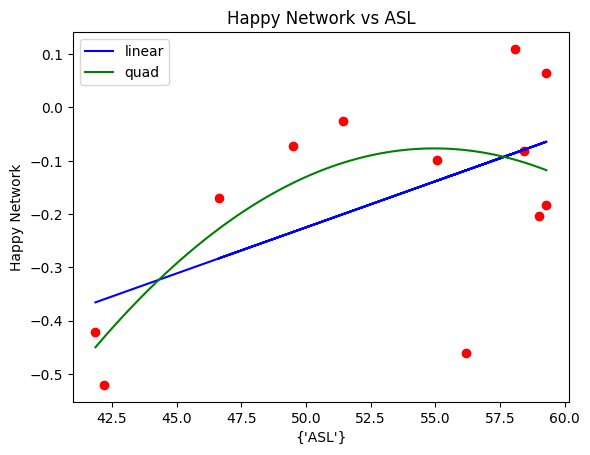

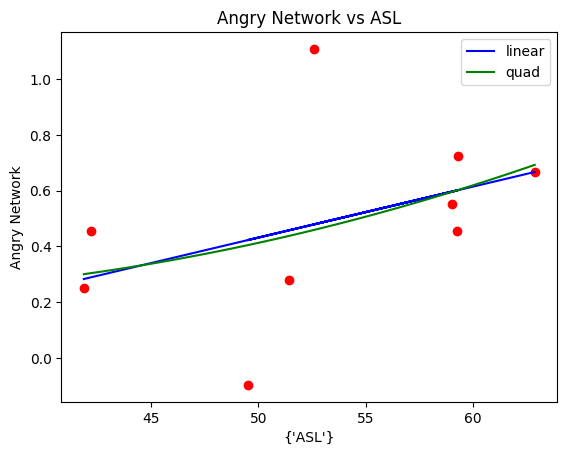

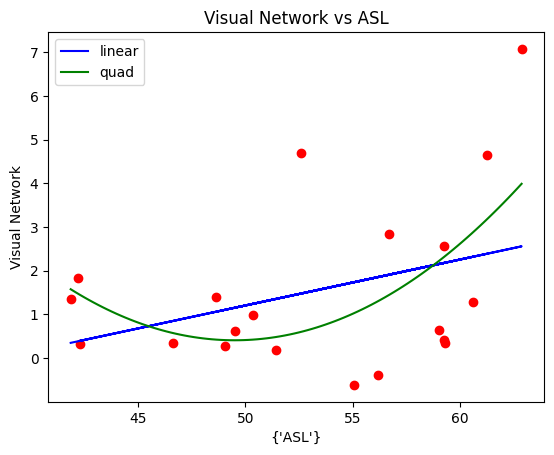

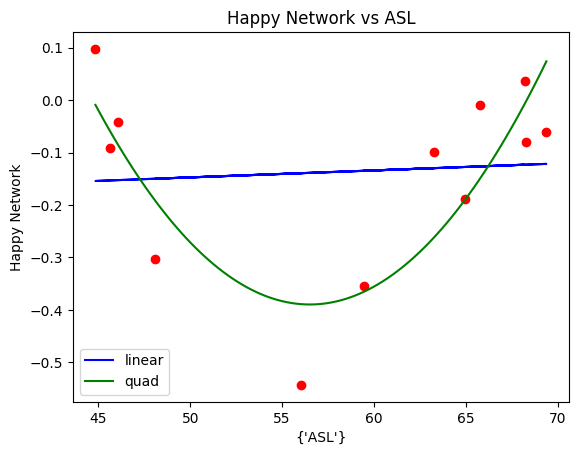

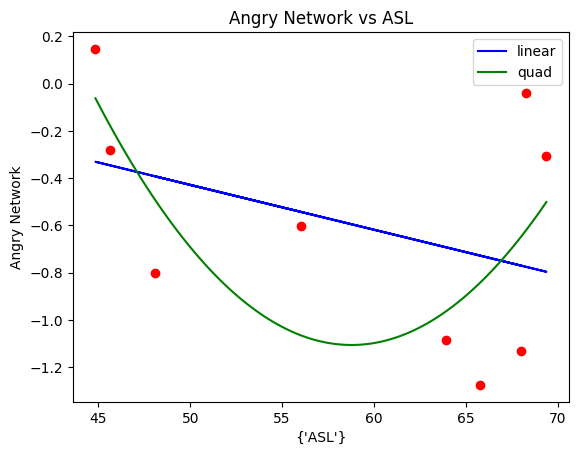

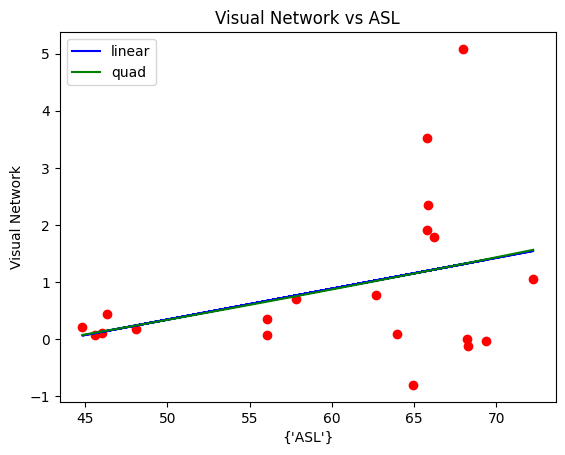

In [127]:
[ASLlinH_int,ASLlinA_int,ASLlinV_int,ASLquadH_int,ASLquadA_int,ASLquadV_int] = ROIs_correlations(neurowASL_interictal,"ses-interictal", "ASL")

[ASLlinH_preict,ASLlinA_preict,ASLlinV_preict,ASLquadH_preict,ASLquadA_preict,ASLquadV_preict] = ROIs_correlations(neurowASL_preictal,'ses-preictal', "ASL")

[ASLlinH_ict,ASLlinA_ict,ASLlinV_ict,ASLquadH_ict,ASLquadA_ict,ASLquadV_ict] = ROIs_correlations(neurowASL_ictal,'ses-ictal', "ASL")

[ASLlinH_postict,ASLlinA_postict,ASLlinV_postict,ASLquadH_postict,ASLquadA_postict,ASLquadV_postict] = ROIs_correlations(neurowASL_postictal,'ses-postictal', "ASL")



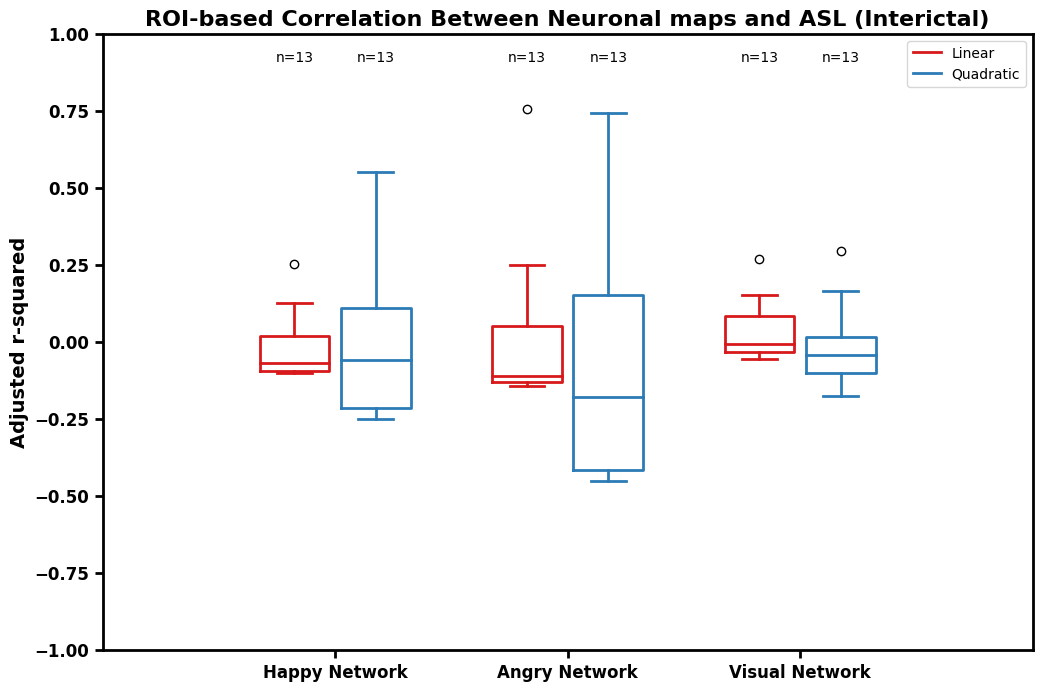

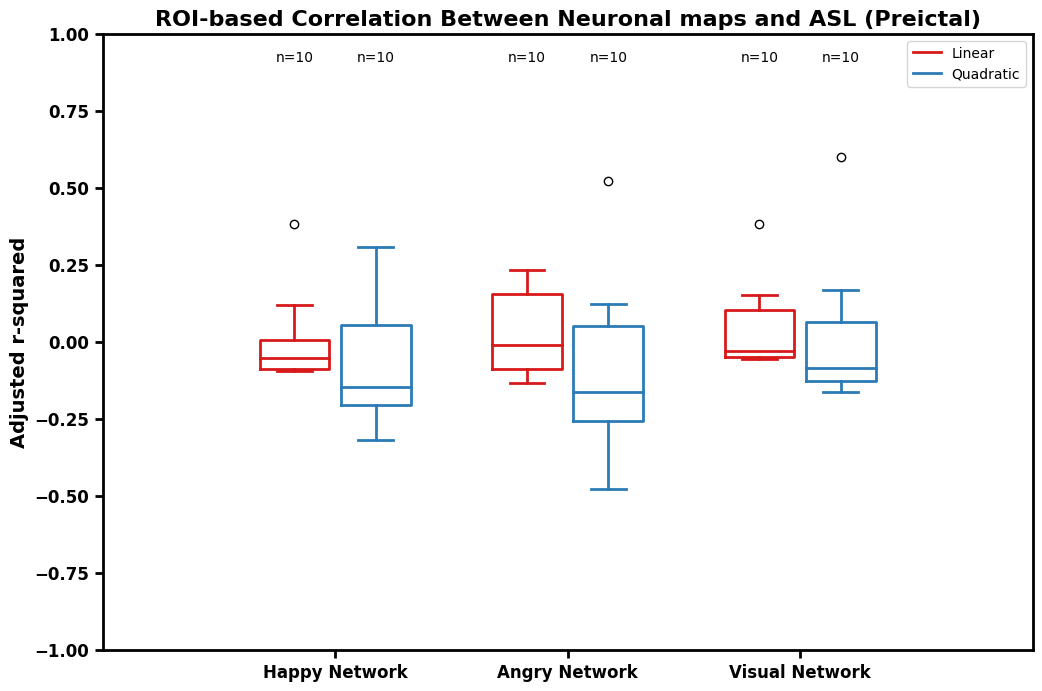

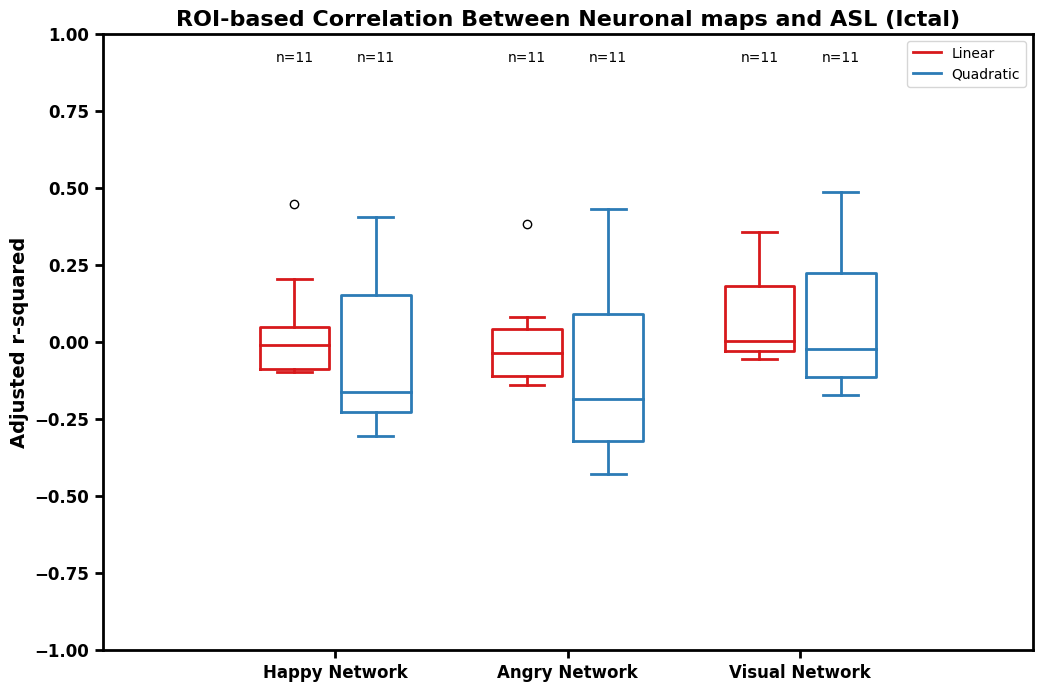

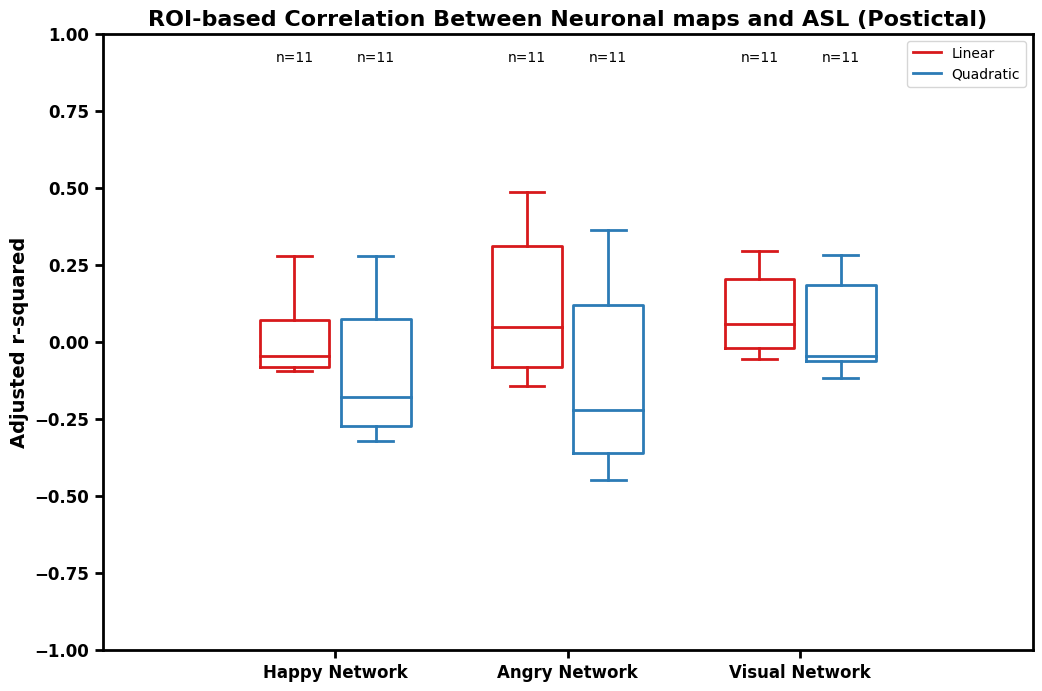

In [128]:
boxplots([ASLlinH_int,ASLlinA_int,ASLlinV_int],[ASLquadH_int,ASLquadA_int,ASLquadV_int],"Interictal","ASL")
boxplots([ASLlinH_preict,ASLlinA_preict,ASLlinV_preict],[ASLquadH_preict,ASLquadA_preict,ASLquadV_preict],"Preictal","ASL")
boxplots([ASLlinH_ict,ASLlinA_ict,ASLlinV_ict],[ASLquadH_ict,ASLquadA_ict,ASLquadV_ict],"Ictal","ASL")
boxplots([ASLlinH_postict,ASLlinA_postict,ASLlinV_postict],[ASLquadH_postict,ASLquadA_postict,ASLquadV_postict],"Postictal","ASL")

### Polynomial

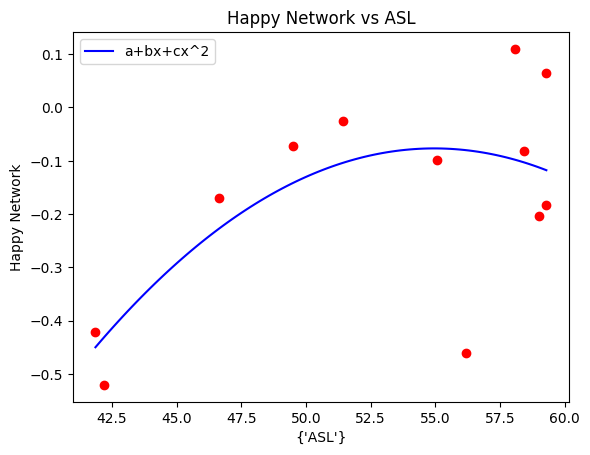

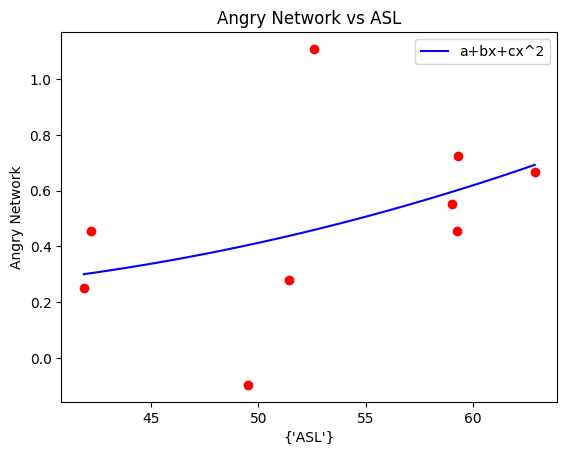

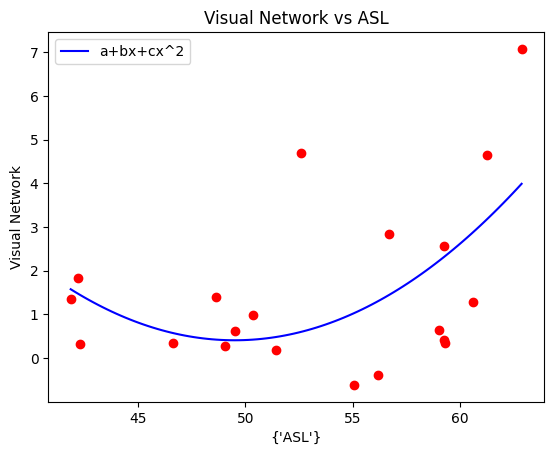

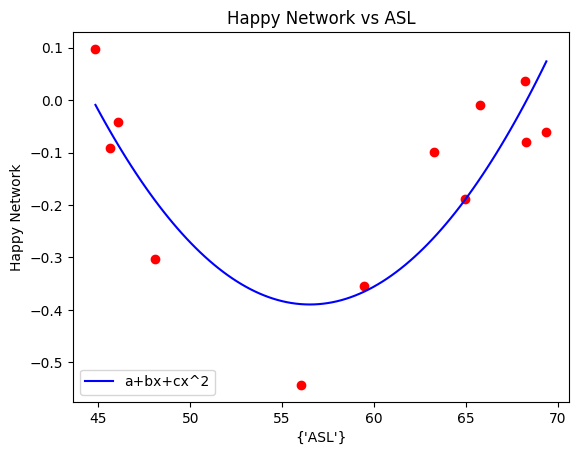

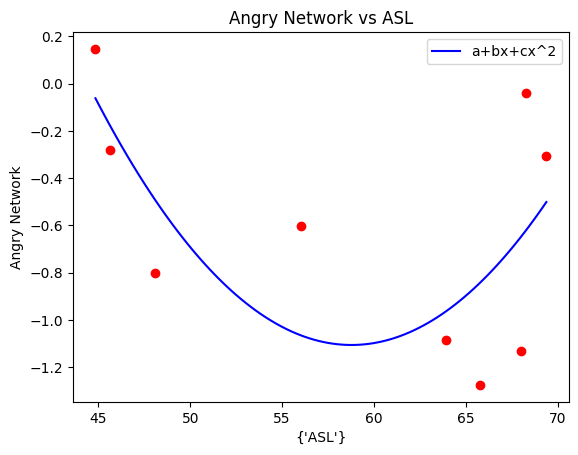

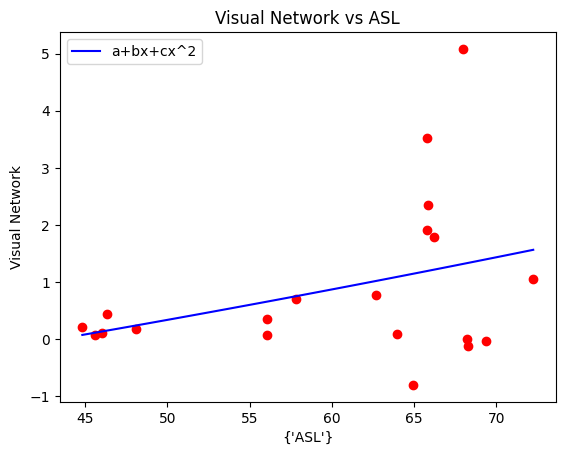

In [129]:
[ASLpolyr2happy_int,ASLpolyr2angry_int,ASLpolyr2vis_int] = ROIs_correlations_poly(neurowASL_interictal,"ses-interictal","ASL")
[ASLpolyr2happy_preict,ASLpolyr2angry_preict,ASLpolyr2vis_preict] = ROIs_correlations_poly(neurowASL_preictal,"ses-preictal","ASL")
[ASLpolyr2happy_ict,ASL_polyr2angry_ict, ASL_polyr2vis_ict] = ROIs_correlations_poly(neurowASL_ictal,"ses-ictal","ASL")
[ASLpolyr2happy_postict,ASpolyr2angry_postict,ASLpolyr2vis_postict] = ROIs_correlations_poly(neurowASL_postictal,"ses-postictal","ASL")

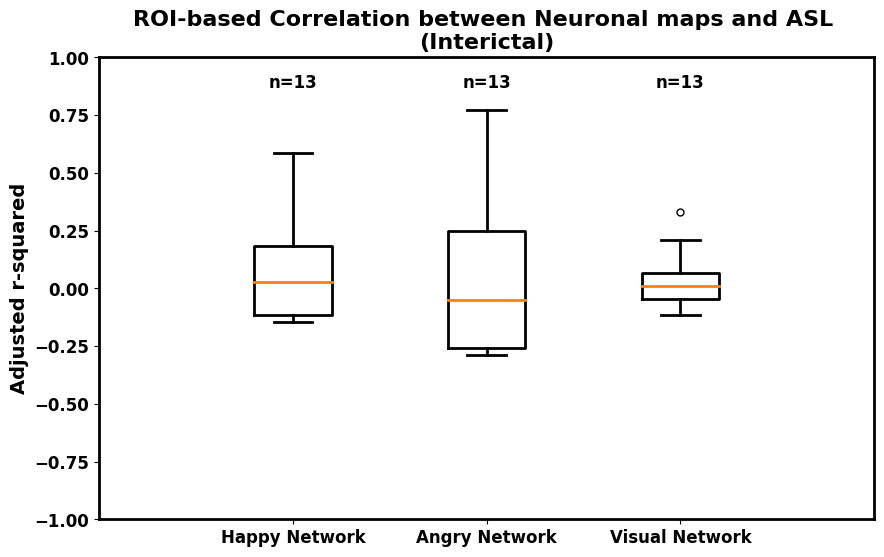

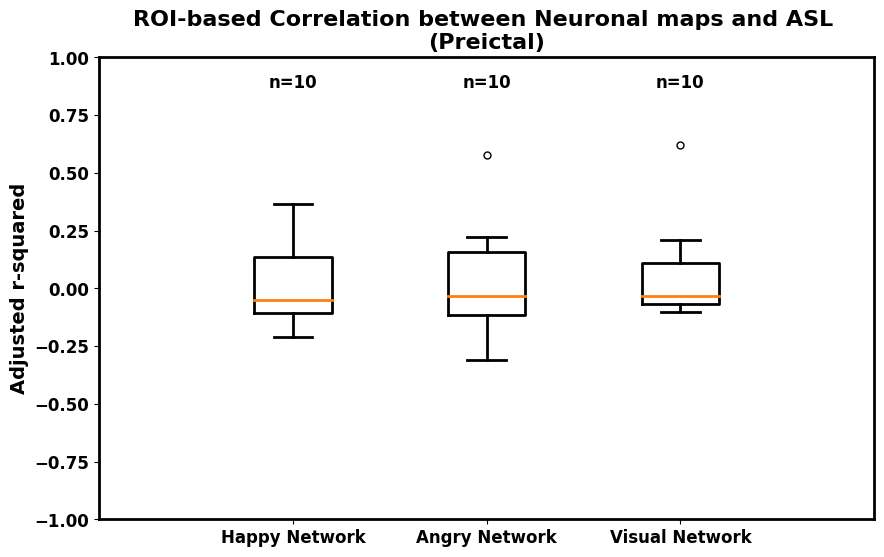

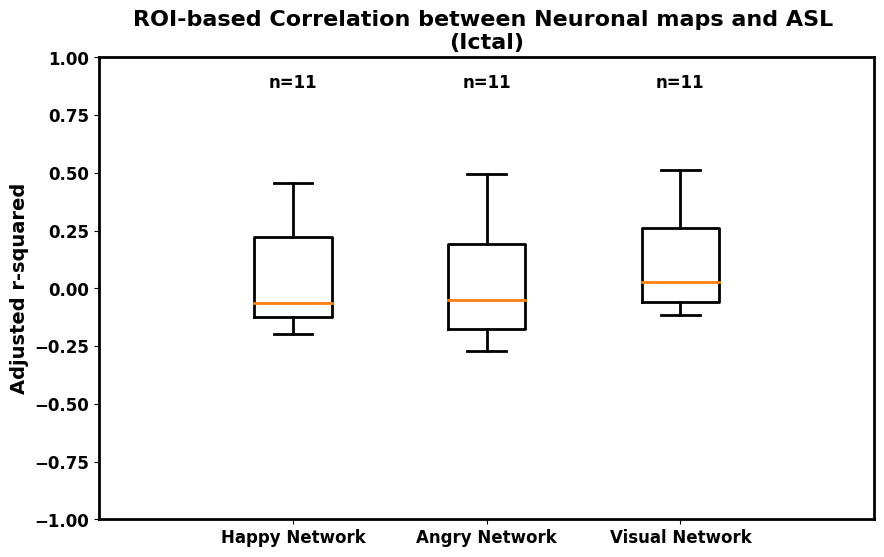

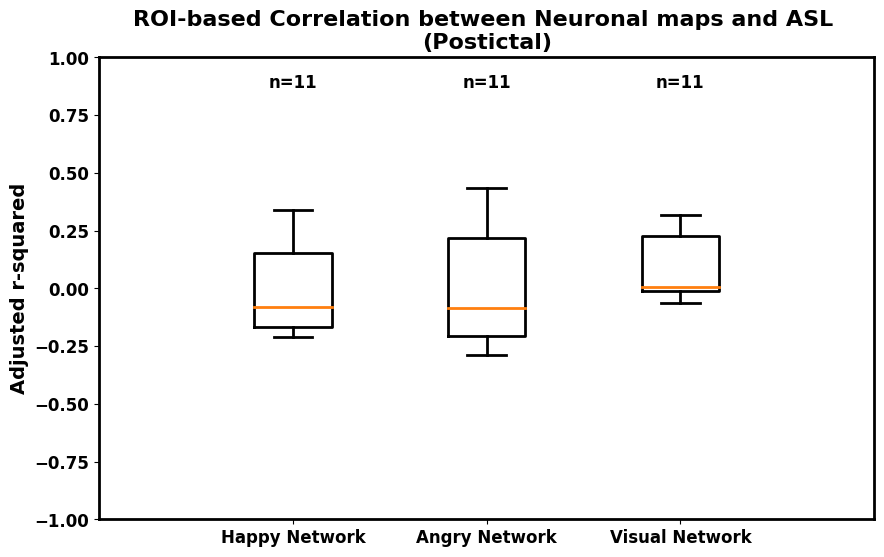

In [150]:
boxplots_poly([ASLpolyr2happy_int,ASLpolyr2angry_int,ASLpolyr2vis_int],"Interictal","ASL")
boxplots_poly([ASLpolyr2happy_preict,ASLpolyr2angry_preict,ASLpolyr2vis_preict],"Preictal","ASL")
boxplots_poly([ASLpolyr2happy_ict,ASL_polyr2angry_ict, ASL_polyr2vis_ict],"Ictal","ASL")
boxplots_poly([ASLpolyr2happy_postict,ASpolyr2angry_postict,ASLpolyr2vis_postict],"Postictal","ASL")

## CVR

### Linear and Quadratic

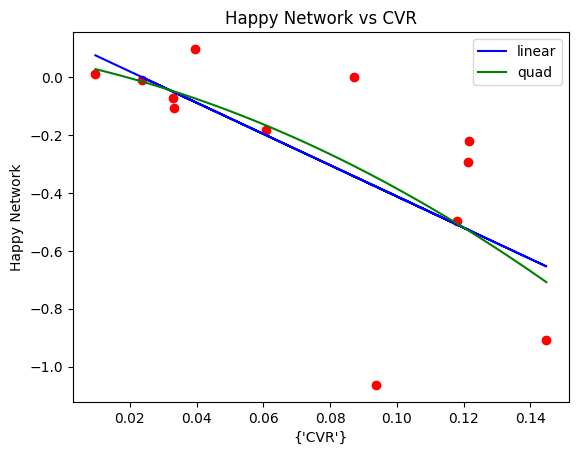

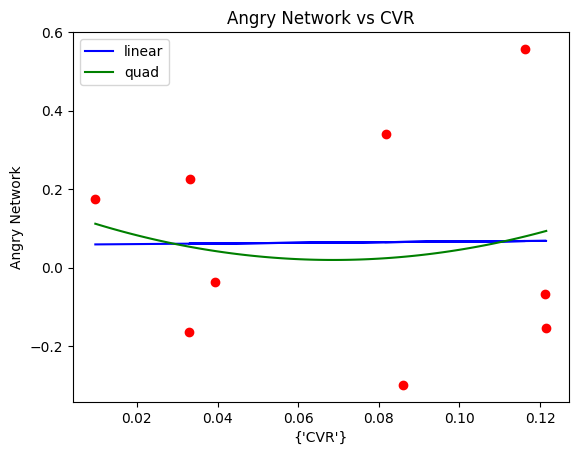

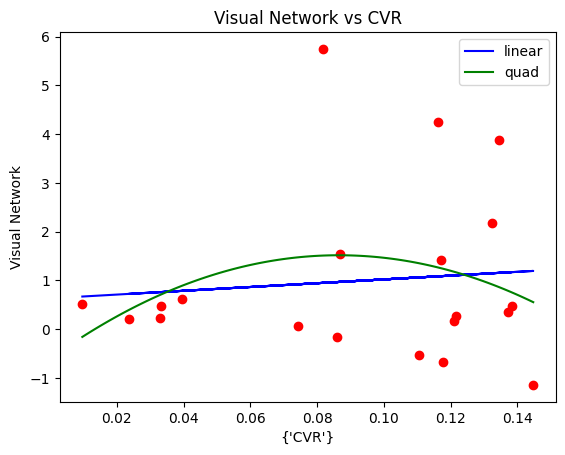

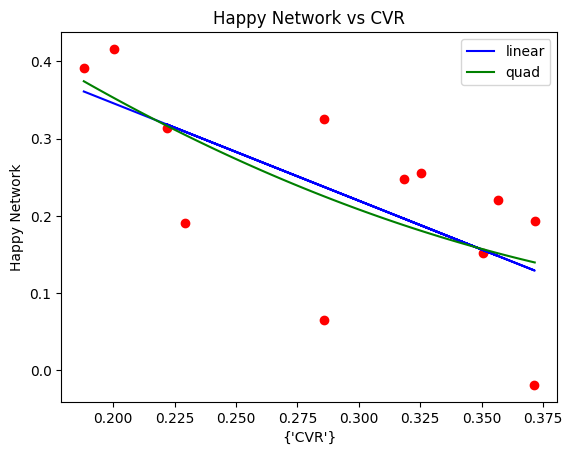

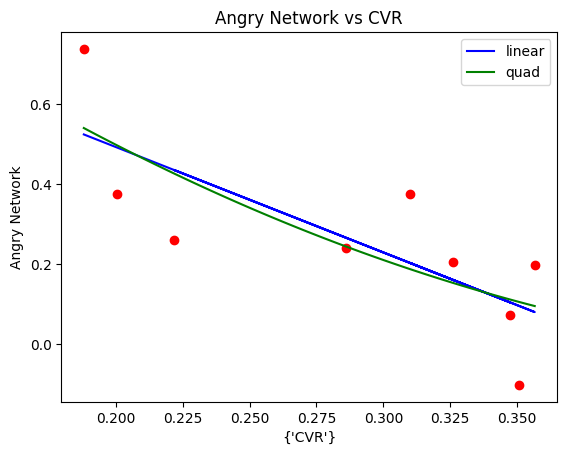

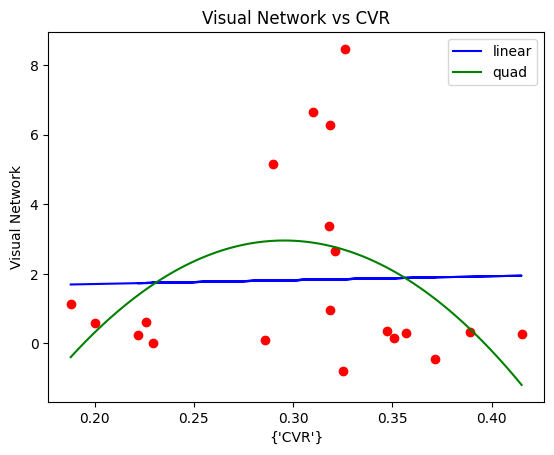

In [131]:
# CVR correlations

# interictal

[CVRlinH_int,CVRlinA_int,CVRlinV_int,CVRquadH_int,CVRquadA_int,CVRquadV_int] = ROIs_correlations(neurowCVR_interictal,"ses-interictal","CVR")

# preictal

[CVRlinH_preict,CVRlinA_preict,CVRlinV_preict,CVRquadH_preict,CVRquadA_preict,CVRquadV_preict] = ROIs_correlations(neurowCVR_preictal,"ses-preictal","CVR")

# ictal 

[CVRlinH_ict,CVRlinA_ict,CVRlinV_ict,CVRquadH_ict,CVRquadA_ict,CVRquadV_ict] = ROIs_correlations(neurowCVR_ictal,"ses-ictal","CVR")

# postictal

[CVRlinH_postict,CVRlinA_postict,CVRlinV_postict,CVRquadH_postict,CVRquadA_postict,CVRquadV_postict] = ROIs_correlations(neurowCVR_postictal,"ses-postictal","CVR")

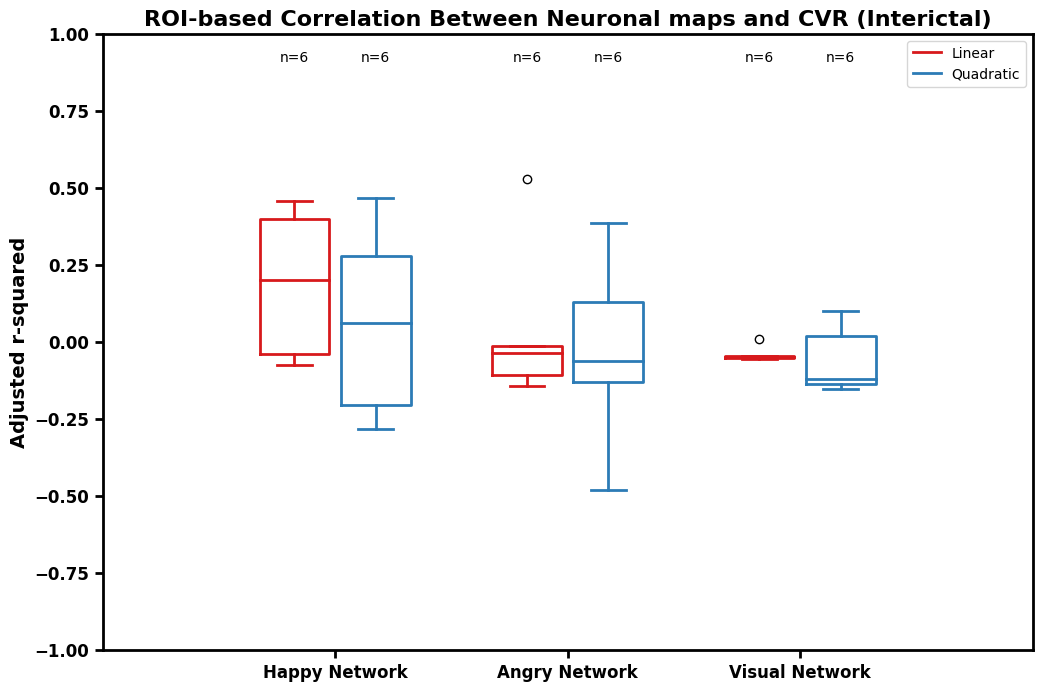

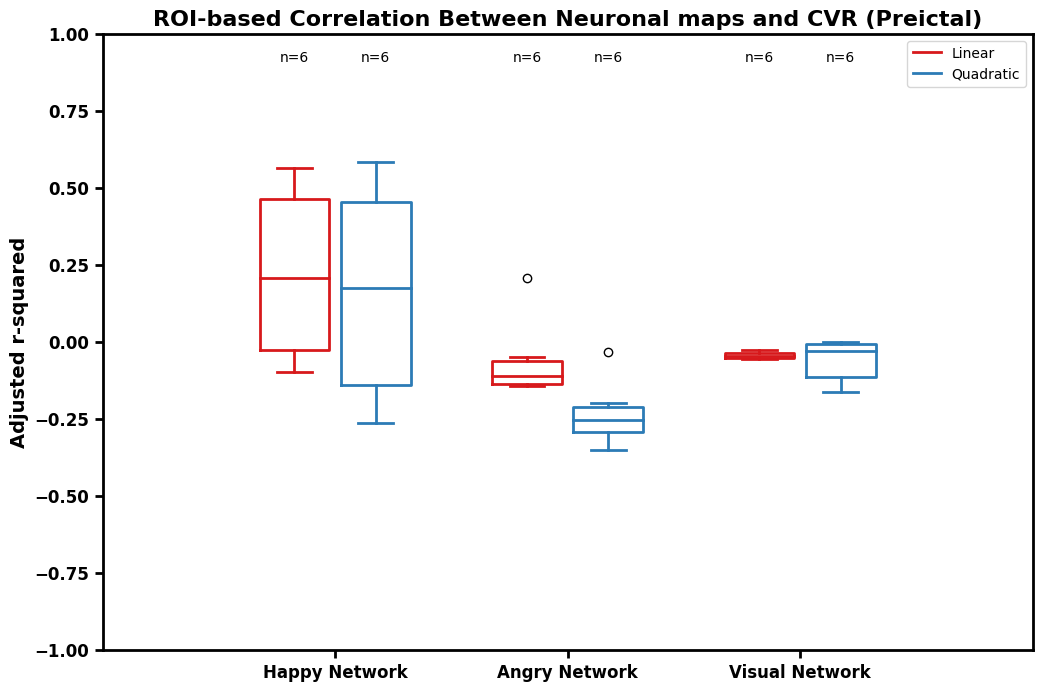

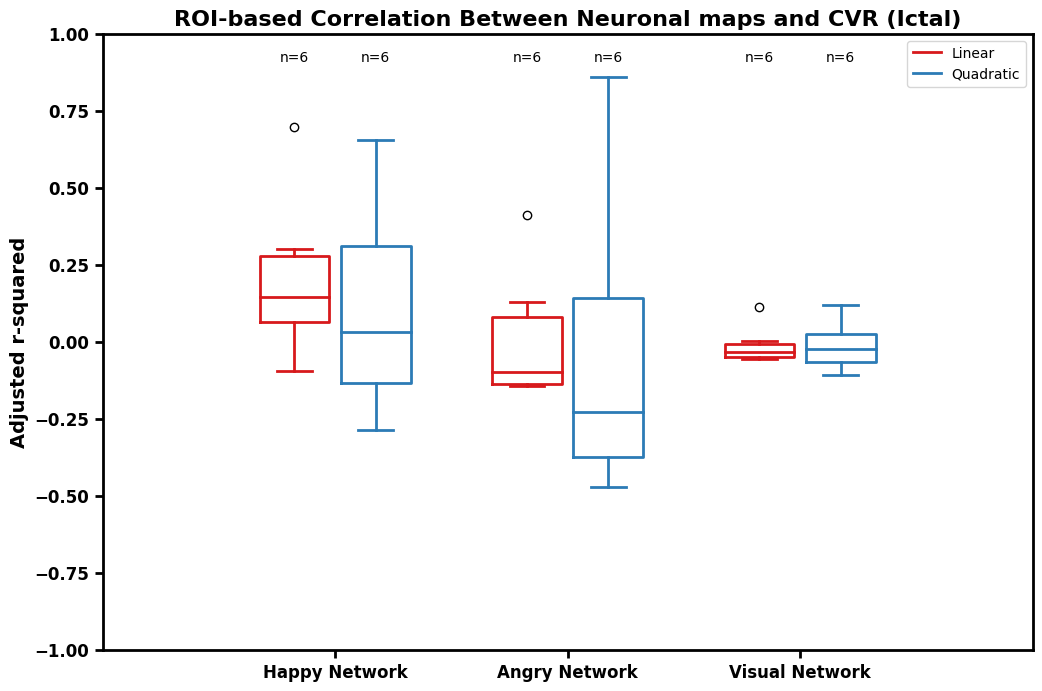

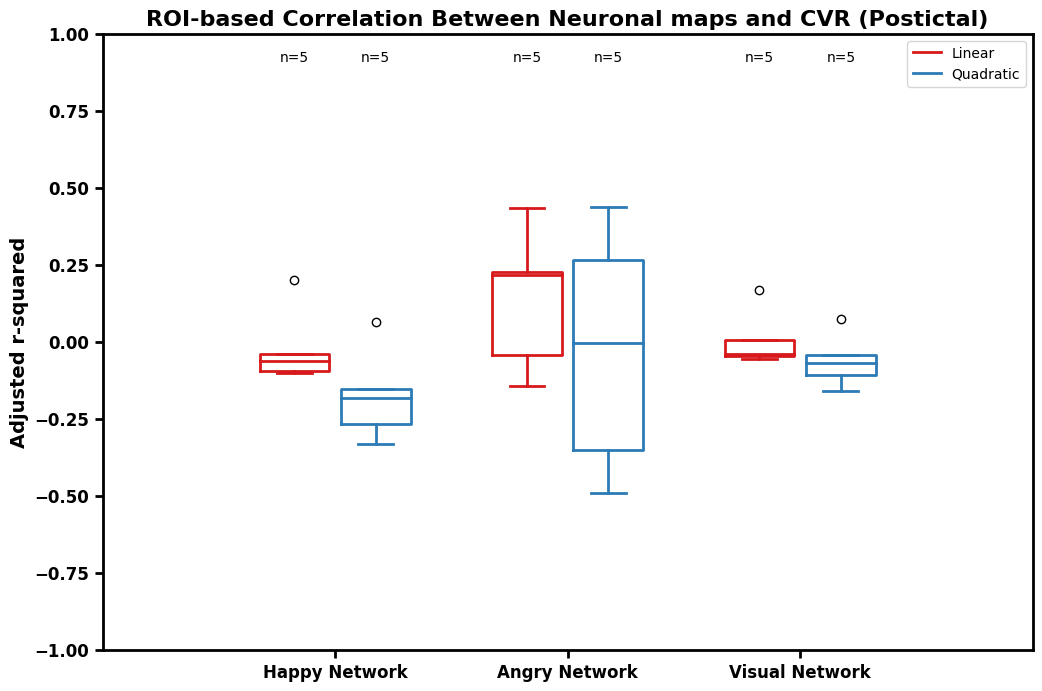

In [132]:
boxplots([CVRlinH_int,CVRlinA_int,CVRlinV_int],[CVRquadH_int,CVRquadA_int,CVRquadV_int],"Interictal","CVR")
boxplots([CVRlinH_preict,CVRlinA_preict,CVRlinV_preict],[CVRquadH_preict,CVRquadA_preict,CVRquadV_preict],"Preictal","CVR")
boxplots([CVRlinH_ict,CVRlinA_ict,CVRlinV_ict],[CVRquadH_ict,CVRquadA_ict,CVRquadV_ict],"Ictal","CVR")
boxplots([CVRlinH_postict,CVRlinA_postict,CVRlinV_postict],[CVRquadH_postict,CVRquadA_postict,CVRquadV_postict],"Postictal","CVR")

### Polynomial

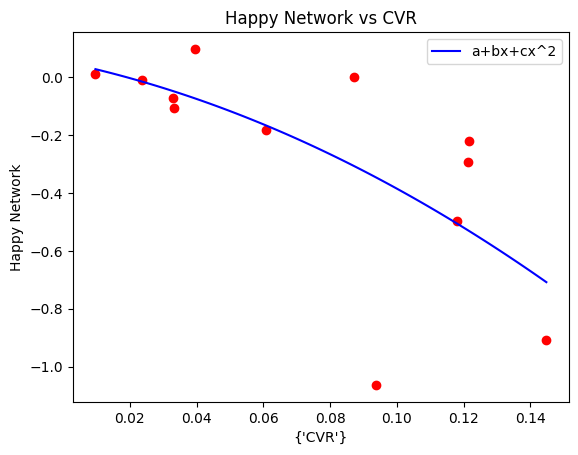

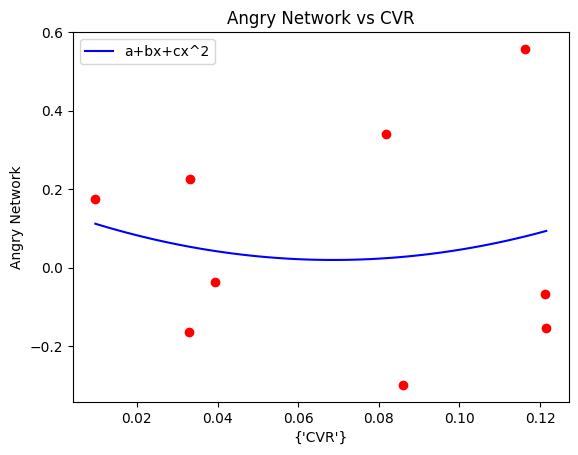

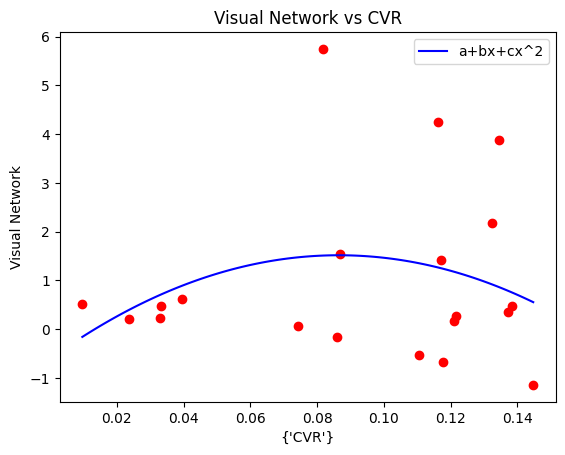

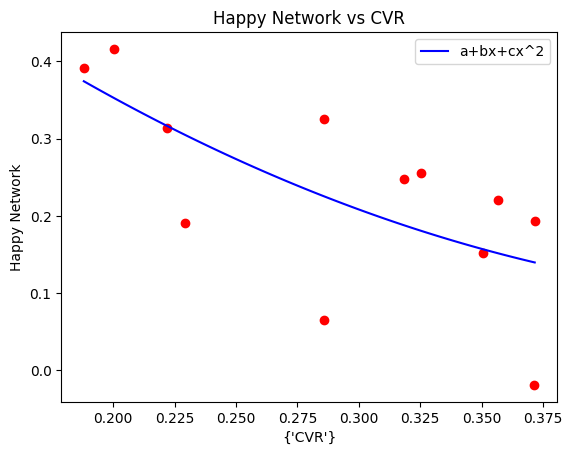

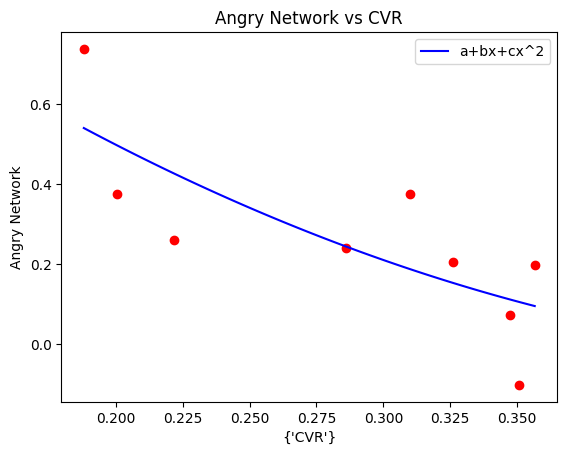

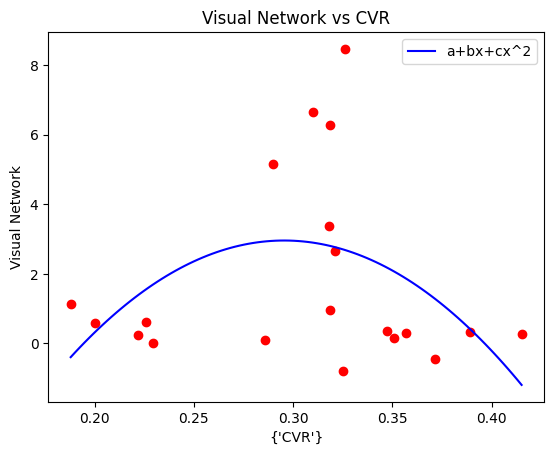

In [133]:
[CVRpolyr2happy_int,CVRpolyr2angry_int,CVRpolyr2vis_int] = ROIs_correlations_poly(neurowCVR_interictal,"ses-interictal","CVR")
[CVRpolyr2happy_preict,CVRpolyr2angry_preict,CVRpolyr2vis_preict] = ROIs_correlations_poly(neurowCVR_preictal,"ses-preictal","CVR")
[CVRpolyr2happy_ict,CVRpolyr2angry_ict, CVRpolyr2vis_ict] = ROIs_correlations_poly(neurowCVR_ictal,"ses-ictal","CVR")
[CVRpolyr2happy_postict,CVRpolyr2angry_postict,CVRpolyr2vis_postict] = ROIs_correlations_poly(neurowCVR_postictal,"ses-postictal","CVR")

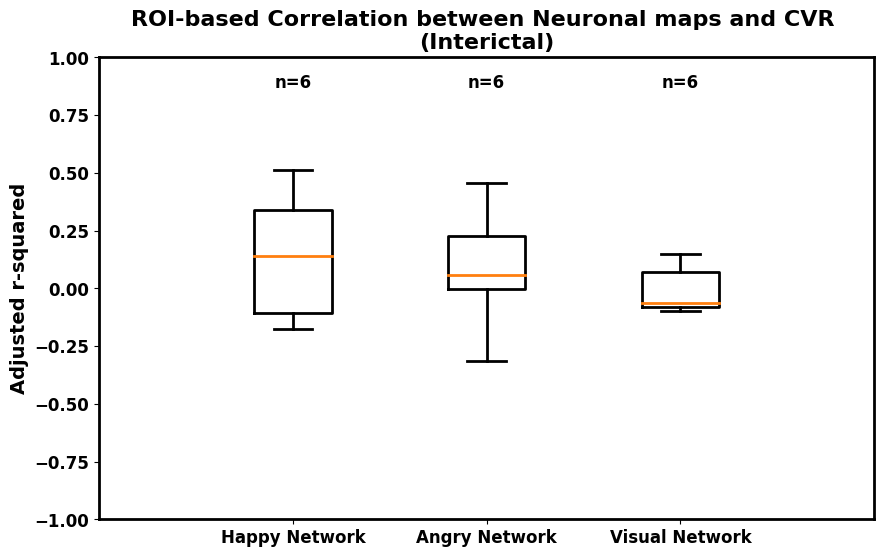

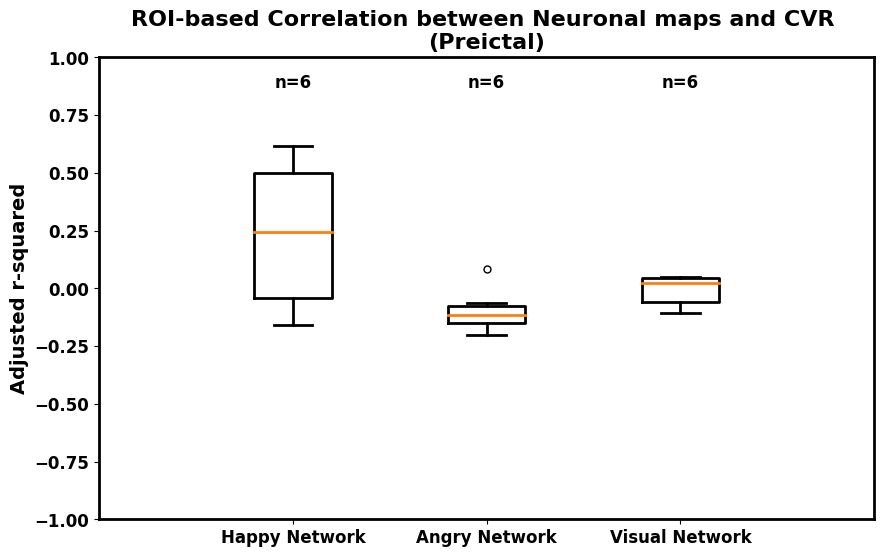

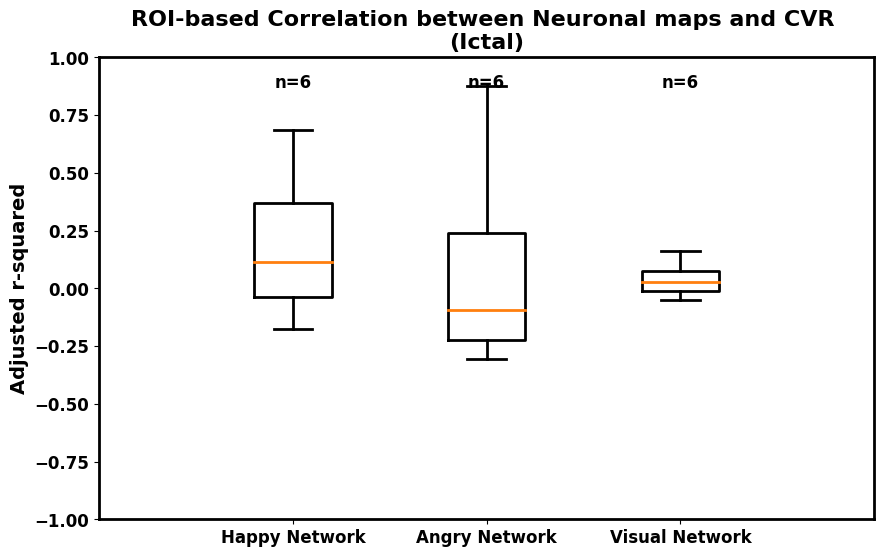

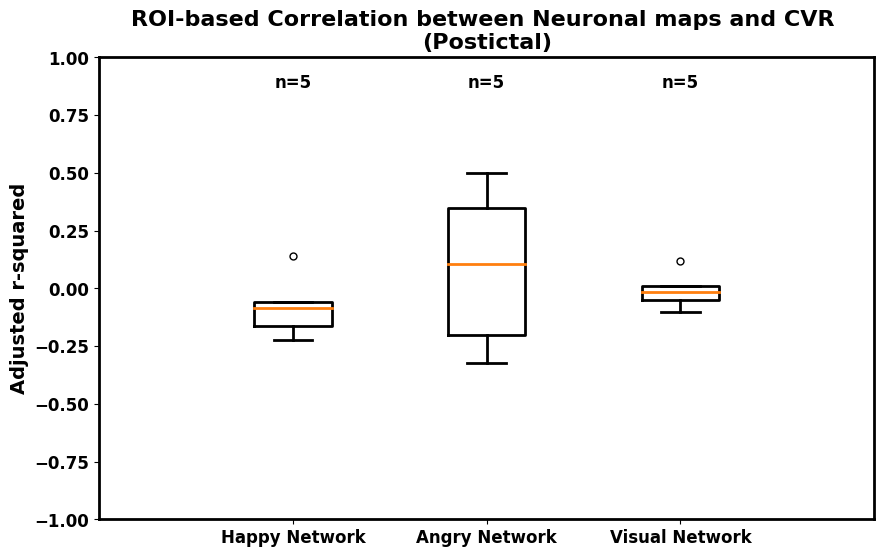

In [155]:
boxplots_poly([CVRpolyr2happy_int,CVRpolyr2angry_int,CVRpolyr2vis_int],"Interictal","CVR")
boxplots_poly([CVRpolyr2happy_preict,CVRpolyr2angry_preict,CVRpolyr2vis_preict],"Preictal","CVR")
boxplots_poly([CVRpolyr2happy_ict,CVRpolyr2angry_ict, CVRpolyr2vis_ict],"Ictal","CVR")
boxplots_poly([CVRpolyr2happy_postict,CVRpolyr2angry_postict,CVRpolyr2vis_postict],"Postictal","CVR")

# Controls Results

## ASL

### Linear and Quadratic

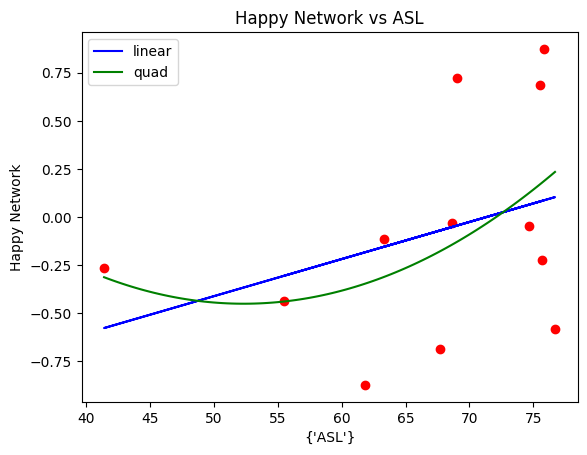

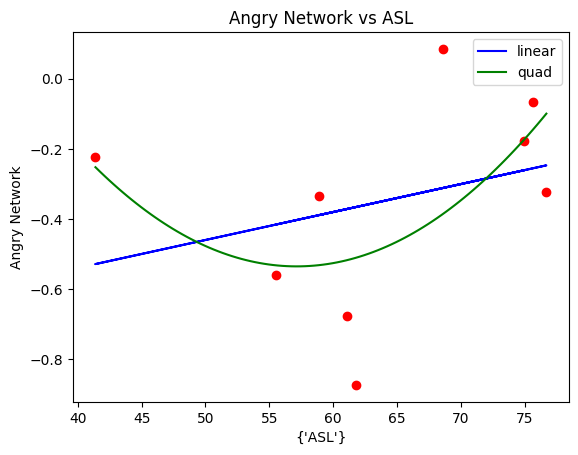

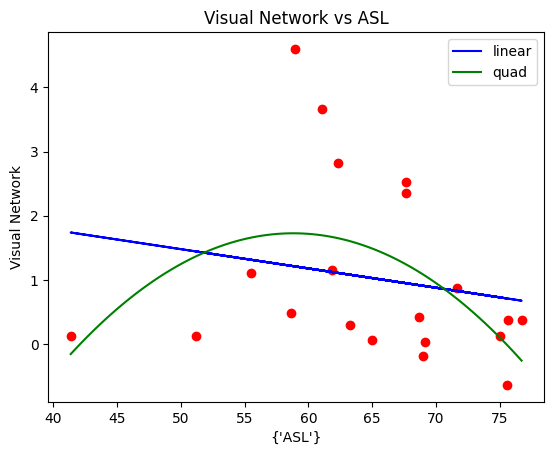

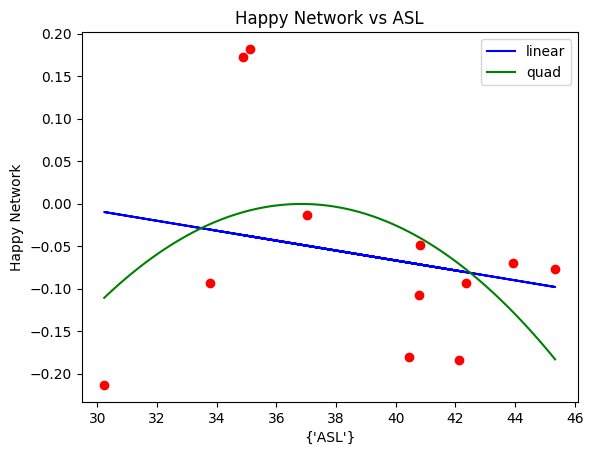

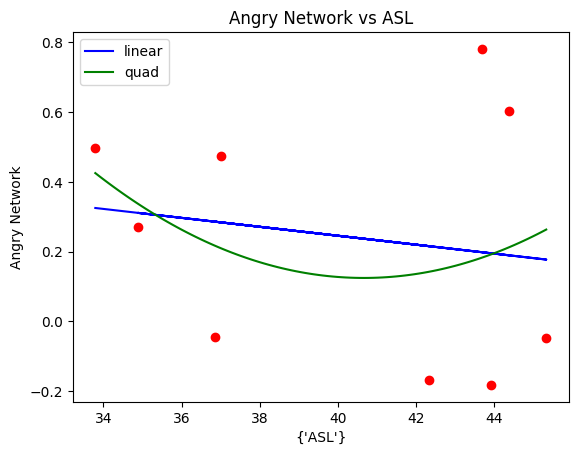

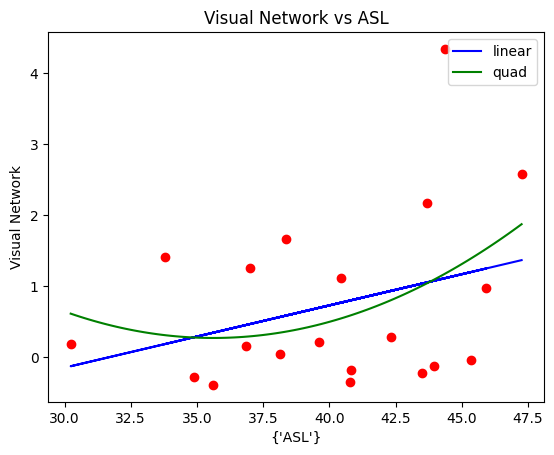

In [135]:
[ASLlinH_mid,ASLlinA_mid,ASLlinV_mid,ASLquadH_mid,ASLquadA_mid,ASLquadV_mid] = ROIs_correlations(neurowASL_midcycle,"ses-midcycle","ASL")
[ASLlinH_premens,ASLlinA_premens,ASLlinV_premens,ASLquadH_premens,ASLquadA_premens,ASLquadV_premens] = ROIs_correlations(neurowASL_premens,"ses-premenstrual", "ASL")

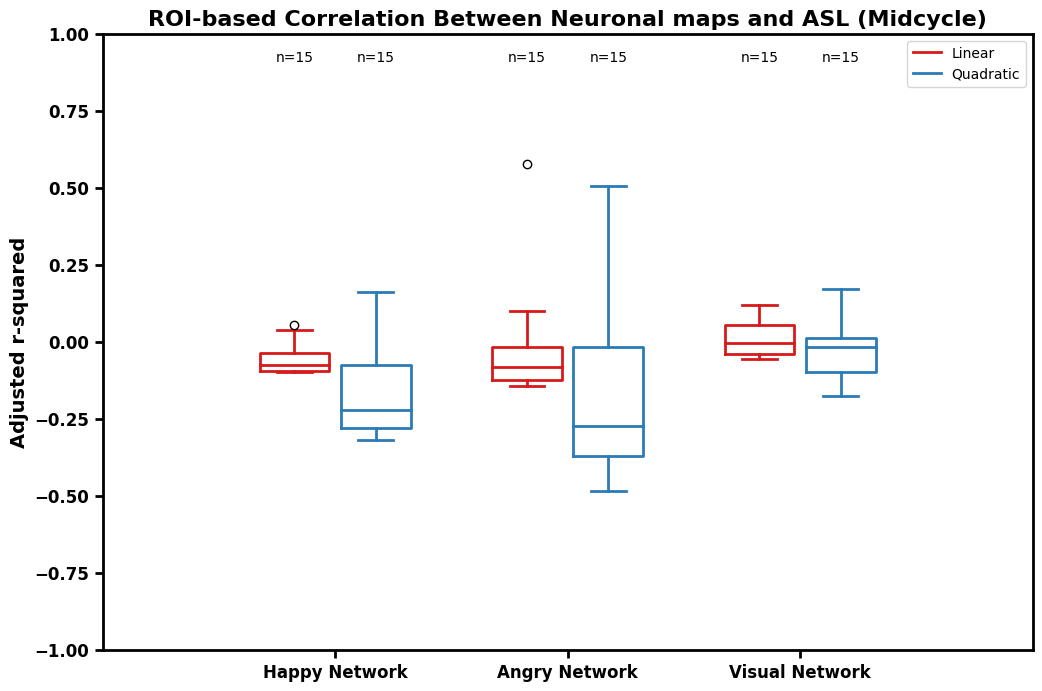

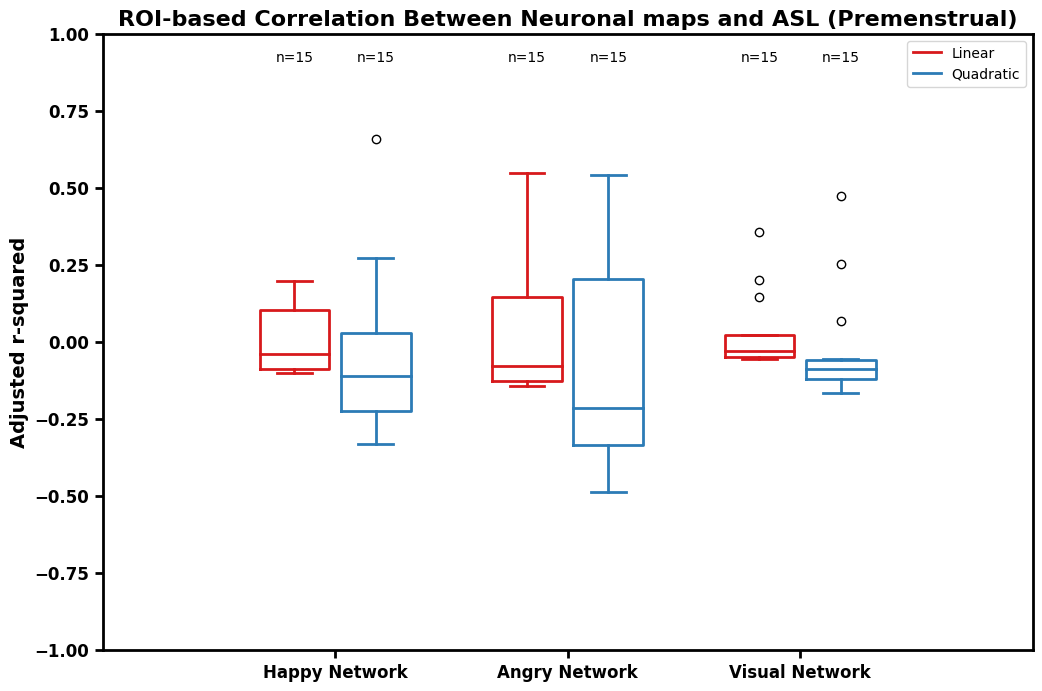

In [136]:
boxplots([ASLlinH_mid,ASLlinA_mid,ASLlinV_mid],[ASLquadH_mid,ASLquadA_mid,ASLquadV_mid],"Midcycle","ASL")
boxplots([ASLlinH_premens,ASLlinA_premens,ASLlinV_premens],[ASLquadH_premens,ASLquadA_premens,ASLquadV_premens],"Premenstrual","ASL")

### Polynomial

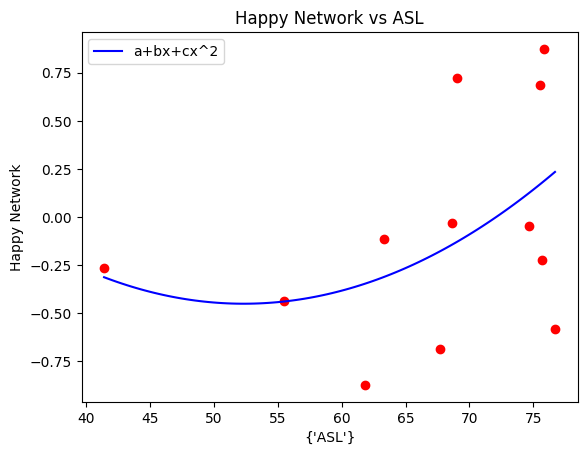

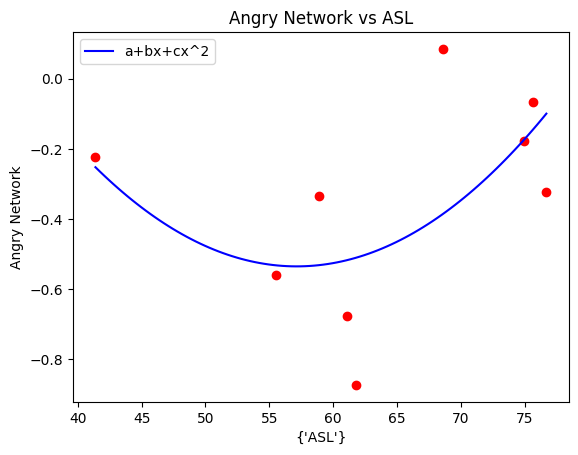

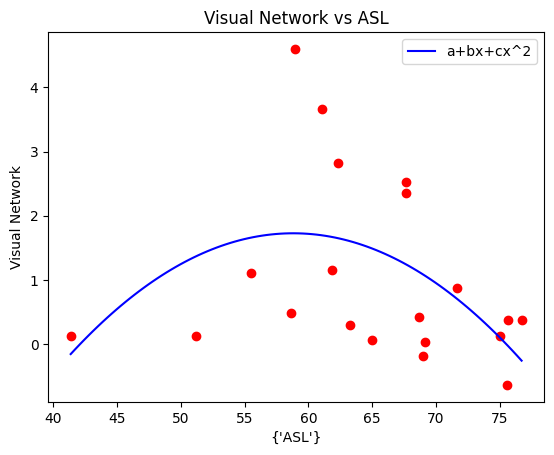

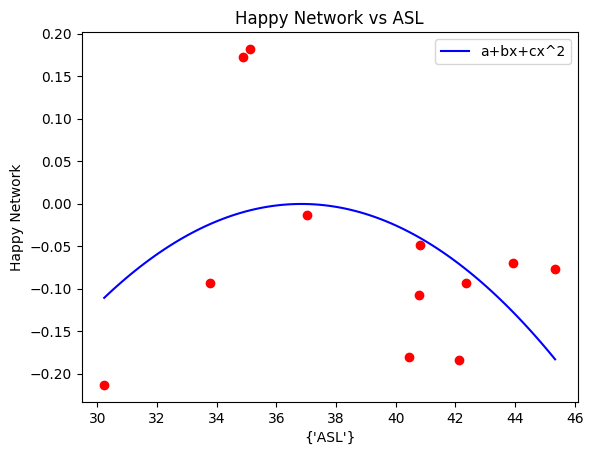

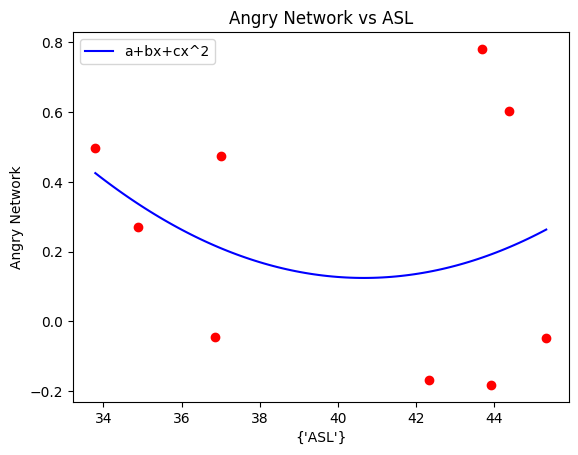

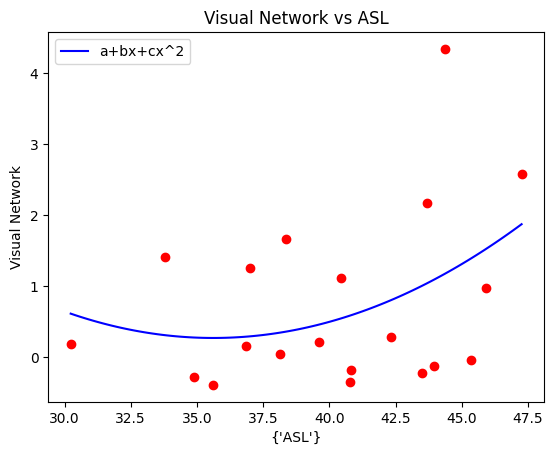

In [137]:


[ASLpolyr2happy_midcycle, ASLpolyr2angry_midcycle, ASLpolyr2vis_midcycle] = ROIs_correlations_poly(neurowASL_midcycle,"ses-midcycle","ASL")
[ASLpolyr2happy_premens, ASLpolyr2angry_premens, ASLpolyr2vis_premens] = ROIs_correlations_poly(neurowASL_premens,"ses-premenstrual","ASL")

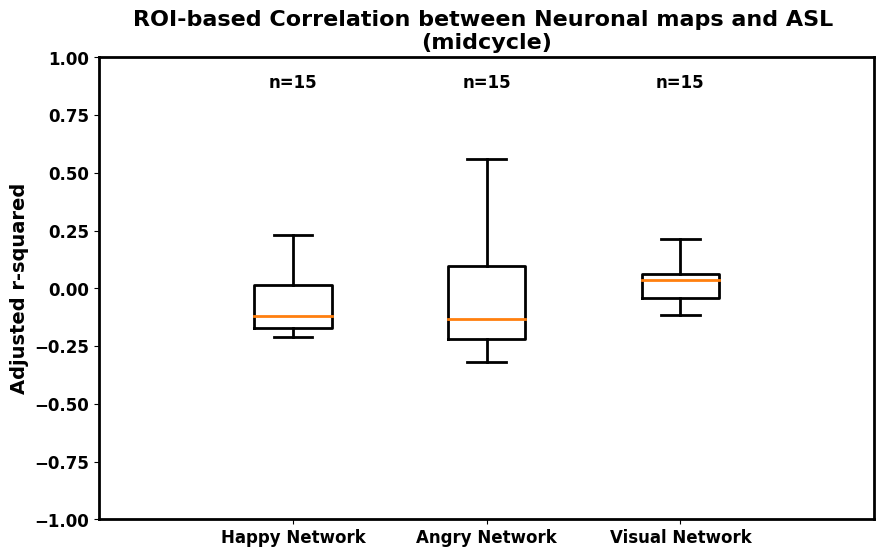

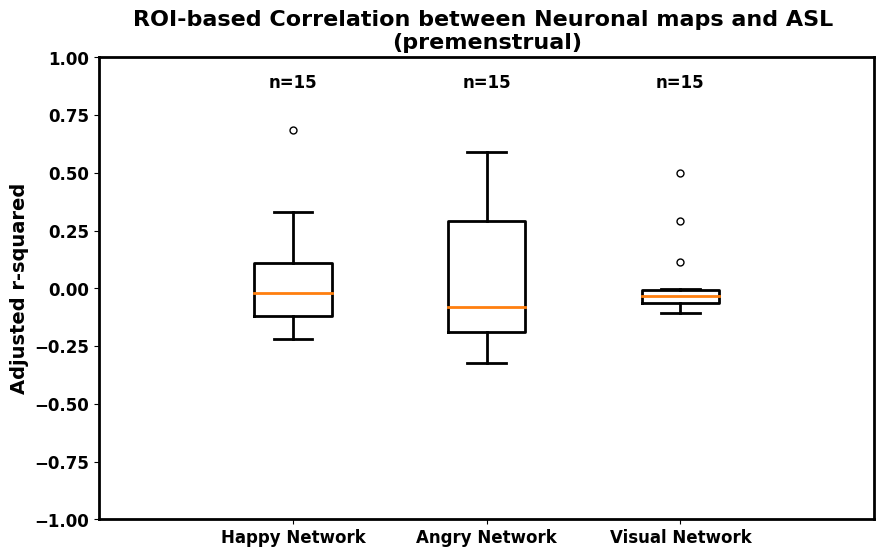

In [152]:
boxplots_poly([ASLpolyr2happy_midcycle,ASLpolyr2angry_midcycle, ASLpolyr2vis_midcycle],"midcycle","ASL")
boxplots_poly([ASLpolyr2happy_premens,ASLpolyr2angry_premens, ASLpolyr2vis_premens],"premenstrual","ASL")

## CVR

### Linear and Quadratic

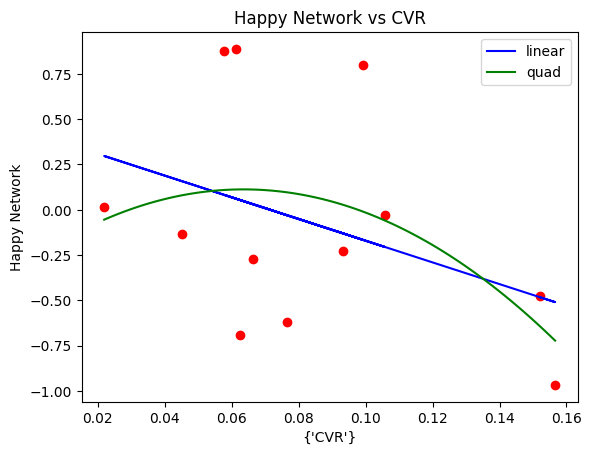

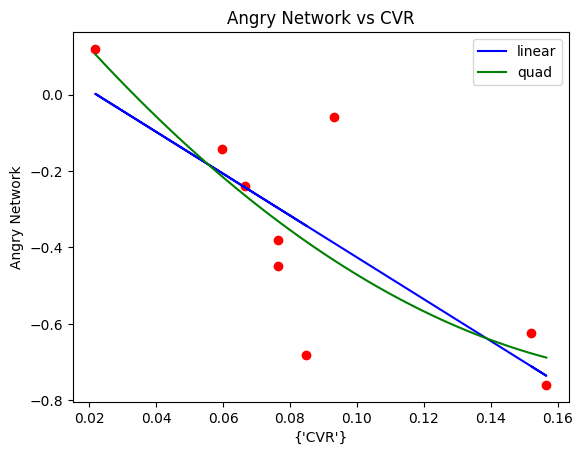

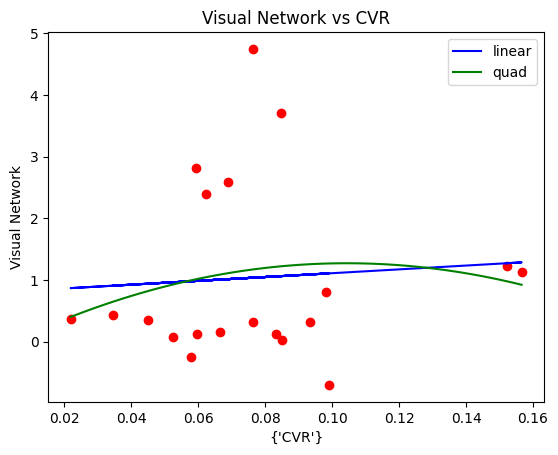

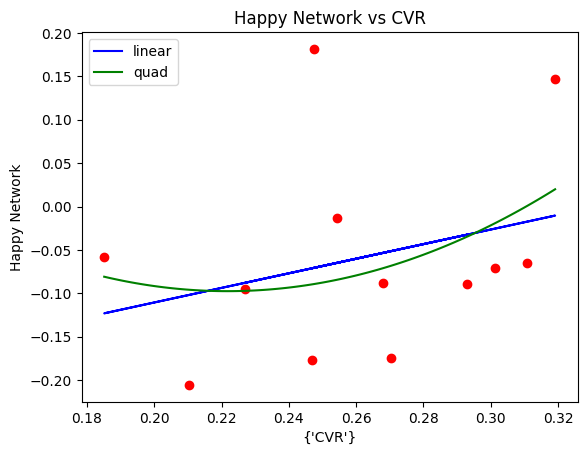

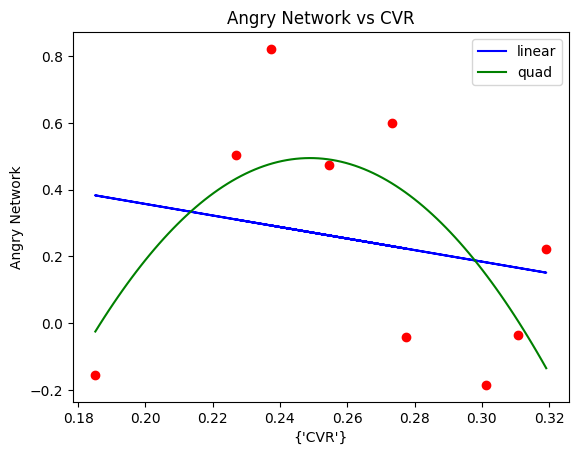

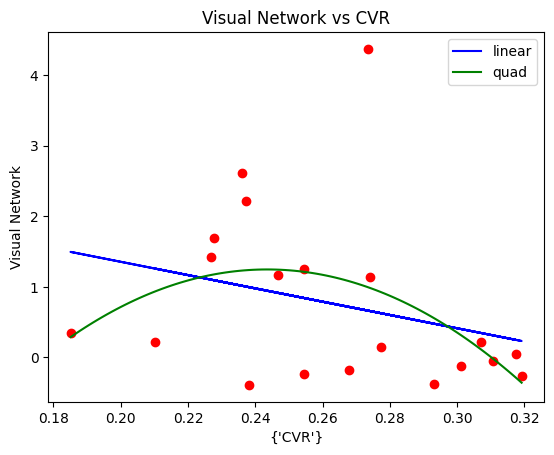

In [139]:
[CVRlinH_mid,CVRlinA_mid,CVRlinV_mid,CVRquadH_mid,CVRquadA_mid,CVRquadV_mid] = ROIs_correlations(neurowCVR_midcycle,"ses-midcycle", "CVR")
[CVRlinH_premens,CVRlinA_premens,CVRlinV_premens,CVRquadH_premens,CVRquadA_premens,CVRquadV_premens] = ROIs_correlations(neurowCVR_premens,"ses-premenstrual", "CVR")


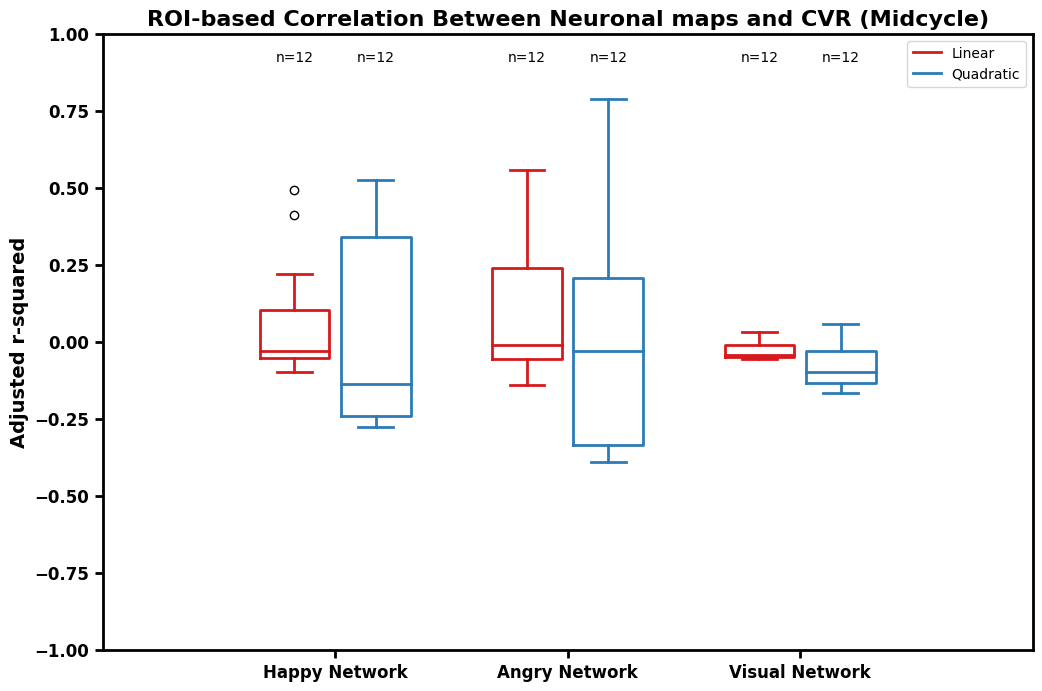

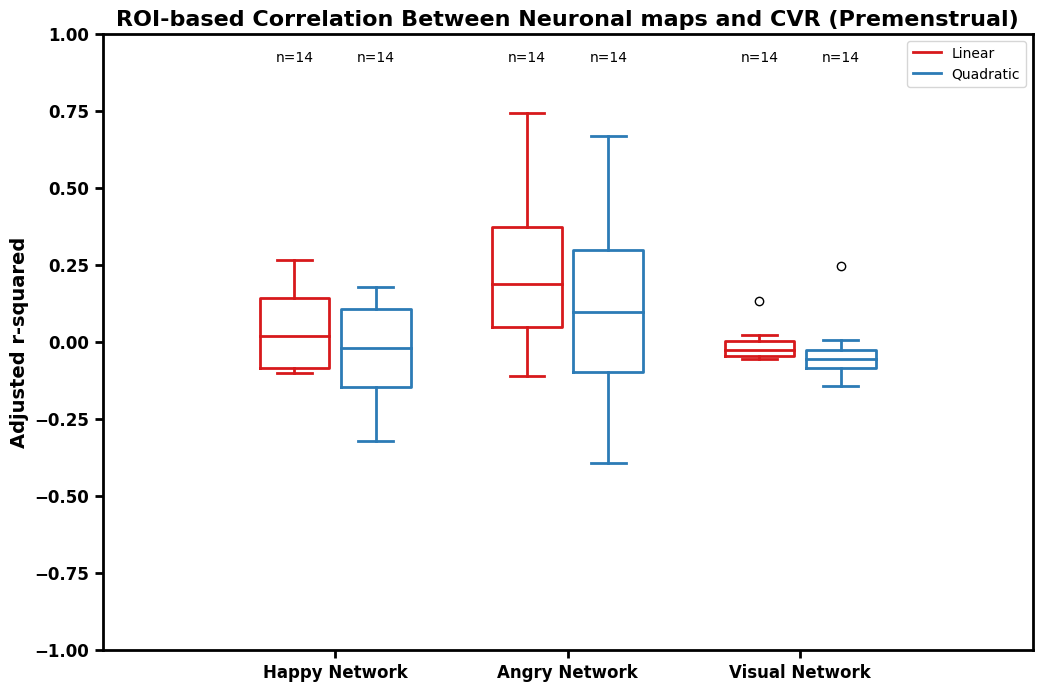

In [140]:
boxplots([CVRlinH_mid,CVRlinA_mid,CVRlinV_mid],[CVRquadH_mid,CVRquadA_mid,CVRquadV_mid],"Midcycle","CVR")
boxplots([CVRlinH_premens,CVRlinA_premens,CVRlinV_premens],[CVRquadH_premens,CVRquadA_premens,CVRquadV_premens],"Premenstrual","CVR")

### Polynomial

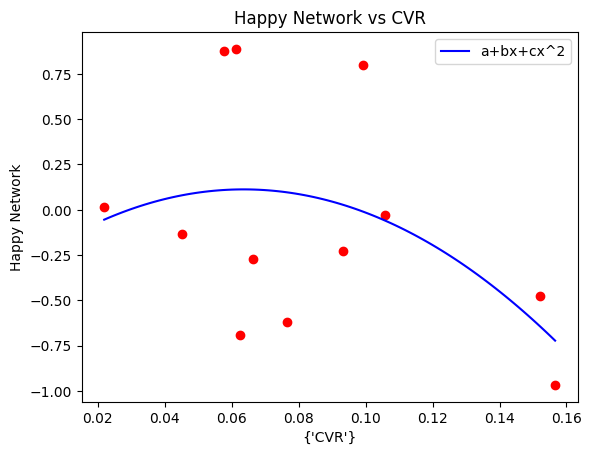

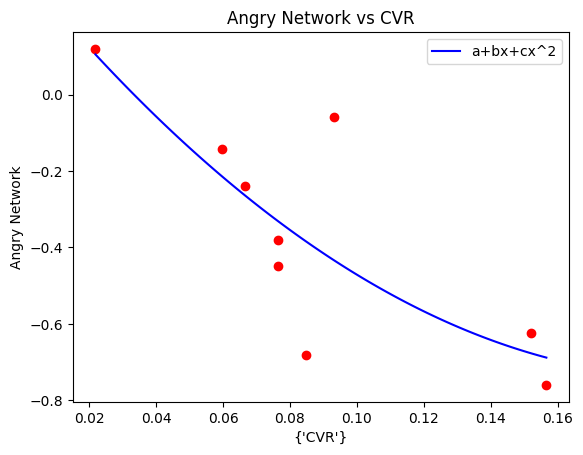

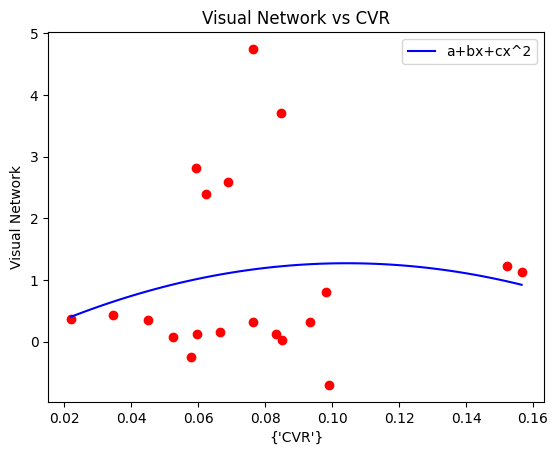

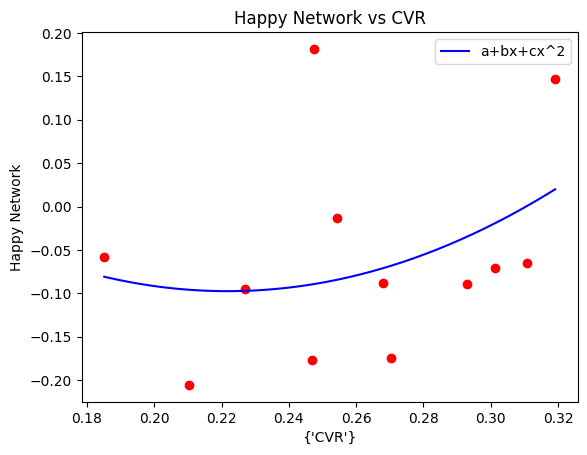

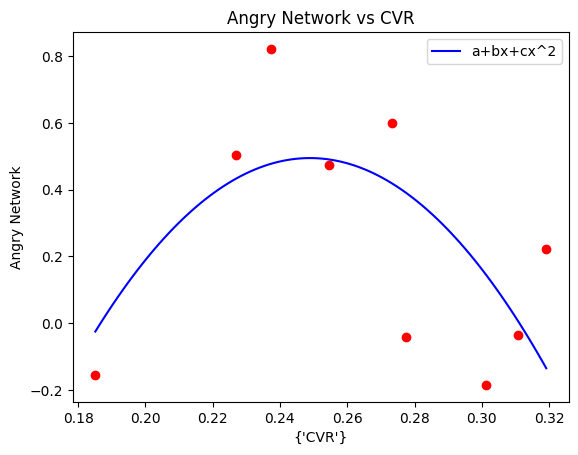

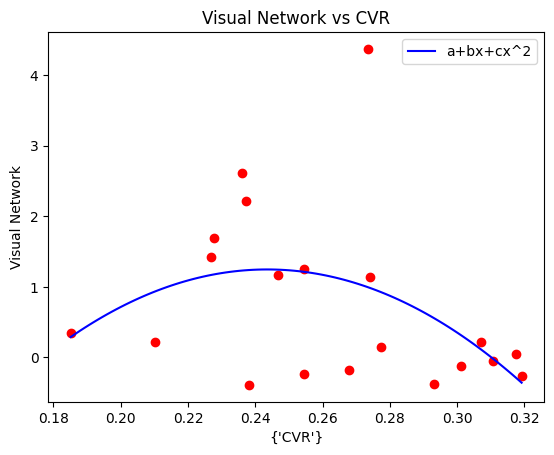

In [141]:
[CVRpolyr2happy_midcycle,CVRpolyr2angry_midcycle, CVRpolyr2vis_midcycle] = ROIs_correlations_poly(neurowCVR_midcycle,"ses-midcycle","CVR")
[CVRpolyr2happy_premens,CVRpolyr2angry_premens, CVRpolyr2vis_premens] = ROIs_correlations_poly(neurowCVR_premens,"ses-premenstrual","CVR")

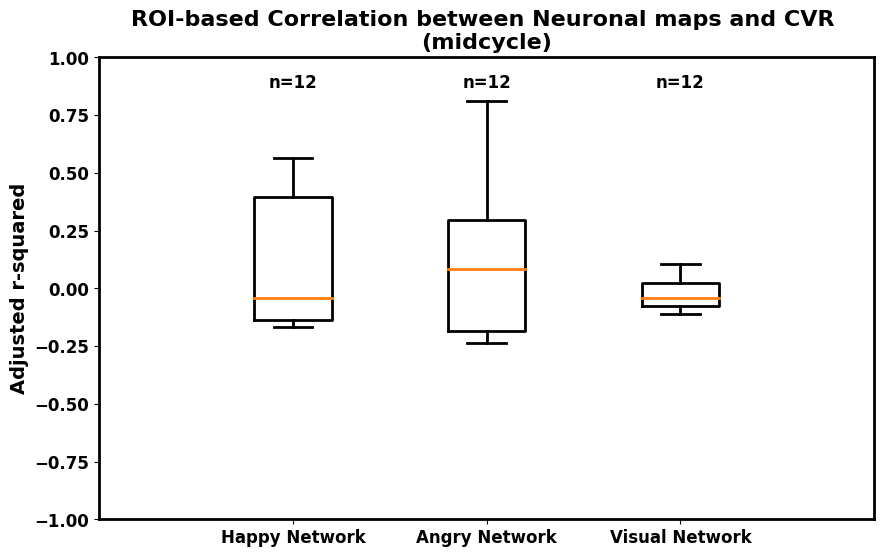

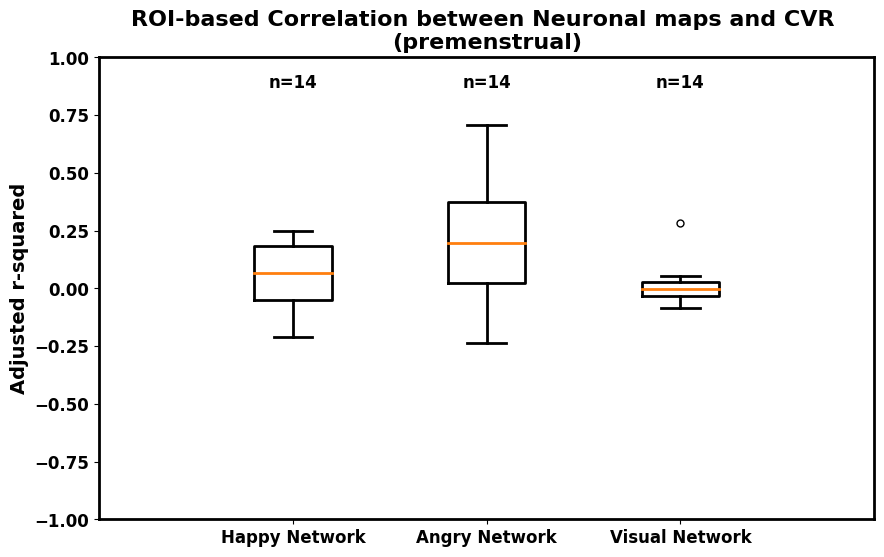

In [153]:
boxplots_poly([CVRpolyr2happy_midcycle,CVRpolyr2angry_midcycle, CVRpolyr2vis_midcycle],"midcycle","CVR")
boxplots_poly([CVRpolyr2happy_premens,CVRpolyr2angry_premens, CVRpolyr2vis_premens],"premenstrual","CVR")

# Alternative Viz

## Linear and Quad

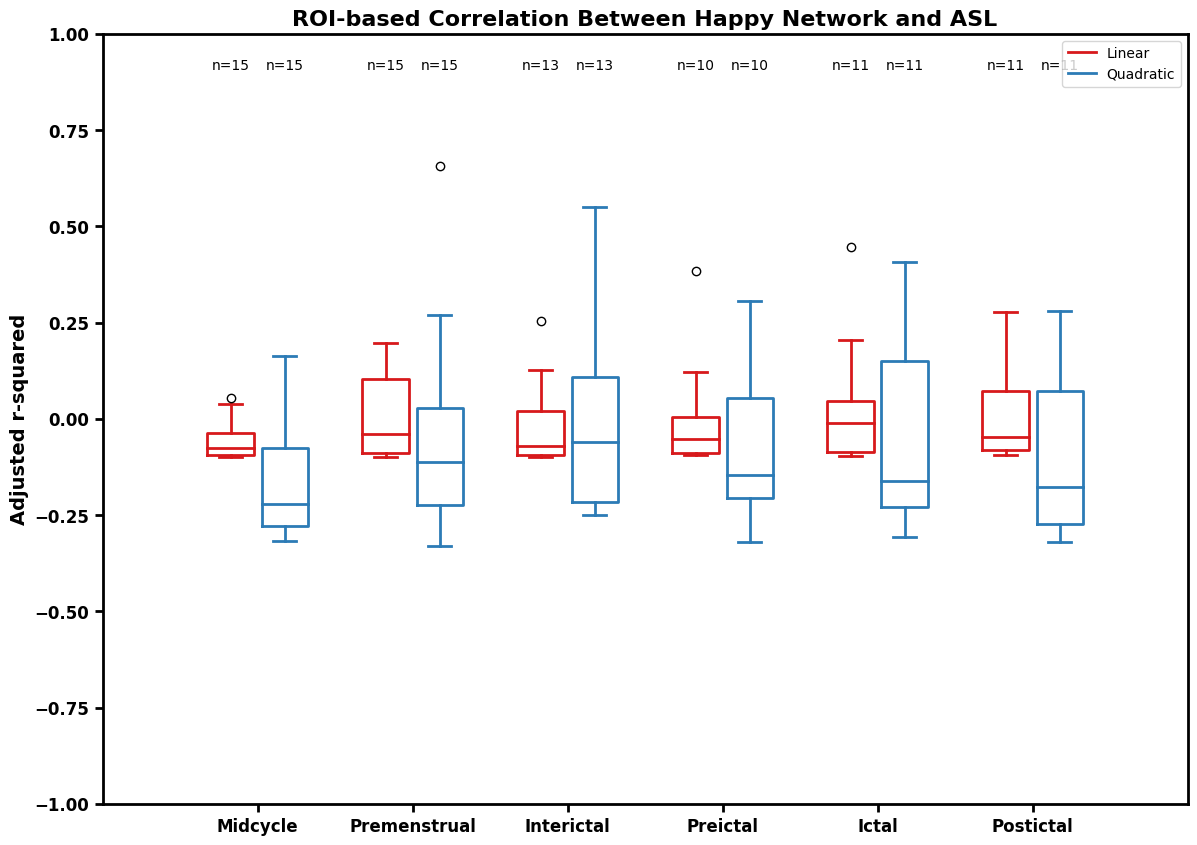

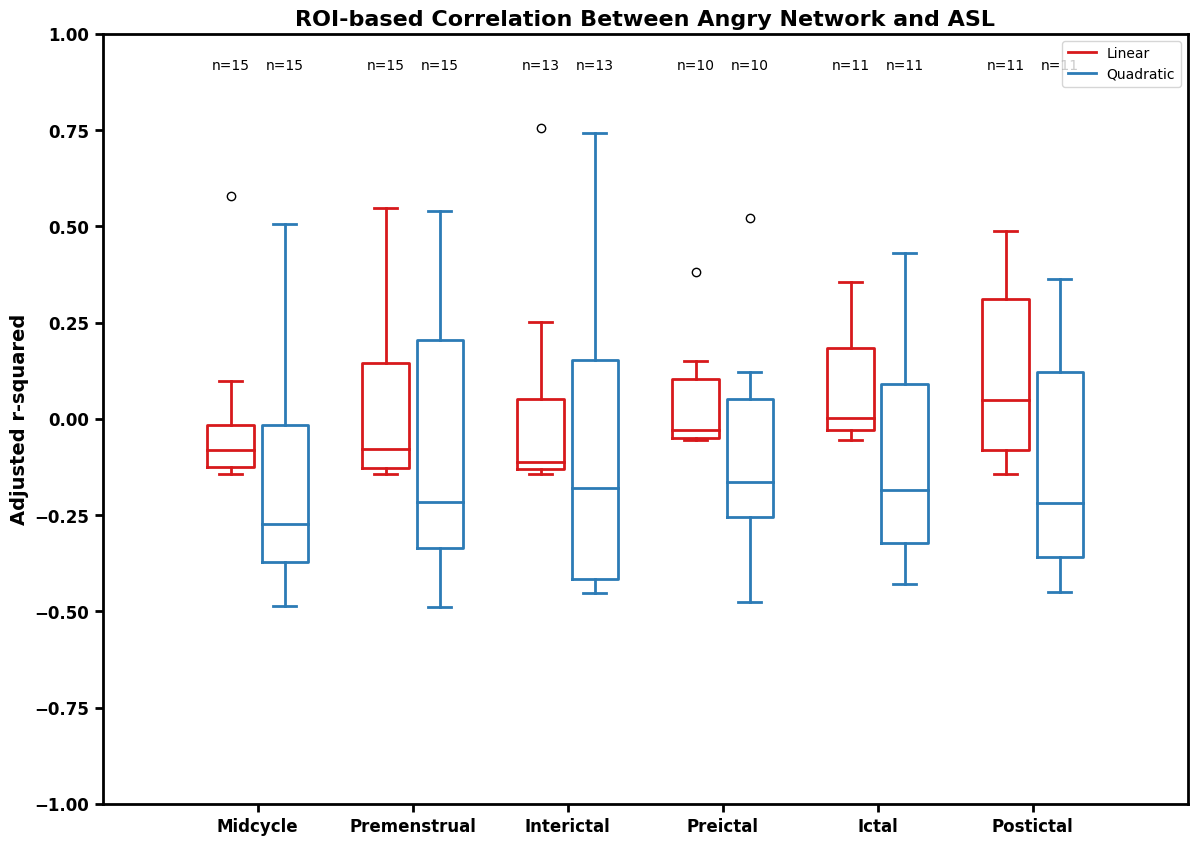

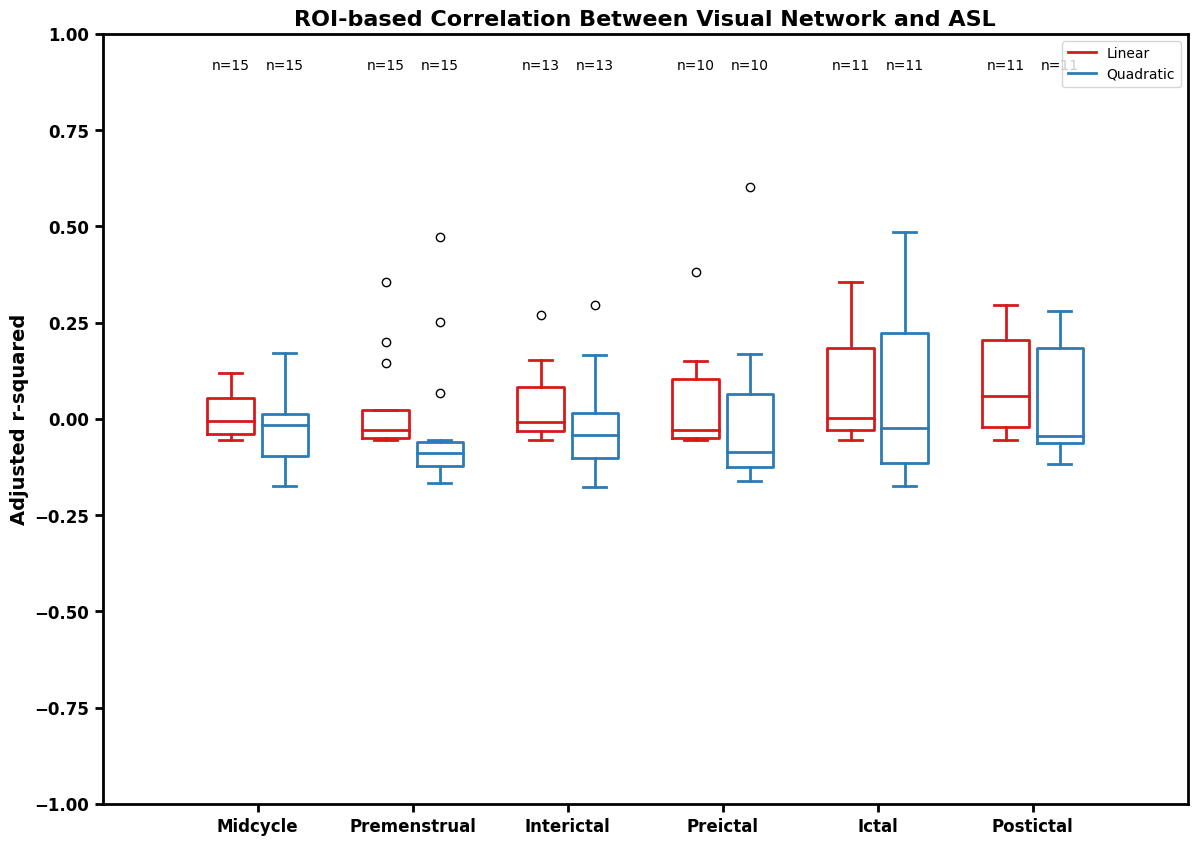

In [143]:
linearplotshappy = [ASLlinH_mid, ASLlinH_premens, ASLlinH_int,ASLlinH_preict,ASLlinH_ict,ASLlinH_postict]
linearplotsangry = [ASLlinA_mid, ASLlinA_premens, ASLlinA_int,ASLlinV_preict,ASLlinV_ict,ASLlinA_postict]
linearplotsvis = [ASLlinV_mid, ASLlinV_premens, ASLlinV_int,ASLlinV_preict,ASLlinV_ict,ASLlinV_postict]

quadplotshappy = [ASLquadH_mid, ASLquadH_premens, ASLquadH_int,ASLquadH_preict, ASLquadH_ict, ASLquadH_postict]
quadplotsangry = [ASLquadA_mid, ASLquadA_premens, ASLquadA_int,ASLquadA_preict, ASLquadA_ict, ASLquadA_postict]
quadplotsvis = [ASLquadV_mid, ASLquadV_premens, ASLquadV_int,ASLquadV_preict, ASLquadV_ict, ASLquadV_postict]

boxplots2(linearplotshappy,quadplotshappy,'Happy Network','ASL')
boxplots2(linearplotsangry,quadplotsangry,"Angry Network","ASL")
boxplots2(linearplotsvis,quadplotsvis,'Visual Network','ASL')

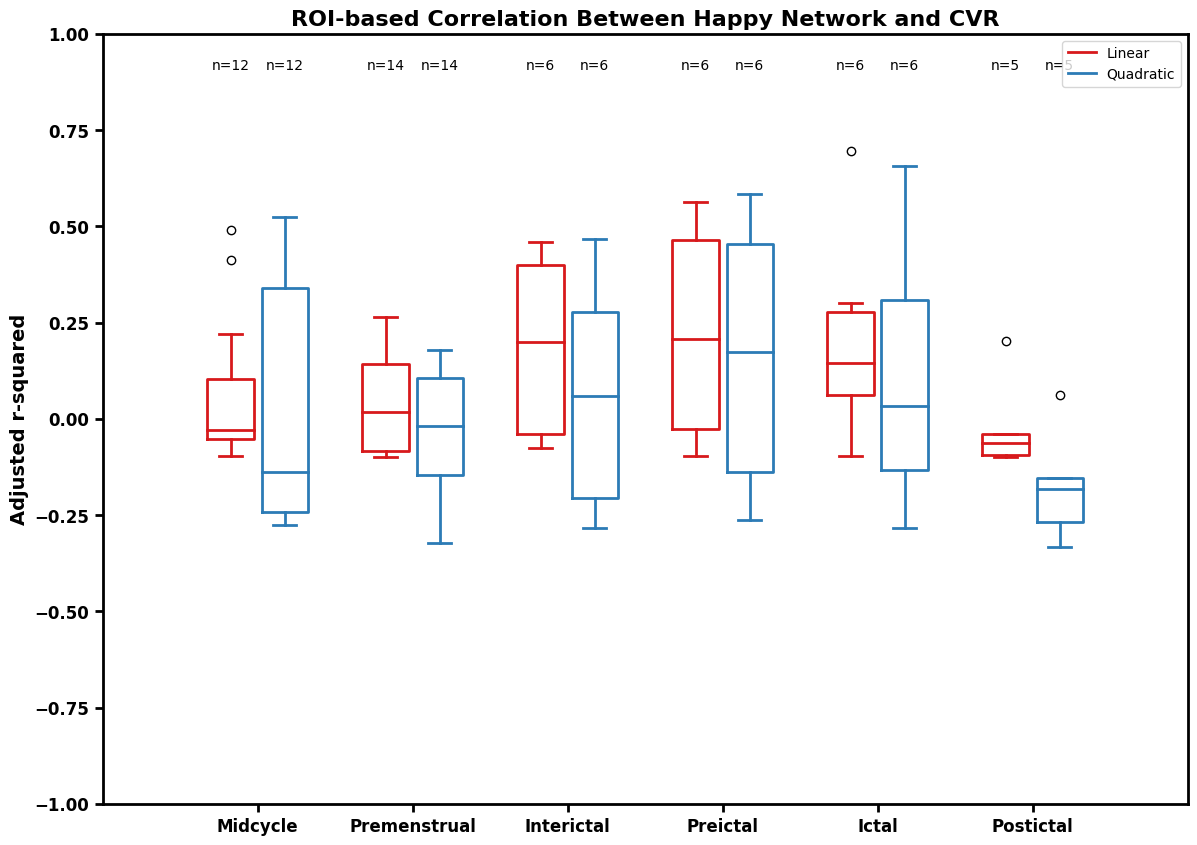

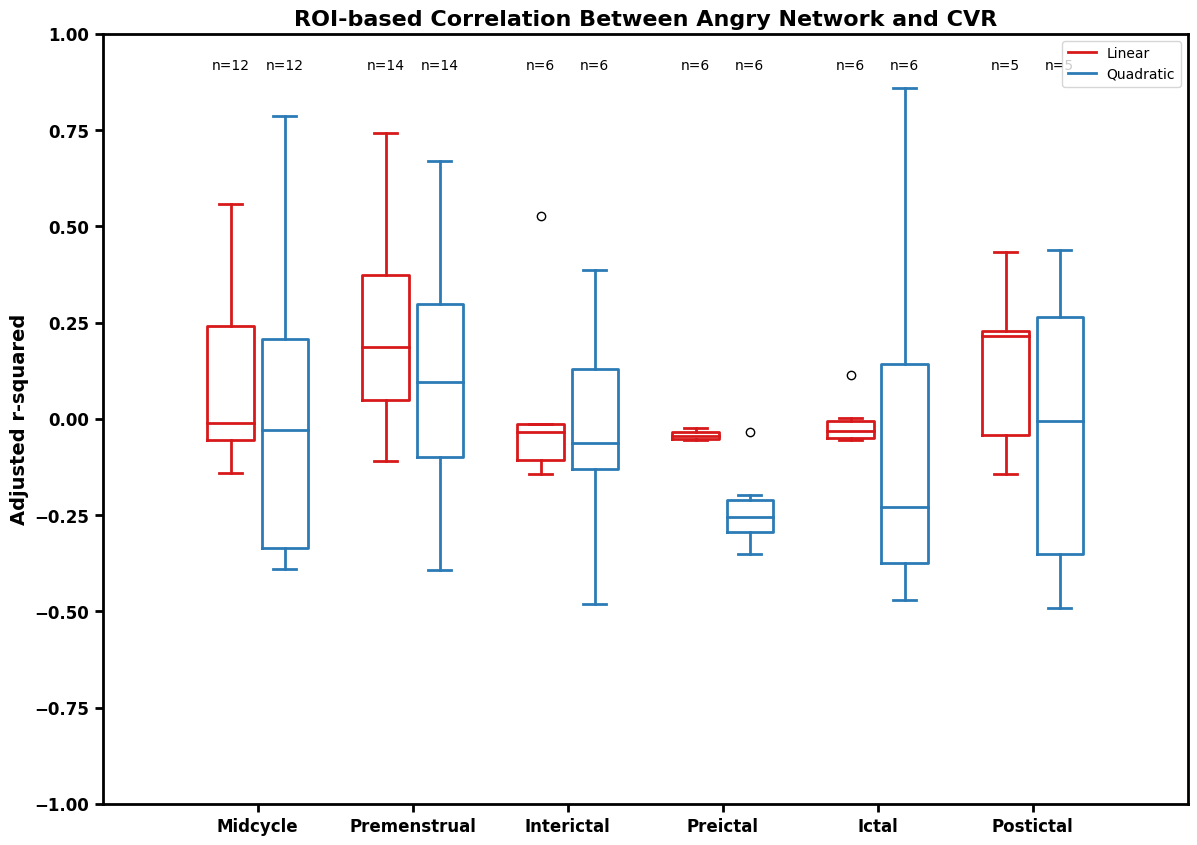

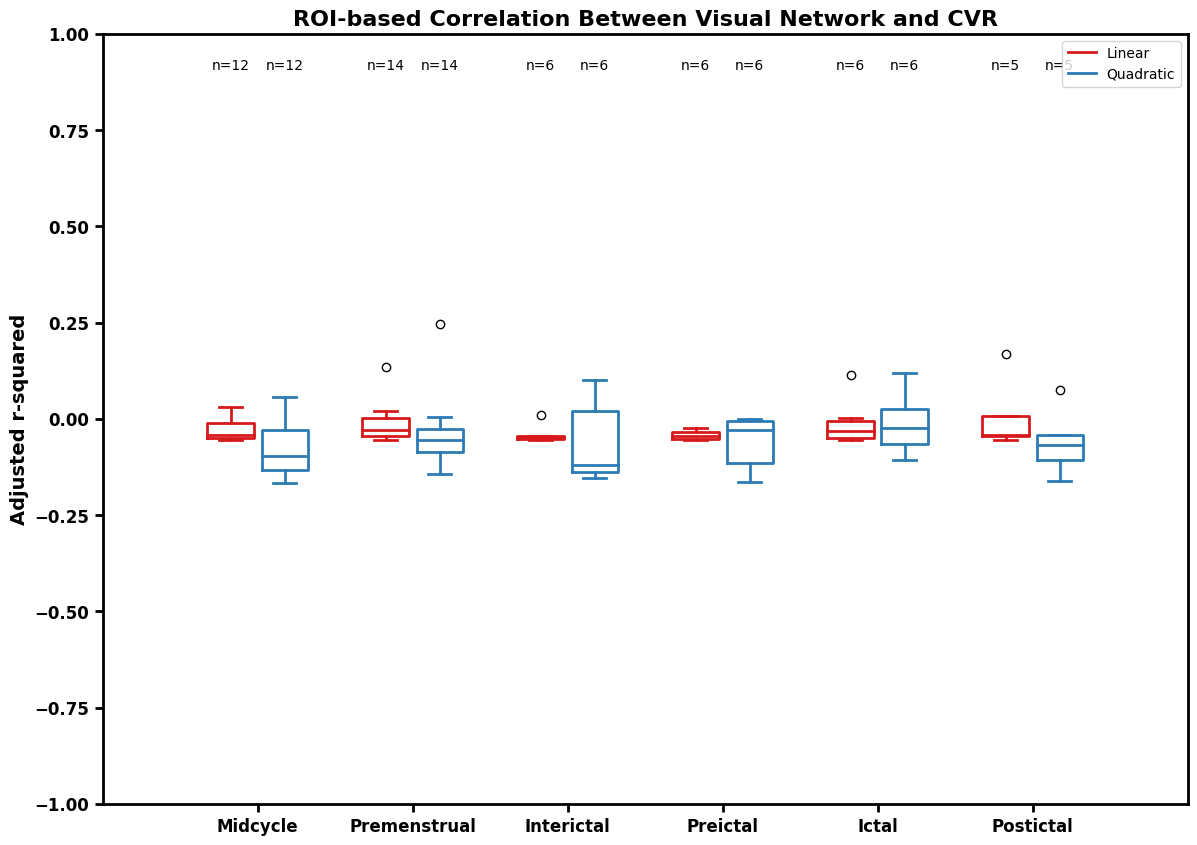

In [144]:
linearplotshappy = [CVRlinH_mid, CVRlinH_premens, CVRlinH_int,CVRlinH_preict,CVRlinH_ict,CVRlinH_postict]
linearplotsangry = [CVRlinA_mid, CVRlinA_premens, CVRlinA_int,CVRlinV_preict,CVRlinV_ict,CVRlinA_postict]
linearplotsvis = [CVRlinV_mid, CVRlinV_premens,CVRlinV_int,CVRlinV_preict,CVRlinV_ict,CVRlinV_postict]

quadplotshappy = [CVRquadH_mid, CVRquadH_premens, CVRquadH_int,CVRquadH_preict, CVRquadH_ict, CVRquadH_postict]
quadplotsangry = [CVRquadA_mid, CVRquadA_premens, CVRquadA_int,CVRquadA_preict, CVRquadA_ict, CVRquadA_postict]
quadplotsvis = [CVRquadV_mid, CVRquadV_premens, CVRquadV_int,CVRquadV_preict, CVRquadV_ict, CVRquadV_postict]

boxplots2(linearplotshappy,quadplotshappy,'Happy Network','CVR')
boxplots2(linearplotsangry,quadplotsangry,"Angry Network","CVR")
boxplots2(linearplotsvis,quadplotsvis,'Visual Network','CVR')

## Polynomial

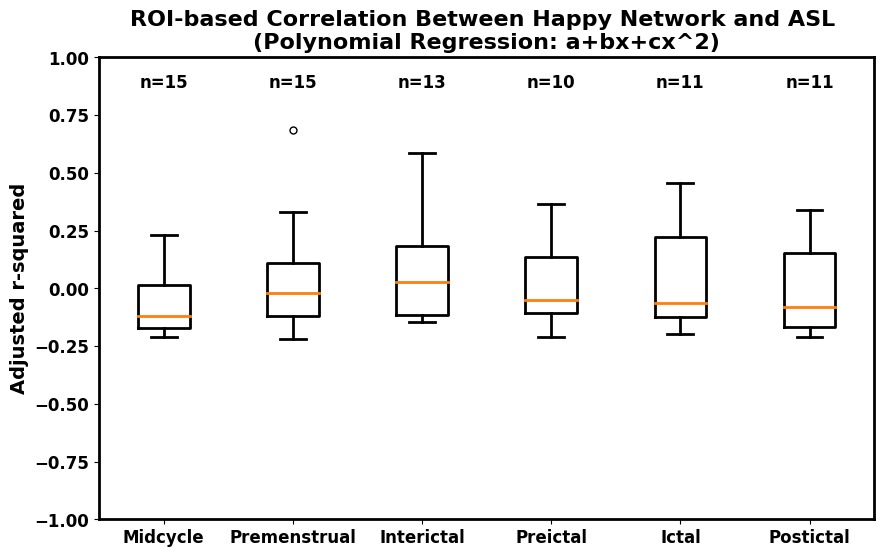

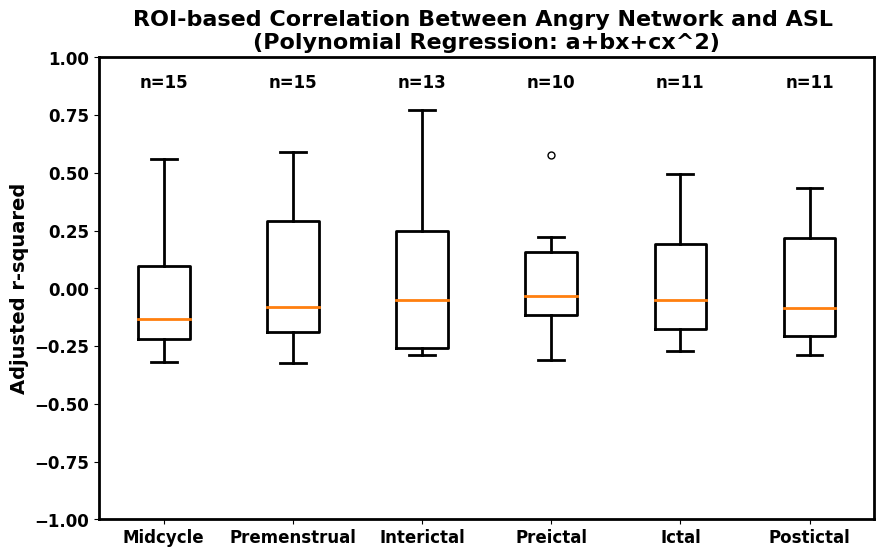

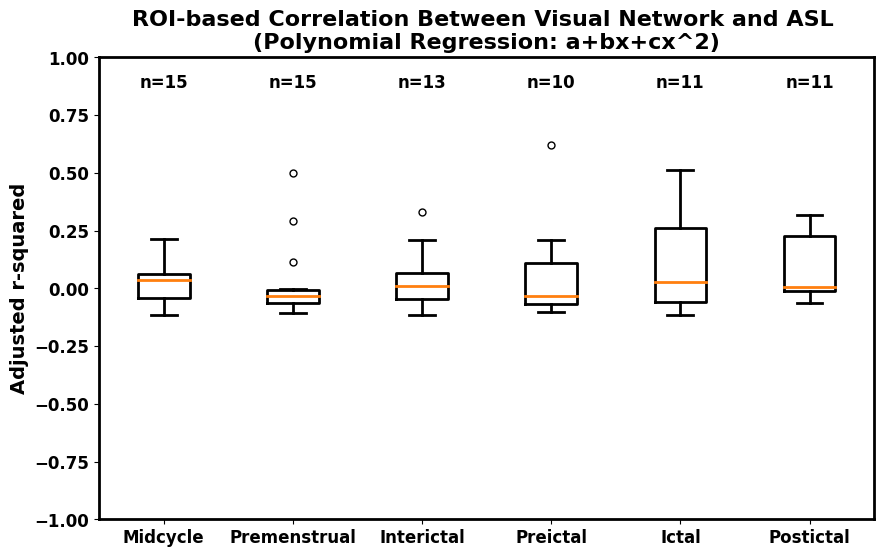

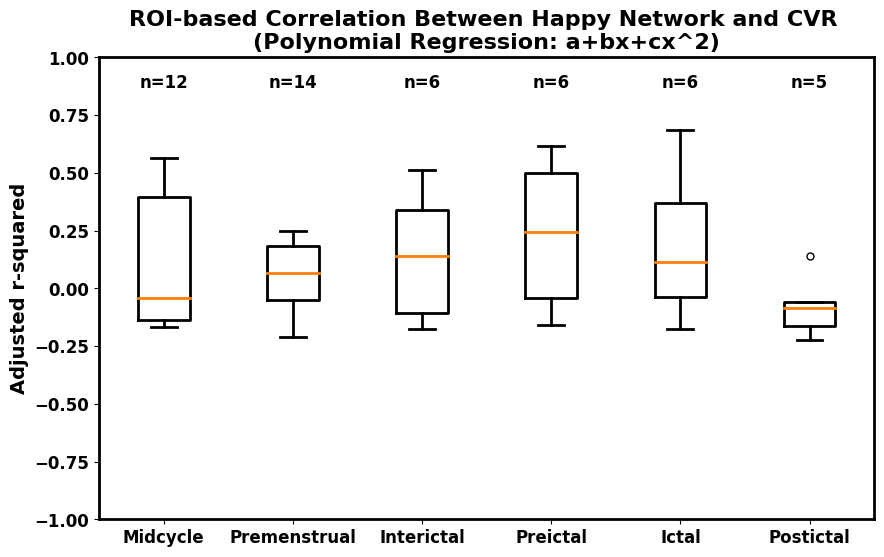

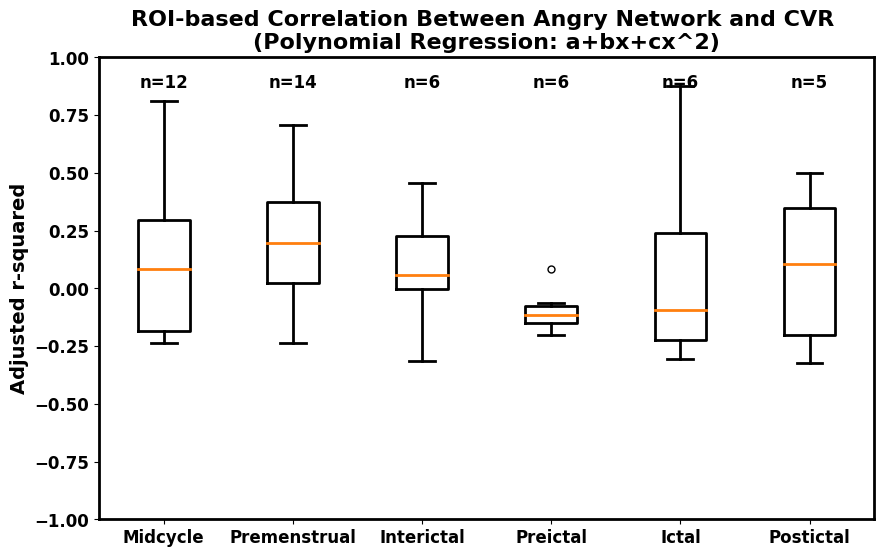

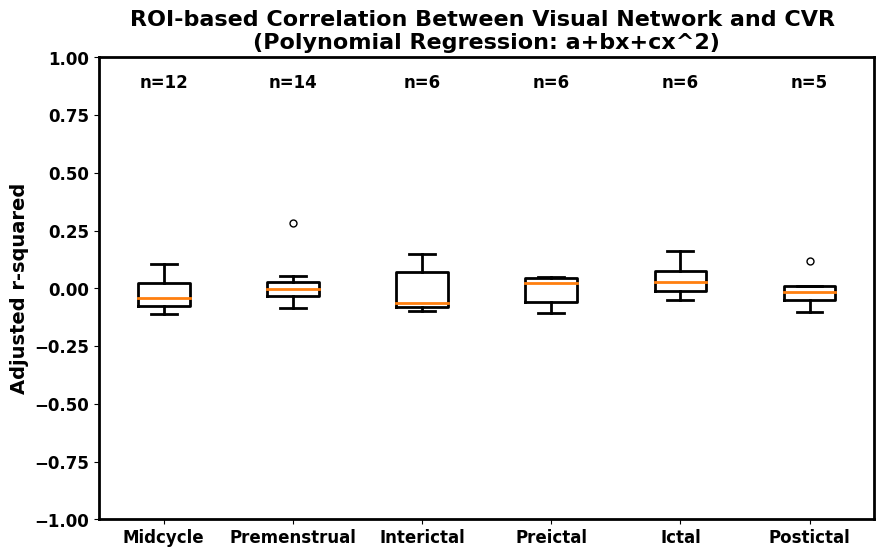

In [154]:
boxplots2_poly([ASLpolyr2happy_midcycle,ASLpolyr2happy_premens,ASLpolyr2happy_int,ASLpolyr2happy_preict,ASLpolyr2happy_ict,ASLpolyr2happy_postict],"Happy Network","ASL")
boxplots2_poly([ASLpolyr2angry_midcycle,ASLpolyr2angry_premens,ASLpolyr2angry_int,ASLpolyr2angry_preict,ASL_polyr2angry_ict,ASpolyr2angry_postict],"Angry Network","ASL")
boxplots2_poly([ASLpolyr2vis_midcycle,ASLpolyr2vis_premens,ASLpolyr2vis_int,ASLpolyr2vis_preict,ASL_polyr2vis_ict,ASLpolyr2vis_postict],"Visual Network","ASL")

boxplots2_poly([CVRpolyr2happy_midcycle,CVRpolyr2happy_premens,CVRpolyr2happy_int,CVRpolyr2happy_preict,CVRpolyr2happy_ict,CVRpolyr2happy_postict],"Happy Network","CVR")
boxplots2_poly([CVRpolyr2angry_midcycle,CVRpolyr2angry_premens,CVRpolyr2angry_int,CVRpolyr2angry_preict,CVRpolyr2angry_ict,CVRpolyr2angry_postict],"Angry Network","CVR")
boxplots2_poly([CVRpolyr2vis_midcycle,CVRpolyr2vis_premens,CVRpolyr2vis_int,CVRpolyr2vis_preict,CVRpolyr2vis_ict,CVRpolyr2vis_postict],"Visual Network","CVR")